##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Actor-Critic 메서드로 CartPole 문제 풀기


<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 튜토리얼에서는 TensorFlow로 [Actor-Critic](https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf) 메서드를 구현하여 [Open AI Gym](https://gym.openai.com/) [`CartPole-v0`](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) 환경에서 에이전트를 훈련하는 방법을 보여줍니다. 독자가 [(심층) 강화 학습](https://en.wikipedia.org/wiki/Deep_reinforcement_learning)의 [정책 그래디언트 메서드](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)에 어느 정도 익숙하다고 가정합니다.


**Actor-Critic 방법**

Actor-Critic 방법은 가치 함수와 독립적인 정책 함수를 나타내는 [Temporal Difference(TD) 학습](https://en.wikipedia.org/wiki/Temporal_difference_learning) 방법입니다.

정책 함수(또는 정책)는 에이전트가 주어진 상태에 따라 취할 수 있는 동작에 대한 확률 분포를 반환합니다. 가치 함수는 주어진 상태에서 시작하여 특정 정책에 따라 영원히 동작하는 에이전트의 예상 이익을 결정합니다.

Actor-Critic 방법에서 정책은 주어진 상태에 따라 가능한 일련의 동작을 제안하는 *행위자*라고 하며, 추정값 함수는 주어진 정책에 따라 *행위자*가 취한 동작을 평가하는 *비평가*라고 합니다.

이 튜토리얼에서 *행위자*와 *비평가* 모두 두 개의 출력이 있는 하나의 신경망을 사용하여 표현됩니다.


**`CartPole-v0`**

[`CartPole-v0` 환경](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)에서는 마찰이 없는 트랙을 따라 이동하는 카트에 막대가 연결되어 있습니다. 막대는 똑바른 상태에서 시작되고 에이전트의 목표는 카트에 `-1` 또는 `+1`의 힘을 가하여 카트가 넘어지는 것을 방지하는 것입니다. 막대가 똑바로 유지될 때마다 `+1`의 보상이 주어집니다. 에피소드는 (1) 막대가 수직에서 15도 이상 기울어지거나 (2) 카트가 중앙에서 2.4 단위 이상 이동하면 끝납니다.

<center>
  <pre data-md-type="custom_pre">&lt;figure&gt;
    &lt;image src="https://tensorflow.org/tutorials/reinforcement_learning/images/cartpole-v0.gif"&gt;
    &lt;figcaption&gt;
      Trained actor-critic model in Cartpole-v0 environment
    &lt;/figcaption&gt;
  &lt;/figure&gt;</pre>
</center>


이 문제는 에피소드에 대한 평균 총 보상이 100회 연속 시도에서 195에 도달하면 "해결"된 것으로 간주됩니다.

## 설정

필요한 패키지를 가져오고 전역 설정을 구성합니다.


In [2]:
!pip install gym[classic_control]
!pip install pyglet

  Installing build dependencies ... -

 \

 |

 done


  Getting requirements to build wheel ... -

 done


  Preparing metadata (pyproject.toml) ... -

 done


  Using cached cloudpickle-2.2.0-py3-none-any.whl (25 kB)


 \

 done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827631 sha256=999b5a51b83586eb7f815286b0d5ea63b8b7e12f978a7b4a52486d0de1855dfb
  Stored in directory: /home/kbuilder/.cache/pip/wheels/fc/bf/16/63ad354aa94e522b5fddf1729d8dfc47ad5980079054d4f714


Successfully built gym


In [3]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y python-opengl > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [4]:
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple


# Create the environment
env = gym.make("CartPole-v1")

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

2022-12-14 22:10:33.689797: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:10:33.689897: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:10:33.689907: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 모델

*행위자*와 *비평가*는 각각 동작 확률과 비평 값을 생성하는 하나의 신경망을 사용하여 모델링됩니다. 이 튜토리얼에서는 모델 하위 클래스화를 사용하여 모델을 정의합니다.

순방향 전달 중에 모델은 상태를 입력으로 받고 상태 종속 [값 함수](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#value-functions)를 모델링하는 동작 확률과 비평 값 $V$를 모두 출력합니다. 목표는 예상 [이익](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#reward-and-return)을 최대화하는 $\pi$ 정책을 기반으로 행동을 선택하는 모델을 훈련하는 것입니다.

`CartPole-v0`의 경우, 상태를 나타내는 네 가지 값이 있는데, 각각 카트 위치, 카트 속도, 막대 각도 및 막대 속도입니다. 에이전트는 카트를 각각 왼쪽(`0`)과 오른쪽(`1`)으로 밀기 위해 두 가지 동작을 취할 수 있습니다.

더 자세한 내용은 [Gym의 Cart Pole 문서화 페이지](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) 및 Barto, Sutton 및 Anderson(1983)의 [*어려운 학습 제어 문제를 해결할 수 있는 뉴런 유사 적응 요소*](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf)를 참조하세요.


In [5]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [6]:
num_actions = env.action_space.n  # 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

## 에이전트 훈련

에이전트를 훈련하기 위해 다음 단계를 따릅니다.

1. 환경에서 에이전트를 실행하여 에피소드별로 훈련 데이터를 수집합니다.
2. 각 시간 스텝에서 예상 이익을 계산합니다.
3. 결합된 Actor-Critic 모델의 손실을 계산합니다.
4. 그래디언트를 계산하고 네트워크 매개변수를 업데이트합니다.
5. 성공 기준 또는 최대 에피소드에 도달할 때까지 1~4를 반복합니다.


### 1. 훈련 데이터 수집

지도 학습에서와 같이 Actor-Critic 모델을 훈련하려면 훈련 데이터가 필요합니다. 그러나, 이러한 데이터를 수집하려면 모델이 환경에서 "실행"되어야 합니다.

여기서는 각 에피소드에 대한 훈련 데이터를 수집합니다. 그런 다음, 모델의 가중치에 의해 매개변수화된 현재 정책을 기반으로 동작 확률과 비평 값을 생성하기 위해 각 타임스텝에서 모델의 순방향 전달을 환경 상태에서 실행합니다.

다음 동작은 모델에 의해 생성된 동작 확률로부터 샘플링되며, 그런 다음 환경에 적용되어 다음 상태와 보상을 생성합니다.

이 프로세스는 더 빠른 훈련을 위해 나중에 TensorFlow 그래프로 컴파일할 수 있도록 TensorFlow 연산을 사용하는 `run_episode` 함수에서 구현됩니다. `tf.TensorArray`는 가변 길이 배열에서 Tensor 반복을 지원하는 데 사용되었습니다.

In [7]:
# Wrap Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, truncated, info = env.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32), 
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

In [8]:
def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)
  
    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)
  
    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])
  
    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)
  
    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()
  
  return action_probs, values, rewards

### 2. 예상 이익 계산

한 에피소드 동안 수집된 각 타임스텝 $t$, ${r_{t}}^{T}*{t=1}$에서 보상의 시퀀스를 예상 이익 ${G*{t}}^{T}_{t=1}$의 시퀀스로 변환합니다. 여기서 보상의 합계는 현재 타임스텝 $t$에서 $T$까지 계산되며, 각 보상에 기하급수적으로 감소하는 할인 계수 $\gamma$를 곱합니다.

$$G_{t} = \sum^{T}_{t'=t} \gamma^{t'-t}r_{t'}$$

$\gamma\in(0,1)$ 이후, 현재 타임스텝에서 더 멀리 떨어진 보상에는 더 적은 가중치가 부여됩니다.

직관적으로, 예상 이익은 단순히 지금 보상이 이후 보상보다 낫다는 것을 암시합니다. 이것은 수학적 의미에서 보상의 합이 수렴하도록 하려는 것입니다.

To stabilize training, the resulting sequence of returns is also standardized (i.e. to have zero mean and unit standard deviation).


In [9]:
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

### 3. Actor-Critic 손실

하이브리드 Actor-Critic 모델을 사용하고 있기 때문에, 아래와 같이 훈련을 위해 Actor와 Critic 손실의 조합인 손실 함수를 사용합니다.

$$L = L_{actor} + L_{critic}$$

#### Actor 손실

[비평가가 상태 종속 기준선인 정책 그래디언트](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s)를 기반으로 행위자 손실을 공식화하고 단일 샘플(에피소드별) 추정치를 계산합니다.

$$L_{actor} = -\sum^{T}_{t=1} \log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

여기서:

- $T$: 에피소드별로 달라질 수 있는 에피소드별 타임스텝의 수
- $s_{t}$: $t$ 타임스텝의 상태
- $a_{t}$: $s$ 상태에 따라 $t$ 타임스텝에서 선택된 동작
- $\pi_{\theta}$: $\theta$에 의해 매개변수화된 정책(Actor)
- $V^{\pi}_{\theta}$: 마찬가지로 $\theta$에 의해 매개변수화된 값 함수(Critic)
- $G = G_{t}$: 주어진 상태에 대한 예상 이익, 타임스텝 $t$에서 동작 쌍

A negative term is added to the sum since the idea is to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

<br>

##### 이점

$L_{actor}$ 공식에서 $G - V$ 항을 [이점](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions)이라고 하며, 이는 특정한 상태에서 $\pi$ 정책에 따라 선택된 임의의 동작보다 이 상태에 얼마나 더 나은 동작이 주어지는지를 나타냅니다.

기준선을 제외할 수 있지만 이로 인해 훈련 중에 큰 변동이 발생할 수 있습니다. 그리고 비평가 $V$를 기준선으로 선택할 때의 좋은 점은 가능한 한 $G$에 가깝게 훈련되어 변동이 낮아진다는 것입니다.

또한, Critic이 없으면 알고리즘이 예상 이익을 바탕으로 특정 상태에서 취하는 행동의 확률을 높이려고 시도할 것이며, 이 때 동작 사이의 상대적 확률이 같게 유지된다면 큰 차이가 생기지 않습니다.

예를 들어, 주어진 상태에서 두 행동의 예상 이익이 같다고 가정합니다. Critic이 없으면 알고리즘은 목표 $J$에 따라 이들 동작의 확률을 높이려고 합니다. Critic의 경우, 이점($G - V = 0$)이 없기 때문에 동작의 확률을 높이는 데 따른 이점이 없으며 알고리즘이 그래디언트를 0으로 설정합니다.

<br>

#### The Critic loss

$V$를 $G$에 최대한 가깝게 훈련하는 것은 다음 손실 함수를 사용한 회귀 문제로 설정할 수 있습니다.

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

여기서 $L_{\delta}$는 [Huber 손실](https://en.wikipedia.org/wiki/Huber_loss)로, 제곱 오차 손실보다 데이터의 이상 값에 덜 민감합니다.


In [10]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined Actor-Critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

### 4. 매개변수를 업데이트하기 위한 훈련 단계 정의

위의 모든 단계를 모든 에피소드에서 실행되는 훈련 단계로 결합합니다. 손실 함수로 이어지는 모든 단계는 `tf.GradientTape` 컨텍스트로 실행되어 자동 미분이 가능합니다.

이 튜토리얼에서는 Adam 옵티마이저를 사용하여 모델 매개변수에 그래디언트를 적용합니다.

할인되지 않은 보상의 합계인 `episode_reward`도 이 단계에서 계산됩니다. 이 값은 나중에 성공 기준이 충족되는지 평가하는 데 사용됩니다.

`tf.function` 컨텍스트를 `train_step` 함수에 적용하여 호출 가능한 TensorFlow 그래프로 컴파일할 수 있고, 그러면 훈련 속도가 10배 빨라질 수 있습니다.


In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode) 

    # Calculate the expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculate the loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

### 5. 훈련 루프 실행하기

성공 기준 또는 최대 에피소드 수에 도달할 때까지 훈련 단계를 실행하는 방식으로 훈련을 실행합니다.

대기열을 사용하여 에피소드 보상의 실행 레코드를 유지합니다. 100회 시도에 도달하면 가장 오래된 보상이 대기열의 왼쪽(꼬리쪽) 끝에서 제거되고 최근 보상이 머리쪽(오른쪽)에 추가됩니다. 계산 효율을 높이기 위해 보상의 누적 합계도 유지됩니다.

런타임에 따라 훈련은 1분 이내에 완료될 수 있습니다.

In [12]:
%%time

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 500

# `CartPole-v1` is considered solved if average reward is >= 475 over 500 
# consecutive trials
reward_threshold = 475
running_reward = 0

# The discount factor for future rewards
gamma = 0.99

# Keep the last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

t = tqdm.trange(max_episodes)
for i in t:
    initial_state, info = env.reset()
    initial_state = tf.constant(initial_state, dtype=tf.float32)
    episode_reward = int(train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode))
    
    episodes_reward.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)
  

    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)
  
    # Show the average episode reward every 10 episodes
    if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')
  
    if running_reward > reward_threshold and i >= min_episodes_criterion:  
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

  0%|          | 0/10000 [00:00<?, ?it/s]

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


  0%|          | 0/10000 [00:02<?, ?it/s, episode_reward=42, running_reward=42]

  0%|          | 1/10000 [00:02<7:42:44,  2.78s/it, episode_reward=42, running_reward=42]

  0%|          | 1/10000 [00:02<7:42:44,  2.78s/it, episode_reward=26, running_reward=34]

  0%|          | 1/10000 [00:02<7:42:44,  2.78s/it, episode_reward=43, running_reward=37]

  0%|          | 3/10000 [00:02<2:06:31,  1.32it/s, episode_reward=43, running_reward=37]

  0%|          | 3/10000 [00:02<2:06:31,  1.32it/s, episode_reward=14, running_reward=31.2]

  0%|          | 3/10000 [00:02<2:06:31,  1.32it/s, episode_reward=36, running_reward=32.2]

  0%|          | 3/10000 [00:02<2:06:31,  1.32it/s, episode_reward=10, running_reward=28.5]

  0%|          | 3/10000 [00:03<2:06:31,  1.32it/s, episode_reward=34, running_reward=29.3]

  0%|          | 7/10000 [00:03<44:58,  3.70it/s, episode_reward=34, running_reward=29.3]  

  0%|          | 7/10000 [00:03<44:58,  3.70it/s, episode_reward=51, running_reward=32]  

  0%|          | 7/10000 [00:03<44:58,  3.70it/s, episode_reward=11, running_reward=29.7]

  0%|          | 9/10000 [00:03<33:04,  5.04it/s, episode_reward=11, running_reward=29.7]

  0%|          | 9/10000 [00:03<33:04,  5.04it/s, episode_reward=33, running_reward=30]  

  0%|          | 9/10000 [00:03<33:04,  5.04it/s, episode_reward=34, running_reward=30.4]

  0%|          | 11/10000 [00:03<25:13,  6.60it/s, episode_reward=34, running_reward=30.4]

  0%|          | 11/10000 [00:03<25:13,  6.60it/s, episode_reward=35, running_reward=30.8]

  0%|          | 11/10000 [00:03<25:13,  6.60it/s, episode_reward=17, running_reward=29.7]

  0%|          | 11/10000 [00:03<25:13,  6.60it/s, episode_reward=26, running_reward=29.4]

  0%|          | 14/10000 [00:03<17:50,  9.33it/s, episode_reward=26, running_reward=29.4]

  0%|          | 14/10000 [00:03<17:50,  9.33it/s, episode_reward=16, running_reward=28.5]

  0%|          | 14/10000 [00:03<17:50,  9.33it/s, episode_reward=19, running_reward=27.9]

  0%|          | 14/10000 [00:03<17:50,  9.33it/s, episode_reward=39, running_reward=28.6]

  0%|          | 17/10000 [00:03<13:44, 12.10it/s, episode_reward=39, running_reward=28.6]

  0%|          | 17/10000 [00:03<13:44, 12.10it/s, episode_reward=23, running_reward=28.3]

  0%|          | 17/10000 [00:03<13:44, 12.10it/s, episode_reward=16, running_reward=27.6]

  0%|          | 17/10000 [00:03<13:44, 12.10it/s, episode_reward=10, running_reward=26.8]

  0%|          | 17/10000 [00:03<13:44, 12.10it/s, episode_reward=10, running_reward=26]  

  0%|          | 17/10000 [00:03<13:44, 12.10it/s, episode_reward=14, running_reward=25.4]

  0%|          | 22/10000 [00:03<09:13, 18.02it/s, episode_reward=14, running_reward=25.4]

  0%|          | 22/10000 [00:03<09:13, 18.02it/s, episode_reward=21, running_reward=25.2]

  0%|          | 22/10000 [00:03<09:13, 18.02it/s, episode_reward=10, running_reward=24.6]

  0%|          | 22/10000 [00:03<09:13, 18.02it/s, episode_reward=17, running_reward=24.3]

  0%|          | 22/10000 [00:03<09:13, 18.02it/s, episode_reward=15, running_reward=23.9]

  0%|          | 26/10000 [00:03<07:27, 22.27it/s, episode_reward=15, running_reward=23.9]

  0%|          | 26/10000 [00:03<07:27, 22.27it/s, episode_reward=14, running_reward=23.6]

  0%|          | 26/10000 [00:03<07:27, 22.27it/s, episode_reward=13, running_reward=23.2]

  0%|          | 26/10000 [00:03<07:27, 22.27it/s, episode_reward=13, running_reward=22.8]

  0%|          | 26/10000 [00:03<07:27, 22.27it/s, episode_reward=11, running_reward=22.4]

  0%|          | 26/10000 [00:03<07:27, 22.27it/s, episode_reward=25, running_reward=22.5]

  0%|          | 31/10000 [00:03<06:21, 26.13it/s, episode_reward=25, running_reward=22.5]

  0%|          | 31/10000 [00:03<06:21, 26.13it/s, episode_reward=12, running_reward=22.2]

  0%|          | 31/10000 [00:03<06:21, 26.13it/s, episode_reward=18, running_reward=22.1]

  0%|          | 31/10000 [00:03<06:21, 26.13it/s, episode_reward=15, running_reward=21.9]

  0%|          | 31/10000 [00:03<06:21, 26.13it/s, episode_reward=20, running_reward=21.8]

  0%|          | 35/10000 [00:03<05:51, 28.37it/s, episode_reward=20, running_reward=21.8]

  0%|          | 35/10000 [00:03<05:51, 28.37it/s, episode_reward=13, running_reward=21.6]

  0%|          | 35/10000 [00:04<05:51, 28.37it/s, episode_reward=20, running_reward=21.5]

  0%|          | 35/10000 [00:04<05:51, 28.37it/s, episode_reward=18, running_reward=21.4]

  0%|          | 35/10000 [00:04<05:51, 28.37it/s, episode_reward=22, running_reward=21.4]

  0%|          | 39/10000 [00:04<05:37, 29.51it/s, episode_reward=22, running_reward=21.4]

  0%|          | 39/10000 [00:04<05:37, 29.51it/s, episode_reward=12, running_reward=21.2]

  0%|          | 39/10000 [00:04<05:37, 29.51it/s, episode_reward=13, running_reward=21]  

  0%|          | 39/10000 [00:04<05:37, 29.51it/s, episode_reward=11, running_reward=20.8]

  0%|          | 39/10000 [00:04<05:37, 29.51it/s, episode_reward=28, running_reward=20.9]

  0%|          | 43/10000 [00:04<05:17, 31.34it/s, episode_reward=28, running_reward=20.9]

  0%|          | 43/10000 [00:04<05:17, 31.34it/s, episode_reward=21, running_reward=20.9]

  0%|          | 43/10000 [00:04<05:17, 31.34it/s, episode_reward=18, running_reward=20.9]

  0%|          | 43/10000 [00:04<05:17, 31.34it/s, episode_reward=14, running_reward=20.7]

  0%|          | 43/10000 [00:04<05:17, 31.34it/s, episode_reward=17, running_reward=20.6]

  0%|          | 47/10000 [00:04<05:10, 32.04it/s, episode_reward=17, running_reward=20.6]

  0%|          | 47/10000 [00:04<05:10, 32.04it/s, episode_reward=37, running_reward=21]  

  0%|          | 47/10000 [00:04<05:10, 32.04it/s, episode_reward=19, running_reward=20.9]

  0%|          | 47/10000 [00:04<05:10, 32.04it/s, episode_reward=26, running_reward=21]  

  0%|          | 47/10000 [00:04<05:10, 32.04it/s, episode_reward=26, running_reward=21.1]

  1%|          | 51/10000 [00:04<05:53, 28.13it/s, episode_reward=26, running_reward=21.1]

  1%|          | 51/10000 [00:04<05:53, 28.13it/s, episode_reward=25, running_reward=21.2]

  1%|          | 51/10000 [00:04<05:53, 28.13it/s, episode_reward=24, running_reward=21.3]

  1%|          | 51/10000 [00:04<05:53, 28.13it/s, episode_reward=39, running_reward=21.6]

  1%|          | 51/10000 [00:04<05:53, 28.13it/s, episode_reward=35, running_reward=21.8]

  1%|          | 55/10000 [00:04<06:49, 24.26it/s, episode_reward=35, running_reward=21.8]

  1%|          | 55/10000 [00:04<06:49, 24.26it/s, episode_reward=9, running_reward=21.6] 

  1%|          | 55/10000 [00:04<06:49, 24.26it/s, episode_reward=21, running_reward=21.6]

  1%|          | 55/10000 [00:04<06:49, 24.26it/s, episode_reward=16, running_reward=21.5]

  1%|          | 55/10000 [00:04<06:49, 24.26it/s, episode_reward=24, running_reward=21.5]

  1%|          | 59/10000 [00:04<06:12, 26.70it/s, episode_reward=24, running_reward=21.5]

  1%|          | 59/10000 [00:04<06:12, 26.70it/s, episode_reward=16, running_reward=21.4]

  1%|          | 59/10000 [00:04<06:12, 26.70it/s, episode_reward=15, running_reward=21.3]

  1%|          | 59/10000 [00:04<06:12, 26.70it/s, episode_reward=10, running_reward=21.2]

  1%|          | 59/10000 [00:04<06:12, 26.70it/s, episode_reward=11, running_reward=21]  

  1%|          | 59/10000 [00:04<06:12, 26.70it/s, episode_reward=15, running_reward=20.9]

  1%|          | 64/10000 [00:04<05:18, 31.16it/s, episode_reward=15, running_reward=20.9]

  1%|          | 64/10000 [00:04<05:18, 31.16it/s, episode_reward=10, running_reward=20.7]

  1%|          | 64/10000 [00:04<05:18, 31.16it/s, episode_reward=10, running_reward=20.6]

  1%|          | 64/10000 [00:04<05:18, 31.16it/s, episode_reward=14, running_reward=20.5]

  1%|          | 64/10000 [00:05<05:18, 31.16it/s, episode_reward=17, running_reward=20.4]

  1%|          | 64/10000 [00:05<05:18, 31.16it/s, episode_reward=15, running_reward=20.3]

  1%|          | 69/10000 [00:05<04:48, 34.38it/s, episode_reward=15, running_reward=20.3]

  1%|          | 69/10000 [00:05<04:48, 34.38it/s, episode_reward=20, running_reward=20.3]

  1%|          | 69/10000 [00:05<04:48, 34.38it/s, episode_reward=32, running_reward=20.5]

  1%|          | 69/10000 [00:05<04:48, 34.38it/s, episode_reward=14, running_reward=20.4]

  1%|          | 69/10000 [00:05<04:48, 34.38it/s, episode_reward=22, running_reward=20.4]

  1%|          | 73/10000 [00:05<05:11, 31.85it/s, episode_reward=22, running_reward=20.4]

  1%|          | 73/10000 [00:05<05:11, 31.85it/s, episode_reward=14, running_reward=20.4]

  1%|          | 73/10000 [00:05<05:11, 31.85it/s, episode_reward=12, running_reward=20.2]

  1%|          | 73/10000 [00:05<05:11, 31.85it/s, episode_reward=26, running_reward=20.3]

  1%|          | 73/10000 [00:05<05:11, 31.85it/s, episode_reward=28, running_reward=20.4]

  1%|          | 77/10000 [00:05<05:13, 31.63it/s, episode_reward=28, running_reward=20.4]

  1%|          | 77/10000 [00:05<05:13, 31.63it/s, episode_reward=31, running_reward=20.6]

  1%|          | 77/10000 [00:05<05:13, 31.63it/s, episode_reward=22, running_reward=20.6]

  1%|          | 77/10000 [00:05<05:13, 31.63it/s, episode_reward=25, running_reward=20.6]

  1%|          | 77/10000 [00:05<05:13, 31.63it/s, episode_reward=29, running_reward=20.7]

  1%|          | 81/10000 [00:05<05:43, 28.90it/s, episode_reward=29, running_reward=20.7]

  1%|          | 81/10000 [00:05<05:43, 28.90it/s, episode_reward=26, running_reward=20.8]

  1%|          | 81/10000 [00:05<05:43, 28.90it/s, episode_reward=30, running_reward=20.9]

  1%|          | 81/10000 [00:05<05:43, 28.90it/s, episode_reward=44, running_reward=21.2]

  1%|          | 81/10000 [00:05<05:43, 28.90it/s, episode_reward=45, running_reward=21.5]

  1%|          | 85/10000 [00:05<06:55, 23.85it/s, episode_reward=45, running_reward=21.5]

  1%|          | 85/10000 [00:05<06:55, 23.85it/s, episode_reward=27, running_reward=21.5]

  1%|          | 85/10000 [00:05<06:55, 23.85it/s, episode_reward=15, running_reward=21.4]

  1%|          | 85/10000 [00:05<06:55, 23.85it/s, episode_reward=36, running_reward=21.6]

  1%|          | 88/10000 [00:05<06:59, 23.63it/s, episode_reward=36, running_reward=21.6]

  1%|          | 88/10000 [00:05<06:59, 23.63it/s, episode_reward=22, running_reward=21.6]

  1%|          | 88/10000 [00:06<06:59, 23.63it/s, episode_reward=73, running_reward=22.2]

  1%|          | 88/10000 [00:06<06:59, 23.63it/s, episode_reward=81, running_reward=22.8]

  1%|          | 91/10000 [00:06<09:06, 18.13it/s, episode_reward=81, running_reward=22.8]

  1%|          | 91/10000 [00:06<09:06, 18.13it/s, episode_reward=52, running_reward=23.2]

  1%|          | 91/10000 [00:06<09:06, 18.13it/s, episode_reward=22, running_reward=23.1]

  1%|          | 91/10000 [00:06<09:06, 18.13it/s, episode_reward=18, running_reward=23.1]

  1%|          | 94/10000 [00:06<08:49, 18.71it/s, episode_reward=18, running_reward=23.1]

  1%|          | 94/10000 [00:06<08:49, 18.71it/s, episode_reward=15, running_reward=23]  

  1%|          | 94/10000 [00:06<08:49, 18.71it/s, episode_reward=20, running_reward=23]

  1%|          | 94/10000 [00:06<08:49, 18.71it/s, episode_reward=44, running_reward=23.2]

  1%|          | 97/10000 [00:06<08:12, 20.10it/s, episode_reward=44, running_reward=23.2]

  1%|          | 97/10000 [00:06<08:12, 20.10it/s, episode_reward=65, running_reward=23.6]

  1%|          | 97/10000 [00:06<08:12, 20.10it/s, episode_reward=20, running_reward=23.6]

  1%|          | 97/10000 [00:06<08:12, 20.10it/s, episode_reward=38, running_reward=23.7]

  1%|          | 100/10000 [00:06<08:58, 18.39it/s, episode_reward=38, running_reward=23.7]

  1%|          | 100/10000 [00:06<08:58, 18.39it/s, episode_reward=33, running_reward=23.6]

  1%|          | 100/10000 [00:06<08:58, 18.39it/s, episode_reward=114, running_reward=24.5]

  1%|          | 102/10000 [00:06<11:02, 14.95it/s, episode_reward=114, running_reward=24.5]

  1%|          | 102/10000 [00:06<11:02, 14.95it/s, episode_reward=79, running_reward=24.9] 

  1%|          | 102/10000 [00:07<11:02, 14.95it/s, episode_reward=38, running_reward=25.1]

  1%|          | 104/10000 [00:07<11:56, 13.82it/s, episode_reward=38, running_reward=25.1]

  1%|          | 104/10000 [00:07<11:56, 13.82it/s, episode_reward=37, running_reward=25.1]

  1%|          | 104/10000 [00:07<11:56, 13.82it/s, episode_reward=113, running_reward=26.1]

  1%|          | 106/10000 [00:07<13:26, 12.27it/s, episode_reward=113, running_reward=26.1]

  1%|          | 106/10000 [00:07<13:26, 12.27it/s, episode_reward=61, running_reward=26.4] 

  1%|          | 106/10000 [00:07<13:26, 12.27it/s, episode_reward=122, running_reward=27.1]

  1%|          | 108/10000 [00:07<15:44, 10.47it/s, episode_reward=122, running_reward=27.1]

  1%|          | 108/10000 [00:07<15:44, 10.47it/s, episode_reward=72, running_reward=27.7] 

  1%|          | 108/10000 [00:07<15:44, 10.47it/s, episode_reward=89, running_reward=28.3]

  1%|          | 110/10000 [00:07<16:51,  9.78it/s, episode_reward=89, running_reward=28.3]

  1%|          | 110/10000 [00:07<16:51,  9.78it/s, episode_reward=113, running_reward=29.1]

  1%|          | 110/10000 [00:08<16:51,  9.78it/s, episode_reward=67, running_reward=29.4] 

  1%|          | 112/10000 [00:08<18:32,  8.89it/s, episode_reward=67, running_reward=29.4]

  1%|          | 112/10000 [00:08<18:32,  8.89it/s, episode_reward=143, running_reward=30.7]

  1%|          | 113/10000 [00:08<21:15,  7.75it/s, episode_reward=143, running_reward=30.7]

  1%|          | 113/10000 [00:08<21:15,  7.75it/s, episode_reward=155, running_reward=32]  

  1%|          | 114/10000 [00:08<24:46,  6.65it/s, episode_reward=155, running_reward=32]

  1%|          | 114/10000 [00:08<24:46,  6.65it/s, episode_reward=45, running_reward=32.2]

  1%|          | 114/10000 [00:08<24:46,  6.65it/s, episode_reward=174, running_reward=33.8]

  1%|          | 116/10000 [00:08<25:47,  6.39it/s, episode_reward=174, running_reward=33.8]

  1%|          | 116/10000 [00:09<25:47,  6.39it/s, episode_reward=153, running_reward=34.9]

  1%|          | 117/10000 [00:09<28:41,  5.74it/s, episode_reward=153, running_reward=34.9]

  1%|          | 117/10000 [00:09<28:41,  5.74it/s, episode_reward=167, running_reward=36.4]

  1%|          | 118/10000 [00:09<31:57,  5.15it/s, episode_reward=167, running_reward=36.4]

  1%|          | 118/10000 [00:09<31:57,  5.15it/s, episode_reward=73, running_reward=37]   

  1%|          | 119/10000 [00:09<29:00,  5.68it/s, episode_reward=73, running_reward=37]

  1%|          | 119/10000 [00:09<29:00,  5.68it/s, episode_reward=106, running_reward=37.9]

  1%|          | 120/10000 [00:09<28:15,  5.83it/s, episode_reward=106, running_reward=37.9]

  1%|          | 120/10000 [00:09<28:15,  5.83it/s, episode_reward=106, running_reward=38.9]

  1%|          | 121/10000 [00:09<28:08,  5.85it/s, episode_reward=106, running_reward=38.9]

  1%|          | 121/10000 [00:09<28:08,  5.85it/s, episode_reward=80, running_reward=39.5] 

  1%|          | 122/10000 [00:09<26:17,  6.26it/s, episode_reward=80, running_reward=39.5]

  1%|          | 122/10000 [00:10<26:17,  6.26it/s, episode_reward=228, running_reward=41.6]

  1%|          | 123/10000 [00:10<34:57,  4.71it/s, episode_reward=228, running_reward=41.6]

  1%|          | 123/10000 [00:10<34:57,  4.71it/s, episode_reward=22, running_reward=41.7] 

  1%|          | 123/10000 [00:10<34:57,  4.71it/s, episode_reward=118, running_reward=42.7]

  1%|▏         | 125/10000 [00:10<27:10,  6.06it/s, episode_reward=118, running_reward=42.7]

  1%|▏         | 125/10000 [00:10<27:10,  6.06it/s, episode_reward=36, running_reward=42.9] 

  1%|▏         | 125/10000 [00:10<27:10,  6.06it/s, episode_reward=27, running_reward=43.1]

  1%|▏         | 127/10000 [00:10<19:48,  8.31it/s, episode_reward=27, running_reward=43.1]

  1%|▏         | 127/10000 [00:10<19:48,  8.31it/s, episode_reward=30, running_reward=43.2]

  1%|▏         | 127/10000 [00:10<19:48,  8.31it/s, episode_reward=31, running_reward=43.4]

  1%|▏         | 127/10000 [00:10<19:48,  8.31it/s, episode_reward=58, running_reward=43.9]

  1%|▏         | 130/10000 [00:10<15:23, 10.68it/s, episode_reward=58, running_reward=43.9]

  1%|▏         | 130/10000 [00:10<15:23, 10.68it/s, episode_reward=38, running_reward=44]  

  1%|▏         | 130/10000 [00:10<15:23, 10.68it/s, episode_reward=33, running_reward=44.2]

  1%|▏         | 132/10000 [00:10<13:24, 12.27it/s, episode_reward=33, running_reward=44.2]

  1%|▏         | 132/10000 [00:10<13:24, 12.27it/s, episode_reward=43, running_reward=44.5]

  1%|▏         | 132/10000 [00:11<13:24, 12.27it/s, episode_reward=130, running_reward=45.6]

  1%|▏         | 134/10000 [00:11<15:28, 10.63it/s, episode_reward=130, running_reward=45.6]

  1%|▏         | 134/10000 [00:11<15:28, 10.63it/s, episode_reward=86, running_reward=46.3] 

  1%|▏         | 134/10000 [00:11<15:28, 10.63it/s, episode_reward=104, running_reward=47.2]

  1%|▏         | 136/10000 [00:11<18:08,  9.06it/s, episode_reward=104, running_reward=47.2]

  1%|▏         | 136/10000 [00:11<18:08,  9.06it/s, episode_reward=42, running_reward=47.4] 

  1%|▏         | 136/10000 [00:11<18:08,  9.06it/s, episode_reward=122, running_reward=48.5]

  1%|▏         | 138/10000 [00:11<19:02,  8.63it/s, episode_reward=122, running_reward=48.5]

  1%|▏         | 138/10000 [00:11<19:02,  8.63it/s, episode_reward=107, running_reward=49.3]

  1%|▏         | 139/10000 [00:11<20:19,  8.09it/s, episode_reward=107, running_reward=49.3]

  1%|▏         | 139/10000 [00:11<20:19,  8.09it/s, episode_reward=107, running_reward=50.3]

  1%|▏         | 140/10000 [00:11<21:46,  7.55it/s, episode_reward=107, running_reward=50.3]

  1%|▏         | 140/10000 [00:12<21:46,  7.55it/s, episode_reward=200, running_reward=52.1]

  1%|▏         | 141/10000 [00:12<26:40,  6.16it/s, episode_reward=200, running_reward=52.1]

  1%|▏         | 141/10000 [00:12<26:40,  6.16it/s, episode_reward=221, running_reward=54.2]

  1%|▏         | 142/10000 [00:12<32:06,  5.12it/s, episode_reward=221, running_reward=54.2]

  1%|▏         | 142/10000 [00:12<32:06,  5.12it/s, episode_reward=131, running_reward=55.3]

  1%|▏         | 143/10000 [00:12<31:29,  5.22it/s, episode_reward=131, running_reward=55.3]

  1%|▏         | 143/10000 [00:12<31:29,  5.22it/s, episode_reward=162, running_reward=56.7]

  1%|▏         | 144/10000 [00:12<32:40,  5.03it/s, episode_reward=162, running_reward=56.7]

  1%|▏         | 144/10000 [00:13<32:40,  5.03it/s, episode_reward=110, running_reward=57.6]

  1%|▏         | 145/10000 [00:13<30:38,  5.36it/s, episode_reward=110, running_reward=57.6]

  1%|▏         | 145/10000 [00:13<30:38,  5.36it/s, episode_reward=179, running_reward=59.2]

  1%|▏         | 146/10000 [00:13<33:25,  4.91it/s, episode_reward=179, running_reward=59.2]

  1%|▏         | 146/10000 [00:13<33:25,  4.91it/s, episode_reward=157, running_reward=60.6]

  1%|▏         | 147/10000 [00:13<33:47,  4.86it/s, episode_reward=157, running_reward=60.6]

  1%|▏         | 147/10000 [00:13<33:47,  4.86it/s, episode_reward=184, running_reward=62.1]

  1%|▏         | 148/10000 [00:13<35:58,  4.56it/s, episode_reward=184, running_reward=62.1]

  1%|▏         | 148/10000 [00:14<35:58,  4.56it/s, episode_reward=193, running_reward=63.9]

  1%|▏         | 149/10000 [00:14<37:48,  4.34it/s, episode_reward=193, running_reward=63.9]

  1%|▏         | 149/10000 [00:14<37:48,  4.34it/s, episode_reward=208, running_reward=65.7]

  2%|▏         | 150/10000 [00:14<39:47,  4.13it/s, episode_reward=208, running_reward=65.7]

  2%|▏         | 150/10000 [00:14<39:47,  4.13it/s, episode_reward=241, running_reward=67.8]

  2%|▏         | 151/10000 [00:14<43:13,  3.80it/s, episode_reward=241, running_reward=67.8]

  2%|▏         | 151/10000 [00:15<43:13,  3.80it/s, episode_reward=499, running_reward=72.6]

  2%|▏         | 152/10000 [00:15<1:01:52,  2.65it/s, episode_reward=499, running_reward=72.6]

  2%|▏         | 152/10000 [00:15<1:01:52,  2.65it/s, episode_reward=231, running_reward=74.6]

  2%|▏         | 153/10000 [00:15<57:49,  2.84it/s, episode_reward=231, running_reward=74.6]  

  2%|▏         | 153/10000 [00:15<57:49,  2.84it/s, episode_reward=94, running_reward=75.2] 

  2%|▏         | 154/10000 [00:15<47:25,  3.46it/s, episode_reward=94, running_reward=75.2]

  2%|▏         | 154/10000 [00:15<47:25,  3.46it/s, episode_reward=168, running_reward=76.5]

  2%|▏         | 155/10000 [00:15<44:24,  3.69it/s, episode_reward=168, running_reward=76.5]

  2%|▏         | 155/10000 [00:16<44:24,  3.69it/s, episode_reward=140, running_reward=77.8]

  2%|▏         | 156/10000 [00:16<40:30,  4.05it/s, episode_reward=140, running_reward=77.8]

  2%|▏         | 156/10000 [00:16<40:30,  4.05it/s, episode_reward=168, running_reward=79.3]

  2%|▏         | 157/10000 [00:16<39:34,  4.15it/s, episode_reward=168, running_reward=79.3]

  2%|▏         | 157/10000 [00:16<39:34,  4.15it/s, episode_reward=297, running_reward=82.1]

  2%|▏         | 158/10000 [00:16<47:11,  3.48it/s, episode_reward=297, running_reward=82.1]

  2%|▏         | 158/10000 [00:16<47:11,  3.48it/s, episode_reward=102, running_reward=82.9]

  2%|▏         | 159/10000 [00:16<39:46,  4.12it/s, episode_reward=102, running_reward=82.9]

  2%|▏         | 159/10000 [00:17<39:46,  4.12it/s, episode_reward=142, running_reward=84.1]

  2%|▏         | 160/10000 [00:17<37:01,  4.43it/s, episode_reward=142, running_reward=84.1]

  2%|▏         | 160/10000 [00:17<37:01,  4.43it/s, episode_reward=203, running_reward=86]  

  2%|▏         | 161/10000 [00:17<38:46,  4.23it/s, episode_reward=203, running_reward=86]

  2%|▏         | 161/10000 [00:18<38:46,  4.23it/s, episode_reward=500, running_reward=90.9]

  2%|▏         | 162/10000 [00:18<1:01:34,  2.66it/s, episode_reward=500, running_reward=90.9]

  2%|▏         | 162/10000 [00:18<1:01:34,  2.66it/s, episode_reward=356, running_reward=94.4]

  2%|▏         | 163/10000 [00:18<1:06:32,  2.46it/s, episode_reward=356, running_reward=94.4]

  2%|▏         | 163/10000 [00:19<1:06:32,  2.46it/s, episode_reward=363, running_reward=97.8]

  2%|▏         | 164/10000 [00:19<1:10:28,  2.33it/s, episode_reward=363, running_reward=97.8]

  2%|▏         | 164/10000 [00:19<1:10:28,  2.33it/s, episode_reward=500, running_reward=103] 

  2%|▏         | 165/10000 [00:19<1:20:36,  2.03it/s, episode_reward=500, running_reward=103]

  2%|▏         | 165/10000 [00:20<1:20:36,  2.03it/s, episode_reward=500, running_reward=108]

  2%|▏         | 166/10000 [00:20<1:27:11,  1.88it/s, episode_reward=500, running_reward=108]

  2%|▏         | 166/10000 [00:20<1:27:11,  1.88it/s, episode_reward=337, running_reward=111]

  2%|▏         | 167/10000 [00:20<1:23:31,  1.96it/s, episode_reward=337, running_reward=111]

  2%|▏         | 167/10000 [00:21<1:23:31,  1.96it/s, episode_reward=404, running_reward=115]

  2%|▏         | 168/10000 [00:21<1:26:16,  1.90it/s, episode_reward=404, running_reward=115]

  2%|▏         | 168/10000 [00:21<1:26:16,  1.90it/s, episode_reward=500, running_reward=120]

  2%|▏         | 169/10000 [00:21<1:32:27,  1.77it/s, episode_reward=500, running_reward=120]

  2%|▏         | 169/10000 [00:22<1:32:27,  1.77it/s, episode_reward=110, running_reward=120]

  2%|▏         | 170/10000 [00:22<1:11:59,  2.28it/s, episode_reward=110, running_reward=120]

  2%|▏         | 170/10000 [00:22<1:11:59,  2.28it/s, episode_reward=500, running_reward=125]

  2%|▏         | 171/10000 [00:22<1:22:00,  2.00it/s, episode_reward=500, running_reward=125]

  2%|▏         | 171/10000 [00:23<1:22:00,  2.00it/s, episode_reward=416, running_reward=129]

  2%|▏         | 172/10000 [00:23<1:25:39,  1.91it/s, episode_reward=416, running_reward=129]

  2%|▏         | 172/10000 [00:23<1:25:39,  1.91it/s, episode_reward=373, running_reward=133]

  2%|▏         | 173/10000 [00:23<1:24:01,  1.95it/s, episode_reward=373, running_reward=133]

  2%|▏         | 173/10000 [00:23<1:24:01,  1.95it/s, episode_reward=91, running_reward=133] 

  2%|▏         | 174/10000 [00:23<1:05:57,  2.48it/s, episode_reward=91, running_reward=133]

  2%|▏         | 174/10000 [00:24<1:05:57,  2.48it/s, episode_reward=500, running_reward=138]

  2%|▏         | 175/10000 [00:24<1:22:17,  1.99it/s, episode_reward=500, running_reward=138]

  2%|▏         | 175/10000 [00:24<1:22:17,  1.99it/s, episode_reward=95, running_reward=139] 

  2%|▏         | 176/10000 [00:24<1:03:56,  2.56it/s, episode_reward=95, running_reward=139]

  2%|▏         | 176/10000 [00:25<1:03:56,  2.56it/s, episode_reward=185, running_reward=141]

  2%|▏         | 177/10000 [00:25<57:56,  2.83it/s, episode_reward=185, running_reward=141]  

  2%|▏         | 177/10000 [00:25<57:56,  2.83it/s, episode_reward=500, running_reward=145]

  2%|▏         | 178/10000 [00:25<1:16:12,  2.15it/s, episode_reward=500, running_reward=145]

  2%|▏         | 178/10000 [00:25<1:16:12,  2.15it/s, episode_reward=66, running_reward=146] 

  2%|▏         | 179/10000 [00:25<58:15,  2.81it/s, episode_reward=66, running_reward=146]  

  2%|▏         | 179/10000 [00:26<58:15,  2.81it/s, episode_reward=500, running_reward=150]

  2%|▏         | 180/10000 [00:26<1:11:22,  2.29it/s, episode_reward=500, running_reward=150]

  2%|▏         | 180/10000 [00:26<1:11:22,  2.29it/s, episode_reward=58, running_reward=151] 

  2%|▏         | 180/10000 [00:27<1:11:22,  2.29it/s, episode_reward=500, running_reward=156]

  2%|▏         | 182/10000 [00:27<1:09:06,  2.37it/s, episode_reward=500, running_reward=156]

  2%|▏         | 182/10000 [00:27<1:09:06,  2.37it/s, episode_reward=66, running_reward=156] 

  2%|▏         | 182/10000 [00:27<1:09:06,  2.37it/s, episode_reward=296, running_reward=158]

  2%|▏         | 184/10000 [00:27<58:24,  2.80it/s, episode_reward=296, running_reward=158]  

  2%|▏         | 184/10000 [00:27<58:24,  2.80it/s, episode_reward=64, running_reward=159] 

  2%|▏         | 184/10000 [00:28<58:24,  2.80it/s, episode_reward=23, running_reward=159]

  2%|▏         | 186/10000 [00:28<41:17,  3.96it/s, episode_reward=23, running_reward=159]

  2%|▏         | 186/10000 [00:28<41:17,  3.96it/s, episode_reward=18, running_reward=159]

  2%|▏         | 186/10000 [00:28<41:17,  3.96it/s, episode_reward=500, running_reward=163]

  2%|▏         | 188/10000 [00:28<45:31,  3.59it/s, episode_reward=500, running_reward=163]

  2%|▏         | 188/10000 [00:28<45:31,  3.59it/s, episode_reward=59, running_reward=164] 

  2%|▏         | 188/10000 [00:28<45:31,  3.59it/s, episode_reward=23, running_reward=163]

  2%|▏         | 190/10000 [00:28<34:00,  4.81it/s, episode_reward=23, running_reward=163]

  2%|▏         | 190/10000 [00:29<34:00,  4.81it/s, episode_reward=288, running_reward=165]

  2%|▏         | 191/10000 [00:29<40:06,  4.08it/s, episode_reward=288, running_reward=165]

  2%|▏         | 191/10000 [00:29<40:06,  4.08it/s, episode_reward=298, running_reward=168]

  2%|▏         | 192/10000 [00:29<45:15,  3.61it/s, episode_reward=298, running_reward=168]

  2%|▏         | 192/10000 [00:29<45:15,  3.61it/s, episode_reward=276, running_reward=170]

  2%|▏         | 193/10000 [00:29<48:38,  3.36it/s, episode_reward=276, running_reward=170]

  2%|▏         | 193/10000 [00:30<48:38,  3.36it/s, episode_reward=361, running_reward=174]

  2%|▏         | 194/10000 [00:30<57:18,  2.85it/s, episode_reward=361, running_reward=174]

  2%|▏         | 194/10000 [00:30<57:18,  2.85it/s, episode_reward=386, running_reward=177]

  2%|▏         | 195/10000 [00:30<1:05:07,  2.51it/s, episode_reward=386, running_reward=177]

  2%|▏         | 195/10000 [00:31<1:05:07,  2.51it/s, episode_reward=373, running_reward=181]

  2%|▏         | 196/10000 [00:31<1:09:28,  2.35it/s, episode_reward=373, running_reward=181]

  2%|▏         | 196/10000 [00:32<1:09:28,  2.35it/s, episode_reward=500, running_reward=185]

  2%|▏         | 197/10000 [00:32<1:20:31,  2.03it/s, episode_reward=500, running_reward=185]

  2%|▏         | 197/10000 [00:32<1:20:31,  2.03it/s, episode_reward=16, running_reward=185] 

  2%|▏         | 197/10000 [00:32<1:20:31,  2.03it/s, episode_reward=500, running_reward=190]

  2%|▏         | 199/10000 [00:32<1:10:10,  2.33it/s, episode_reward=500, running_reward=190]

  2%|▏         | 199/10000 [00:32<1:10:10,  2.33it/s, episode_reward=77, running_reward=190] 

  2%|▏         | 200/10000 [00:32<57:51,  2.82it/s, episode_reward=77, running_reward=190]  

  2%|▏         | 200/10000 [00:33<57:51,  2.82it/s, episode_reward=500, running_reward=195]

  2%|▏         | 201/10000 [00:33<1:10:43,  2.31it/s, episode_reward=500, running_reward=195]

  2%|▏         | 201/10000 [00:34<1:10:43,  2.31it/s, episode_reward=500, running_reward=199]

  2%|▏         | 202/10000 [00:34<1:23:45,  1.95it/s, episode_reward=500, running_reward=199]

  2%|▏         | 202/10000 [00:35<1:23:45,  1.95it/s, episode_reward=500, running_reward=203]

  2%|▏         | 203/10000 [00:35<1:31:32,  1.78it/s, episode_reward=500, running_reward=203]

  2%|▏         | 203/10000 [00:35<1:31:32,  1.78it/s, episode_reward=500, running_reward=207]

  2%|▏         | 204/10000 [00:35<1:37:17,  1.68it/s, episode_reward=500, running_reward=207]

  2%|▏         | 204/10000 [00:36<1:37:17,  1.68it/s, episode_reward=500, running_reward=212]

  2%|▏         | 205/10000 [00:36<1:39:31,  1.64it/s, episode_reward=500, running_reward=212]

  2%|▏         | 205/10000 [00:37<1:39:31,  1.64it/s, episode_reward=500, running_reward=216]

  2%|▏         | 206/10000 [00:37<1:40:42,  1.62it/s, episode_reward=500, running_reward=216]

  2%|▏         | 206/10000 [00:37<1:40:42,  1.62it/s, episode_reward=500, running_reward=220]

  2%|▏         | 207/10000 [00:37<1:44:37,  1.56it/s, episode_reward=500, running_reward=220]

  2%|▏         | 207/10000 [00:38<1:44:37,  1.56it/s, episode_reward=500, running_reward=224]

  2%|▏         | 208/10000 [00:38<1:46:00,  1.54it/s, episode_reward=500, running_reward=224]

  2%|▏         | 208/10000 [00:39<1:46:00,  1.54it/s, episode_reward=500, running_reward=228]

  2%|▏         | 209/10000 [00:39<1:45:55,  1.54it/s, episode_reward=500, running_reward=228]

  2%|▏         | 209/10000 [00:39<1:45:55,  1.54it/s, episode_reward=500, running_reward=233]

  2%|▏         | 210/10000 [00:39<1:47:07,  1.52it/s, episode_reward=500, running_reward=233]

  2%|▏         | 210/10000 [00:40<1:47:07,  1.52it/s, episode_reward=500, running_reward=236]

  2%|▏         | 211/10000 [00:40<1:46:41,  1.53it/s, episode_reward=500, running_reward=236]

  2%|▏         | 211/10000 [00:41<1:46:41,  1.53it/s, episode_reward=500, running_reward=241]

  2%|▏         | 212/10000 [00:41<1:47:29,  1.52it/s, episode_reward=500, running_reward=241]

  2%|▏         | 212/10000 [00:41<1:47:29,  1.52it/s, episode_reward=500, running_reward=244]

  2%|▏         | 213/10000 [00:41<1:45:48,  1.54it/s, episode_reward=500, running_reward=244]

  2%|▏         | 213/10000 [00:42<1:45:48,  1.54it/s, episode_reward=500, running_reward=248]

  2%|▏         | 214/10000 [00:42<1:48:17,  1.51it/s, episode_reward=500, running_reward=248]

  2%|▏         | 214/10000 [00:42<1:48:17,  1.51it/s, episode_reward=500, running_reward=252]

  2%|▏         | 215/10000 [00:42<1:46:20,  1.53it/s, episode_reward=500, running_reward=252]

  2%|▏         | 215/10000 [00:43<1:46:20,  1.53it/s, episode_reward=500, running_reward=256]

  2%|▏         | 216/10000 [00:43<1:45:33,  1.54it/s, episode_reward=500, running_reward=256]

  2%|▏         | 216/10000 [00:44<1:45:33,  1.54it/s, episode_reward=500, running_reward=259]

  2%|▏         | 217/10000 [00:44<1:45:39,  1.54it/s, episode_reward=500, running_reward=259]

  2%|▏         | 217/10000 [00:44<1:45:39,  1.54it/s, episode_reward=500, running_reward=262]

  2%|▏         | 218/10000 [00:44<1:48:35,  1.50it/s, episode_reward=500, running_reward=262]

  2%|▏         | 218/10000 [00:45<1:48:35,  1.50it/s, episode_reward=500, running_reward=267]

  2%|▏         | 219/10000 [00:45<1:48:46,  1.50it/s, episode_reward=500, running_reward=267]

  2%|▏         | 219/10000 [00:46<1:48:46,  1.50it/s, episode_reward=500, running_reward=271]

  2%|▏         | 220/10000 [00:46<1:48:50,  1.50it/s, episode_reward=500, running_reward=271]

  2%|▏         | 220/10000 [00:47<1:48:50,  1.50it/s, episode_reward=500, running_reward=274]

  2%|▏         | 221/10000 [00:47<1:52:36,  1.45it/s, episode_reward=500, running_reward=274]

  2%|▏         | 221/10000 [00:47<1:52:36,  1.45it/s, episode_reward=500, running_reward=279]

  2%|▏         | 222/10000 [00:47<1:50:04,  1.48it/s, episode_reward=500, running_reward=279]

  2%|▏         | 222/10000 [00:48<1:50:04,  1.48it/s, episode_reward=500, running_reward=281]

  2%|▏         | 223/10000 [00:48<1:48:08,  1.51it/s, episode_reward=500, running_reward=281]

  2%|▏         | 223/10000 [00:49<1:48:08,  1.51it/s, episode_reward=500, running_reward=286]

  2%|▏         | 224/10000 [00:49<1:48:42,  1.50it/s, episode_reward=500, running_reward=286]

  2%|▏         | 224/10000 [00:49<1:48:42,  1.50it/s, episode_reward=500, running_reward=290]

  2%|▏         | 225/10000 [00:49<1:49:23,  1.49it/s, episode_reward=500, running_reward=290]

  2%|▏         | 225/10000 [00:50<1:49:23,  1.49it/s, episode_reward=500, running_reward=295]

  2%|▏         | 226/10000 [00:50<1:47:21,  1.52it/s, episode_reward=500, running_reward=295]

  2%|▏         | 226/10000 [00:50<1:47:21,  1.52it/s, episode_reward=500, running_reward=299]

  2%|▏         | 227/10000 [00:50<1:46:12,  1.53it/s, episode_reward=500, running_reward=299]

  2%|▏         | 227/10000 [00:51<1:46:12,  1.53it/s, episode_reward=500, running_reward=304]

  2%|▏         | 228/10000 [00:51<1:45:12,  1.55it/s, episode_reward=500, running_reward=304]

  2%|▏         | 228/10000 [00:52<1:45:12,  1.55it/s, episode_reward=500, running_reward=309]

  2%|▏         | 229/10000 [00:52<1:44:16,  1.56it/s, episode_reward=500, running_reward=309]

  2%|▏         | 229/10000 [00:52<1:44:16,  1.56it/s, episode_reward=500, running_reward=313]

  2%|▏         | 230/10000 [00:52<1:45:03,  1.55it/s, episode_reward=500, running_reward=313]

  2%|▏         | 230/10000 [00:53<1:45:03,  1.55it/s, episode_reward=500, running_reward=318]

  2%|▏         | 231/10000 [00:53<1:44:38,  1.56it/s, episode_reward=500, running_reward=318]

  2%|▏         | 231/10000 [00:54<1:44:38,  1.56it/s, episode_reward=393, running_reward=321]

  2%|▏         | 232/10000 [00:54<1:38:24,  1.65it/s, episode_reward=393, running_reward=321]

  2%|▏         | 232/10000 [00:54<1:38:24,  1.65it/s, episode_reward=350, running_reward=324]

  2%|▏         | 233/10000 [00:54<1:30:55,  1.79it/s, episode_reward=350, running_reward=324]

  2%|▏         | 233/10000 [00:54<1:30:55,  1.79it/s, episode_reward=312, running_reward=326]

  2%|▏         | 234/10000 [00:54<1:23:49,  1.94it/s, episode_reward=312, running_reward=326]

  2%|▏         | 234/10000 [00:55<1:23:49,  1.94it/s, episode_reward=273, running_reward=328]

  2%|▏         | 235/10000 [00:55<1:16:06,  2.14it/s, episode_reward=273, running_reward=328]

  2%|▏         | 235/10000 [00:55<1:16:06,  2.14it/s, episode_reward=210, running_reward=329]

  2%|▏         | 236/10000 [00:55<1:06:47,  2.44it/s, episode_reward=210, running_reward=329]

  2%|▏         | 236/10000 [00:55<1:06:47,  2.44it/s, episode_reward=190, running_reward=331]

  2%|▏         | 237/10000 [00:55<59:00,  2.76it/s, episode_reward=190, running_reward=331]  

  2%|▏         | 237/10000 [00:55<59:00,  2.76it/s, episode_reward=145, running_reward=331]

  2%|▏         | 238/10000 [00:55<50:57,  3.19it/s, episode_reward=145, running_reward=331]

  2%|▏         | 238/10000 [00:56<50:57,  3.19it/s, episode_reward=148, running_reward=331]

  2%|▏         | 239/10000 [00:56<45:27,  3.58it/s, episode_reward=148, running_reward=331]

  2%|▏         | 239/10000 [00:56<45:27,  3.58it/s, episode_reward=145, running_reward=332]

  2%|▏         | 240/10000 [00:56<41:17,  3.94it/s, episode_reward=145, running_reward=332]

  2%|▏         | 240/10000 [00:56<41:17,  3.94it/s, episode_reward=129, running_reward=331]

  2%|▏         | 241/10000 [00:56<37:19,  4.36it/s, episode_reward=129, running_reward=331]

  2%|▏         | 241/10000 [00:56<37:19,  4.36it/s, episode_reward=113, running_reward=330]

  2%|▏         | 242/10000 [00:56<33:50,  4.81it/s, episode_reward=113, running_reward=330]

  2%|▏         | 242/10000 [00:56<33:50,  4.81it/s, episode_reward=124, running_reward=330]

  2%|▏         | 243/10000 [00:56<31:52,  5.10it/s, episode_reward=124, running_reward=330]

  2%|▏         | 243/10000 [00:57<31:52,  5.10it/s, episode_reward=113, running_reward=329]

  2%|▏         | 244/10000 [00:57<29:43,  5.47it/s, episode_reward=113, running_reward=329]

  2%|▏         | 244/10000 [00:57<29:43,  5.47it/s, episode_reward=105, running_reward=329]

  2%|▏         | 245/10000 [00:57<27:45,  5.86it/s, episode_reward=105, running_reward=329]

  2%|▏         | 245/10000 [00:57<27:45,  5.86it/s, episode_reward=110, running_reward=329]

  2%|▏         | 246/10000 [00:57<26:50,  6.06it/s, episode_reward=110, running_reward=329]

  2%|▏         | 246/10000 [00:57<26:50,  6.06it/s, episode_reward=111, running_reward=328]

  2%|▏         | 247/10000 [00:57<26:42,  6.09it/s, episode_reward=111, running_reward=328]

  2%|▏         | 247/10000 [00:57<26:42,  6.09it/s, episode_reward=117, running_reward=328]

  2%|▏         | 248/10000 [00:57<26:46,  6.07it/s, episode_reward=117, running_reward=328]

  2%|▏         | 248/10000 [00:57<26:46,  6.07it/s, episode_reward=115, running_reward=327]

  2%|▏         | 249/10000 [00:57<26:40,  6.09it/s, episode_reward=115, running_reward=327]

  2%|▏         | 249/10000 [00:57<26:40,  6.09it/s, episode_reward=18, running_reward=325] 

  2%|▏         | 249/10000 [00:57<26:40,  6.09it/s, episode_reward=119, running_reward=324]

  3%|▎         | 251/10000 [00:57<21:52,  7.43it/s, episode_reward=119, running_reward=324]

  3%|▎         | 251/10000 [00:58<21:52,  7.43it/s, episode_reward=20, running_reward=319] 

  3%|▎         | 251/10000 [00:58<21:52,  7.43it/s, episode_reward=131, running_reward=318]

  3%|▎         | 253/10000 [00:58<19:54,  8.16it/s, episode_reward=131, running_reward=318]

  3%|▎         | 253/10000 [00:58<19:54,  8.16it/s, episode_reward=124, running_reward=318]

  3%|▎         | 254/10000 [00:58<21:25,  7.58it/s, episode_reward=124, running_reward=318]

  3%|▎         | 254/10000 [00:58<21:25,  7.58it/s, episode_reward=121, running_reward=318]

  3%|▎         | 255/10000 [00:58<22:54,  7.09it/s, episode_reward=121, running_reward=318]

  3%|▎         | 255/10000 [00:58<22:54,  7.09it/s, episode_reward=129, running_reward=318]

  3%|▎         | 256/10000 [00:58<24:48,  6.54it/s, episode_reward=129, running_reward=318]

  3%|▎         | 256/10000 [00:58<24:48,  6.54it/s, episode_reward=122, running_reward=317]

  3%|▎         | 257/10000 [00:58<25:21,  6.40it/s, episode_reward=122, running_reward=317]

  3%|▎         | 257/10000 [00:59<25:21,  6.40it/s, episode_reward=126, running_reward=315]

  3%|▎         | 258/10000 [00:59<25:52,  6.27it/s, episode_reward=126, running_reward=315]

  3%|▎         | 258/10000 [00:59<25:52,  6.27it/s, episode_reward=130, running_reward=316]

  3%|▎         | 259/10000 [00:59<26:38,  6.09it/s, episode_reward=130, running_reward=316]

  3%|▎         | 259/10000 [00:59<26:38,  6.09it/s, episode_reward=128, running_reward=316]

  3%|▎         | 260/10000 [00:59<27:31,  5.90it/s, episode_reward=128, running_reward=316]

  3%|▎         | 260/10000 [00:59<27:31,  5.90it/s, episode_reward=133, running_reward=315]

  3%|▎         | 261/10000 [00:59<28:04,  5.78it/s, episode_reward=133, running_reward=315]

  3%|▎         | 261/10000 [00:59<28:04,  5.78it/s, episode_reward=138, running_reward=311]

  3%|▎         | 262/10000 [00:59<29:19,  5.53it/s, episode_reward=138, running_reward=311]

  3%|▎         | 262/10000 [00:59<29:19,  5.53it/s, episode_reward=120, running_reward=309]

  3%|▎         | 263/10000 [00:59<28:36,  5.67it/s, episode_reward=120, running_reward=309]

  3%|▎         | 263/10000 [01:00<28:36,  5.67it/s, episode_reward=124, running_reward=306]

  3%|▎         | 264/10000 [01:00<28:23,  5.72it/s, episode_reward=124, running_reward=306]

  3%|▎         | 264/10000 [01:00<28:23,  5.72it/s, episode_reward=136, running_reward=303]

  3%|▎         | 265/10000 [01:00<29:32,  5.49it/s, episode_reward=136, running_reward=303]

  3%|▎         | 265/10000 [01:00<29:32,  5.49it/s, episode_reward=134, running_reward=299]

  3%|▎         | 266/10000 [01:00<29:59,  5.41it/s, episode_reward=134, running_reward=299]

  3%|▎         | 266/10000 [01:00<29:59,  5.41it/s, episode_reward=137, running_reward=297]

  3%|▎         | 267/10000 [01:00<30:15,  5.36it/s, episode_reward=137, running_reward=297]

  3%|▎         | 267/10000 [01:00<30:15,  5.36it/s, episode_reward=139, running_reward=294]

  3%|▎         | 268/10000 [01:00<30:36,  5.30it/s, episode_reward=139, running_reward=294]

  3%|▎         | 268/10000 [01:01<30:36,  5.30it/s, episode_reward=147, running_reward=291]

  3%|▎         | 269/10000 [01:01<31:53,  5.08it/s, episode_reward=147, running_reward=291]

  3%|▎         | 269/10000 [01:01<31:53,  5.08it/s, episode_reward=135, running_reward=291]

  3%|▎         | 270/10000 [01:01<31:12,  5.20it/s, episode_reward=135, running_reward=291]

  3%|▎         | 270/10000 [01:01<31:12,  5.20it/s, episode_reward=142, running_reward=288]

  3%|▎         | 271/10000 [01:01<31:00,  5.23it/s, episode_reward=142, running_reward=288]

  3%|▎         | 271/10000 [01:01<31:00,  5.23it/s, episode_reward=138, running_reward=285]

  3%|▎         | 272/10000 [01:01<31:11,  5.20it/s, episode_reward=138, running_reward=285]

  3%|▎         | 272/10000 [01:01<31:11,  5.20it/s, episode_reward=135, running_reward=282]

  3%|▎         | 273/10000 [01:01<31:06,  5.21it/s, episode_reward=135, running_reward=282]

  3%|▎         | 273/10000 [01:02<31:06,  5.21it/s, episode_reward=163, running_reward=283]

  3%|▎         | 274/10000 [01:02<32:32,  4.98it/s, episode_reward=163, running_reward=283]

  3%|▎         | 274/10000 [01:02<32:32,  4.98it/s, episode_reward=163, running_reward=280]

  3%|▎         | 275/10000 [01:02<33:33,  4.83it/s, episode_reward=163, running_reward=280]

  3%|▎         | 275/10000 [01:02<33:33,  4.83it/s, episode_reward=145, running_reward=280]

  3%|▎         | 276/10000 [01:02<33:15,  4.87it/s, episode_reward=145, running_reward=280]

  3%|▎         | 276/10000 [01:02<33:15,  4.87it/s, episode_reward=163, running_reward=280]

  3%|▎         | 277/10000 [01:02<34:23,  4.71it/s, episode_reward=163, running_reward=280]

  3%|▎         | 277/10000 [01:03<34:23,  4.71it/s, episode_reward=169, running_reward=277]

  3%|▎         | 278/10000 [01:03<37:02,  4.37it/s, episode_reward=169, running_reward=277]

  3%|▎         | 278/10000 [01:03<37:02,  4.37it/s, episode_reward=155, running_reward=278]

  3%|▎         | 279/10000 [01:03<36:22,  4.45it/s, episode_reward=155, running_reward=278]

  3%|▎         | 279/10000 [01:03<36:22,  4.45it/s, episode_reward=160, running_reward=274]

  3%|▎         | 280/10000 [01:03<35:49,  4.52it/s, episode_reward=160, running_reward=274]

  3%|▎         | 280/10000 [01:03<35:49,  4.52it/s, episode_reward=172, running_reward=275]

  3%|▎         | 281/10000 [01:03<36:16,  4.47it/s, episode_reward=172, running_reward=275]

  3%|▎         | 281/10000 [01:03<36:16,  4.47it/s, episode_reward=163, running_reward=272]

  3%|▎         | 282/10000 [01:03<35:55,  4.51it/s, episode_reward=163, running_reward=272]

  3%|▎         | 282/10000 [01:04<35:55,  4.51it/s, episode_reward=167, running_reward=273]

  3%|▎         | 283/10000 [01:04<35:49,  4.52it/s, episode_reward=167, running_reward=273]

  3%|▎         | 283/10000 [01:04<35:49,  4.52it/s, episode_reward=168, running_reward=272]

  3%|▎         | 284/10000 [01:04<36:16,  4.46it/s, episode_reward=168, running_reward=272]

  3%|▎         | 284/10000 [01:04<36:16,  4.46it/s, episode_reward=180, running_reward=273]

  3%|▎         | 285/10000 [01:04<37:36,  4.31it/s, episode_reward=180, running_reward=273]

  3%|▎         | 285/10000 [01:04<37:36,  4.31it/s, episode_reward=191, running_reward=275]

  3%|▎         | 286/10000 [01:04<39:24,  4.11it/s, episode_reward=191, running_reward=275]

  3%|▎         | 286/10000 [01:05<39:24,  4.11it/s, episode_reward=205, running_reward=276]

  3%|▎         | 287/10000 [01:05<41:18,  3.92it/s, episode_reward=205, running_reward=276]

  3%|▎         | 287/10000 [01:05<41:18,  3.92it/s, episode_reward=180, running_reward=273]

  3%|▎         | 288/10000 [01:05<40:30,  4.00it/s, episode_reward=180, running_reward=273]

  3%|▎         | 288/10000 [01:05<40:30,  4.00it/s, episode_reward=226, running_reward=275]

  3%|▎         | 289/10000 [01:05<43:19,  3.74it/s, episode_reward=226, running_reward=275]

  3%|▎         | 289/10000 [01:06<43:19,  3.74it/s, episode_reward=209, running_reward=277]

  3%|▎         | 290/10000 [01:06<44:59,  3.60it/s, episode_reward=209, running_reward=277]

  3%|▎         | 290/10000 [01:06<44:59,  3.60it/s, episode_reward=228, running_reward=276]

  3%|▎         | 291/10000 [01:06<46:22,  3.49it/s, episode_reward=228, running_reward=276]

  3%|▎         | 291/10000 [01:06<46:22,  3.49it/s, episode_reward=253, running_reward=276]

  3%|▎         | 292/10000 [01:06<48:36,  3.33it/s, episode_reward=253, running_reward=276]

  3%|▎         | 292/10000 [01:06<48:36,  3.33it/s, episode_reward=232, running_reward=275]

  3%|▎         | 293/10000 [01:06<48:42,  3.32it/s, episode_reward=232, running_reward=275]

  3%|▎         | 293/10000 [01:07<48:42,  3.32it/s, episode_reward=270, running_reward=274]

  3%|▎         | 294/10000 [01:07<50:50,  3.18it/s, episode_reward=270, running_reward=274]

  3%|▎         | 294/10000 [01:07<50:50,  3.18it/s, episode_reward=241, running_reward=273]

  3%|▎         | 295/10000 [01:07<50:32,  3.20it/s, episode_reward=241, running_reward=273]

  3%|▎         | 295/10000 [01:07<50:32,  3.20it/s, episode_reward=217, running_reward=271]

  3%|▎         | 296/10000 [01:07<48:58,  3.30it/s, episode_reward=217, running_reward=271]

  3%|▎         | 296/10000 [01:08<48:58,  3.30it/s, episode_reward=261, running_reward=269]

  3%|▎         | 297/10000 [01:08<51:00,  3.17it/s, episode_reward=261, running_reward=269]

  3%|▎         | 297/10000 [01:08<51:00,  3.17it/s, episode_reward=280, running_reward=272]

  3%|▎         | 298/10000 [01:08<54:33,  2.96it/s, episode_reward=280, running_reward=272]

  3%|▎         | 298/10000 [01:09<54:33,  2.96it/s, episode_reward=258, running_reward=269]

  3%|▎         | 299/10000 [01:09<57:16,  2.82it/s, episode_reward=258, running_reward=269]

  3%|▎         | 299/10000 [01:09<57:16,  2.82it/s, episode_reward=221, running_reward=271]

  3%|▎         | 300/10000 [01:09<54:58,  2.94it/s, episode_reward=221, running_reward=271]

  3%|▎         | 300/10000 [01:09<54:58,  2.94it/s, episode_reward=261, running_reward=268]

  3%|▎         | 301/10000 [01:09<57:39,  2.80it/s, episode_reward=261, running_reward=268]

  3%|▎         | 301/10000 [01:10<57:39,  2.80it/s, episode_reward=264, running_reward=266]

  3%|▎         | 302/10000 [01:10<58:32,  2.76it/s, episode_reward=264, running_reward=266]

  3%|▎         | 302/10000 [01:10<58:32,  2.76it/s, episode_reward=263, running_reward=264]

  3%|▎         | 303/10000 [01:10<58:45,  2.75it/s, episode_reward=263, running_reward=264]

  3%|▎         | 303/10000 [01:10<58:45,  2.75it/s, episode_reward=291, running_reward=261]

  3%|▎         | 304/10000 [01:10<1:00:52,  2.65it/s, episode_reward=291, running_reward=261]

  3%|▎         | 304/10000 [01:11<1:00:52,  2.65it/s, episode_reward=269, running_reward=259]

  3%|▎         | 305/10000 [01:11<1:00:56,  2.65it/s, episode_reward=269, running_reward=259]

  3%|▎         | 305/10000 [01:11<1:00:56,  2.65it/s, episode_reward=328, running_reward=257]

  3%|▎         | 306/10000 [01:11<1:03:01,  2.56it/s, episode_reward=328, running_reward=257]

  3%|▎         | 306/10000 [01:12<1:03:01,  2.56it/s, episode_reward=306, running_reward=256]

  3%|▎         | 307/10000 [01:12<1:05:01,  2.48it/s, episode_reward=306, running_reward=256]

  3%|▎         | 307/10000 [01:12<1:05:01,  2.48it/s, episode_reward=275, running_reward=253]

  3%|▎         | 308/10000 [01:12<1:03:17,  2.55it/s, episode_reward=275, running_reward=253]

  3%|▎         | 308/10000 [01:12<1:03:17,  2.55it/s, episode_reward=332, running_reward=252]

  3%|▎         | 309/10000 [01:12<1:06:29,  2.43it/s, episode_reward=332, running_reward=252]

  3%|▎         | 309/10000 [01:13<1:06:29,  2.43it/s, episode_reward=310, running_reward=250]

  3%|▎         | 310/10000 [01:13<1:07:16,  2.40it/s, episode_reward=310, running_reward=250]

  3%|▎         | 310/10000 [01:13<1:07:16,  2.40it/s, episode_reward=294, running_reward=248]

  3%|▎         | 311/10000 [01:13<1:06:08,  2.44it/s, episode_reward=294, running_reward=248]

  3%|▎         | 311/10000 [01:14<1:06:08,  2.44it/s, episode_reward=298, running_reward=246]

  3%|▎         | 312/10000 [01:14<1:06:09,  2.44it/s, episode_reward=298, running_reward=246]

  3%|▎         | 312/10000 [01:14<1:06:09,  2.44it/s, episode_reward=323, running_reward=244]

  3%|▎         | 313/10000 [01:14<1:06:40,  2.42it/s, episode_reward=323, running_reward=244]

  3%|▎         | 313/10000 [01:14<1:06:40,  2.42it/s, episode_reward=295, running_reward=242]

  3%|▎         | 314/10000 [01:14<1:06:14,  2.44it/s, episode_reward=295, running_reward=242]

  3%|▎         | 314/10000 [01:15<1:06:14,  2.44it/s, episode_reward=320, running_reward=240]

  3%|▎         | 315/10000 [01:15<1:08:11,  2.37it/s, episode_reward=320, running_reward=240]

  3%|▎         | 315/10000 [01:15<1:08:11,  2.37it/s, episode_reward=365, running_reward=239]

  3%|▎         | 316/10000 [01:15<1:10:12,  2.30it/s, episode_reward=365, running_reward=239]

  3%|▎         | 316/10000 [01:16<1:10:12,  2.30it/s, episode_reward=300, running_reward=237]

  3%|▎         | 317/10000 [01:16<1:09:29,  2.32it/s, episode_reward=300, running_reward=237]

  3%|▎         | 317/10000 [01:16<1:09:29,  2.32it/s, episode_reward=315, running_reward=235]

  3%|▎         | 318/10000 [01:16<1:08:46,  2.35it/s, episode_reward=315, running_reward=235]

  3%|▎         | 318/10000 [01:17<1:08:46,  2.35it/s, episode_reward=226, running_reward=232]

  3%|▎         | 319/10000 [01:17<1:02:42,  2.57it/s, episode_reward=226, running_reward=232]

  3%|▎         | 319/10000 [01:17<1:02:42,  2.57it/s, episode_reward=256, running_reward=230]

  3%|▎         | 320/10000 [01:17<59:44,  2.70it/s, episode_reward=256, running_reward=230]  

  3%|▎         | 320/10000 [01:17<59:44,  2.70it/s, episode_reward=255, running_reward=227]

  3%|▎         | 321/10000 [01:17<58:50,  2.74it/s, episode_reward=255, running_reward=227]

  3%|▎         | 321/10000 [01:17<58:50,  2.74it/s, episode_reward=193, running_reward=224]

  3%|▎         | 322/10000 [01:17<55:07,  2.93it/s, episode_reward=193, running_reward=224]

  3%|▎         | 322/10000 [01:18<55:07,  2.93it/s, episode_reward=212, running_reward=221]

  3%|▎         | 323/10000 [01:18<53:46,  3.00it/s, episode_reward=212, running_reward=221]

  3%|▎         | 323/10000 [01:18<53:46,  3.00it/s, episode_reward=179, running_reward=218]

  3%|▎         | 324/10000 [01:18<49:50,  3.24it/s, episode_reward=179, running_reward=218]

  3%|▎         | 324/10000 [01:18<49:50,  3.24it/s, episode_reward=214, running_reward=215]

  3%|▎         | 325/10000 [01:18<48:53,  3.30it/s, episode_reward=214, running_reward=215]

  3%|▎         | 325/10000 [01:19<48:53,  3.30it/s, episode_reward=167, running_reward=212]

  3%|▎         | 326/10000 [01:19<46:32,  3.46it/s, episode_reward=167, running_reward=212]

  3%|▎         | 326/10000 [01:19<46:32,  3.46it/s, episode_reward=165, running_reward=208]

  3%|▎         | 327/10000 [01:19<44:08,  3.65it/s, episode_reward=165, running_reward=208]

  3%|▎         | 327/10000 [01:19<44:08,  3.65it/s, episode_reward=170, running_reward=205]

  3%|▎         | 328/10000 [01:19<42:08,  3.83it/s, episode_reward=170, running_reward=205]

  3%|▎         | 328/10000 [01:19<42:08,  3.83it/s, episode_reward=171, running_reward=202]

  3%|▎         | 329/10000 [01:19<40:38,  3.97it/s, episode_reward=171, running_reward=202]

  3%|▎         | 329/10000 [01:20<40:38,  3.97it/s, episode_reward=164, running_reward=198]

  3%|▎         | 330/10000 [01:20<39:28,  4.08it/s, episode_reward=164, running_reward=198]

  3%|▎         | 330/10000 [01:20<39:28,  4.08it/s, episode_reward=179, running_reward=195]

  3%|▎         | 331/10000 [01:20<39:29,  4.08it/s, episode_reward=179, running_reward=195]

  3%|▎         | 331/10000 [01:20<39:29,  4.08it/s, episode_reward=161, running_reward=193]

  3%|▎         | 332/10000 [01:20<37:57,  4.25it/s, episode_reward=161, running_reward=193]

  3%|▎         | 332/10000 [01:20<37:57,  4.25it/s, episode_reward=189, running_reward=191]

  3%|▎         | 333/10000 [01:20<39:10,  4.11it/s, episode_reward=189, running_reward=191]

  3%|▎         | 333/10000 [01:20<39:10,  4.11it/s, episode_reward=178, running_reward=190]

  3%|▎         | 334/10000 [01:20<38:42,  4.16it/s, episode_reward=178, running_reward=190]

  3%|▎         | 334/10000 [01:21<38:42,  4.16it/s, episode_reward=172, running_reward=189]

  3%|▎         | 335/10000 [01:21<38:20,  4.20it/s, episode_reward=172, running_reward=189]

  3%|▎         | 335/10000 [01:21<38:20,  4.20it/s, episode_reward=173, running_reward=189]

  3%|▎         | 336/10000 [01:21<38:54,  4.14it/s, episode_reward=173, running_reward=189]

  3%|▎         | 336/10000 [01:21<38:54,  4.14it/s, episode_reward=178, running_reward=189]

  3%|▎         | 337/10000 [01:21<38:53,  4.14it/s, episode_reward=178, running_reward=189]

  3%|▎         | 337/10000 [01:21<38:53,  4.14it/s, episode_reward=175, running_reward=189]

  3%|▎         | 338/10000 [01:21<38:30,  4.18it/s, episode_reward=175, running_reward=189]

  3%|▎         | 338/10000 [01:22<38:30,  4.18it/s, episode_reward=159, running_reward=189]

  3%|▎         | 339/10000 [01:22<37:03,  4.34it/s, episode_reward=159, running_reward=189]

  3%|▎         | 339/10000 [01:22<37:03,  4.34it/s, episode_reward=173, running_reward=189]

  3%|▎         | 340/10000 [01:22<37:01,  4.35it/s, episode_reward=173, running_reward=189]

  3%|▎         | 340/10000 [01:22<37:01,  4.35it/s, episode_reward=178, running_reward=190]

  3%|▎         | 341/10000 [01:22<37:49,  4.26it/s, episode_reward=178, running_reward=190]

  3%|▎         | 341/10000 [01:22<37:49,  4.26it/s, episode_reward=156, running_reward=190]

  3%|▎         | 342/10000 [01:22<36:35,  4.40it/s, episode_reward=156, running_reward=190]

  3%|▎         | 342/10000 [01:23<36:35,  4.40it/s, episode_reward=155, running_reward=190]

  3%|▎         | 343/10000 [01:23<36:10,  4.45it/s, episode_reward=155, running_reward=190]

  3%|▎         | 343/10000 [01:23<36:10,  4.45it/s, episode_reward=168, running_reward=191]

  3%|▎         | 344/10000 [01:23<37:09,  4.33it/s, episode_reward=168, running_reward=191]

  3%|▎         | 344/10000 [01:23<37:09,  4.33it/s, episode_reward=161, running_reward=192]

  3%|▎         | 345/10000 [01:23<36:38,  4.39it/s, episode_reward=161, running_reward=192]

  3%|▎         | 345/10000 [01:23<36:38,  4.39it/s, episode_reward=174, running_reward=192]

  3%|▎         | 346/10000 [01:23<36:50,  4.37it/s, episode_reward=174, running_reward=192]

  3%|▎         | 346/10000 [01:23<36:50,  4.37it/s, episode_reward=175, running_reward=193]

  3%|▎         | 347/10000 [01:23<36:49,  4.37it/s, episode_reward=175, running_reward=193]

  3%|▎         | 347/10000 [01:24<36:49,  4.37it/s, episode_reward=167, running_reward=193]

  3%|▎         | 348/10000 [01:24<37:02,  4.34it/s, episode_reward=167, running_reward=193]

  3%|▎         | 348/10000 [01:24<37:02,  4.34it/s, episode_reward=199, running_reward=194]

  3%|▎         | 349/10000 [01:24<39:02,  4.12it/s, episode_reward=199, running_reward=194]

  3%|▎         | 349/10000 [01:24<39:02,  4.12it/s, episode_reward=172, running_reward=196]

  4%|▎         | 350/10000 [01:24<39:37,  4.06it/s, episode_reward=172, running_reward=196]

  4%|▎         | 350/10000 [01:24<39:37,  4.06it/s, episode_reward=154, running_reward=196]

  4%|▎         | 351/10000 [01:24<38:10,  4.21it/s, episode_reward=154, running_reward=196]

  4%|▎         | 351/10000 [01:25<38:10,  4.21it/s, episode_reward=163, running_reward=197]

  4%|▎         | 352/10000 [01:25<37:20,  4.31it/s, episode_reward=163, running_reward=197]

  4%|▎         | 352/10000 [01:25<37:20,  4.31it/s, episode_reward=169, running_reward=198]

  4%|▎         | 353/10000 [01:25<36:57,  4.35it/s, episode_reward=169, running_reward=198]

  4%|▎         | 353/10000 [01:25<36:57,  4.35it/s, episode_reward=150, running_reward=198]

  4%|▎         | 354/10000 [01:25<35:33,  4.52it/s, episode_reward=150, running_reward=198]

  4%|▎         | 354/10000 [01:25<35:33,  4.52it/s, episode_reward=158, running_reward=198]

  4%|▎         | 355/10000 [01:25<34:51,  4.61it/s, episode_reward=158, running_reward=198]

  4%|▎         | 355/10000 [01:26<34:51,  4.61it/s, episode_reward=150, running_reward=199]

  4%|▎         | 356/10000 [01:26<34:54,  4.60it/s, episode_reward=150, running_reward=199]

  4%|▎         | 356/10000 [01:26<34:54,  4.60it/s, episode_reward=166, running_reward=199]

  4%|▎         | 357/10000 [01:26<35:45,  4.50it/s, episode_reward=166, running_reward=199]

  4%|▎         | 357/10000 [01:26<35:45,  4.50it/s, episode_reward=141, running_reward=199]

  4%|▎         | 358/10000 [01:26<34:54,  4.60it/s, episode_reward=141, running_reward=199]

  4%|▎         | 358/10000 [01:26<34:54,  4.60it/s, episode_reward=166, running_reward=200]

  4%|▎         | 359/10000 [01:26<35:54,  4.48it/s, episode_reward=166, running_reward=200]

  4%|▎         | 359/10000 [01:26<35:54,  4.48it/s, episode_reward=161, running_reward=200]

  4%|▎         | 360/10000 [01:26<35:38,  4.51it/s, episode_reward=161, running_reward=200]

  4%|▎         | 360/10000 [01:27<35:38,  4.51it/s, episode_reward=143, running_reward=200]

  4%|▎         | 361/10000 [01:27<34:17,  4.68it/s, episode_reward=143, running_reward=200]

  4%|▎         | 361/10000 [01:27<34:17,  4.68it/s, episode_reward=140, running_reward=200]

  4%|▎         | 362/10000 [01:27<33:32,  4.79it/s, episode_reward=140, running_reward=200]

  4%|▎         | 362/10000 [01:27<33:32,  4.79it/s, episode_reward=147, running_reward=200]

  4%|▎         | 363/10000 [01:27<33:34,  4.78it/s, episode_reward=147, running_reward=200]

  4%|▎         | 363/10000 [01:27<33:34,  4.78it/s, episode_reward=143, running_reward=201]

  4%|▎         | 364/10000 [01:27<33:01,  4.86it/s, episode_reward=143, running_reward=201]

  4%|▎         | 364/10000 [01:27<33:01,  4.86it/s, episode_reward=137, running_reward=201]

  4%|▎         | 365/10000 [01:27<32:15,  4.98it/s, episode_reward=137, running_reward=201]

  4%|▎         | 365/10000 [01:28<32:15,  4.98it/s, episode_reward=172, running_reward=201]

  4%|▎         | 366/10000 [01:28<33:54,  4.74it/s, episode_reward=172, running_reward=201]

  4%|▎         | 366/10000 [01:28<33:54,  4.74it/s, episode_reward=145, running_reward=201]

  4%|▎         | 367/10000 [01:28<34:15,  4.69it/s, episode_reward=145, running_reward=201]

  4%|▎         | 367/10000 [01:28<34:15,  4.69it/s, episode_reward=168, running_reward=201]

  4%|▎         | 368/10000 [01:28<35:46,  4.49it/s, episode_reward=168, running_reward=201]

  4%|▎         | 368/10000 [01:28<35:46,  4.49it/s, episode_reward=147, running_reward=201]

  4%|▎         | 369/10000 [01:28<34:40,  4.63it/s, episode_reward=147, running_reward=201]

  4%|▎         | 369/10000 [01:29<34:40,  4.63it/s, episode_reward=160, running_reward=202]

  4%|▎         | 370/10000 [01:29<34:15,  4.68it/s, episode_reward=160, running_reward=202]

  4%|▎         | 370/10000 [01:29<34:15,  4.68it/s, episode_reward=140, running_reward=202]

  4%|▎         | 371/10000 [01:29<32:56,  4.87it/s, episode_reward=140, running_reward=202]

  4%|▎         | 371/10000 [01:29<32:56,  4.87it/s, episode_reward=157, running_reward=202]

  4%|▎         | 372/10000 [01:29<33:08,  4.84it/s, episode_reward=157, running_reward=202]

  4%|▎         | 372/10000 [01:29<33:08,  4.84it/s, episode_reward=157, running_reward=202]

  4%|▎         | 373/10000 [01:29<34:20,  4.67it/s, episode_reward=157, running_reward=202]

  4%|▎         | 373/10000 [01:29<34:20,  4.67it/s, episode_reward=144, running_reward=202]

  4%|▎         | 374/10000 [01:29<34:04,  4.71it/s, episode_reward=144, running_reward=202]

  4%|▎         | 374/10000 [01:30<34:04,  4.71it/s, episode_reward=134, running_reward=201]

  4%|▍         | 375/10000 [01:30<32:56,  4.87it/s, episode_reward=134, running_reward=201]

  4%|▍         | 375/10000 [01:30<32:56,  4.87it/s, episode_reward=149, running_reward=202]

  4%|▍         | 376/10000 [01:30<32:38,  4.91it/s, episode_reward=149, running_reward=202]

  4%|▍         | 376/10000 [01:30<32:38,  4.91it/s, episode_reward=142, running_reward=201]

  4%|▍         | 377/10000 [01:30<32:33,  4.93it/s, episode_reward=142, running_reward=201]

  4%|▍         | 377/10000 [01:30<32:33,  4.93it/s, episode_reward=145, running_reward=201]

  4%|▍         | 378/10000 [01:30<33:03,  4.85it/s, episode_reward=145, running_reward=201]

  4%|▍         | 378/10000 [01:30<33:03,  4.85it/s, episode_reward=142, running_reward=201]

  4%|▍         | 379/10000 [01:30<32:34,  4.92it/s, episode_reward=142, running_reward=201]

  4%|▍         | 379/10000 [01:31<32:34,  4.92it/s, episode_reward=142, running_reward=201]

  4%|▍         | 380/10000 [01:31<32:06,  4.99it/s, episode_reward=142, running_reward=201]

  4%|▍         | 380/10000 [01:31<32:06,  4.99it/s, episode_reward=138, running_reward=200]

  4%|▍         | 381/10000 [01:31<31:43,  5.05it/s, episode_reward=138, running_reward=200]

  4%|▍         | 381/10000 [01:31<31:43,  5.05it/s, episode_reward=132, running_reward=200]

  4%|▍         | 382/10000 [01:31<30:50,  5.20it/s, episode_reward=132, running_reward=200]

  4%|▍         | 382/10000 [01:31<30:50,  5.20it/s, episode_reward=143, running_reward=200]

  4%|▍         | 383/10000 [01:31<30:45,  5.21it/s, episode_reward=143, running_reward=200]

  4%|▍         | 383/10000 [01:31<30:45,  5.21it/s, episode_reward=127, running_reward=199]

  4%|▍         | 384/10000 [01:31<30:11,  5.31it/s, episode_reward=127, running_reward=199]

  4%|▍         | 384/10000 [01:31<30:11,  5.31it/s, episode_reward=129, running_reward=199]

  4%|▍         | 385/10000 [01:31<29:18,  5.47it/s, episode_reward=129, running_reward=199]

  4%|▍         | 385/10000 [01:32<29:18,  5.47it/s, episode_reward=133, running_reward=198]

  4%|▍         | 386/10000 [01:32<29:02,  5.52it/s, episode_reward=133, running_reward=198]

  4%|▍         | 386/10000 [01:32<29:02,  5.52it/s, episode_reward=124, running_reward=198]

  4%|▍         | 387/10000 [01:32<29:03,  5.51it/s, episode_reward=124, running_reward=198]

  4%|▍         | 387/10000 [01:32<29:03,  5.51it/s, episode_reward=139, running_reward=197]

  4%|▍         | 388/10000 [01:32<29:59,  5.34it/s, episode_reward=139, running_reward=197]

  4%|▍         | 388/10000 [01:32<29:59,  5.34it/s, episode_reward=128, running_reward=196]

  4%|▍         | 389/10000 [01:32<29:28,  5.44it/s, episode_reward=128, running_reward=196]

  4%|▍         | 389/10000 [01:32<29:28,  5.44it/s, episode_reward=132, running_reward=195]

  4%|▍         | 390/10000 [01:32<29:09,  5.49it/s, episode_reward=132, running_reward=195]

  4%|▍         | 390/10000 [01:33<29:09,  5.49it/s, episode_reward=131, running_reward=194]

  4%|▍         | 391/10000 [01:33<28:47,  5.56it/s, episode_reward=131, running_reward=194]

  4%|▍         | 391/10000 [01:33<28:47,  5.56it/s, episode_reward=144, running_reward=193]

  4%|▍         | 392/10000 [01:33<29:15,  5.47it/s, episode_reward=144, running_reward=193]

  4%|▍         | 392/10000 [01:33<29:15,  5.47it/s, episode_reward=142, running_reward=192]

  4%|▍         | 393/10000 [01:33<30:04,  5.32it/s, episode_reward=142, running_reward=192]

  4%|▍         | 393/10000 [01:33<30:04,  5.32it/s, episode_reward=143, running_reward=191]

  4%|▍         | 394/10000 [01:33<31:14,  5.13it/s, episode_reward=143, running_reward=191]

  4%|▍         | 394/10000 [01:33<31:14,  5.13it/s, episode_reward=151, running_reward=190]

  4%|▍         | 395/10000 [01:33<32:17,  4.96it/s, episode_reward=151, running_reward=190]

  4%|▍         | 395/10000 [01:34<32:17,  4.96it/s, episode_reward=135, running_reward=189]

  4%|▍         | 396/10000 [01:34<31:34,  5.07it/s, episode_reward=135, running_reward=189]

  4%|▍         | 396/10000 [01:34<31:34,  5.07it/s, episode_reward=133, running_reward=188]

  4%|▍         | 397/10000 [01:34<31:12,  5.13it/s, episode_reward=133, running_reward=188]

  4%|▍         | 397/10000 [01:34<31:12,  5.13it/s, episode_reward=164, running_reward=187]

  4%|▍         | 398/10000 [01:34<32:37,  4.90it/s, episode_reward=164, running_reward=187]

  4%|▍         | 398/10000 [01:34<32:37,  4.90it/s, episode_reward=175, running_reward=186]

  4%|▍         | 399/10000 [01:34<34:54,  4.58it/s, episode_reward=175, running_reward=186]

  4%|▍         | 399/10000 [01:34<34:54,  4.58it/s, episode_reward=195, running_reward=186]

  4%|▍         | 400/10000 [01:34<37:37,  4.25it/s, episode_reward=195, running_reward=186]

  4%|▍         | 400/10000 [01:35<37:37,  4.25it/s, episode_reward=180, running_reward=185]

  4%|▍         | 401/10000 [01:35<37:38,  4.25it/s, episode_reward=180, running_reward=185]

  4%|▍         | 401/10000 [01:35<37:38,  4.25it/s, episode_reward=191, running_reward=184]

  4%|▍         | 402/10000 [01:35<39:08,  4.09it/s, episode_reward=191, running_reward=184]

  4%|▍         | 402/10000 [01:35<39:08,  4.09it/s, episode_reward=202, running_reward=184]

  4%|▍         | 403/10000 [01:35<41:07,  3.89it/s, episode_reward=202, running_reward=184]

  4%|▍         | 403/10000 [01:36<41:07,  3.89it/s, episode_reward=212, running_reward=183]

  4%|▍         | 404/10000 [01:36<43:05,  3.71it/s, episode_reward=212, running_reward=183]

  4%|▍         | 404/10000 [01:36<43:05,  3.71it/s, episode_reward=203, running_reward=182]

  4%|▍         | 405/10000 [01:36<43:06,  3.71it/s, episode_reward=203, running_reward=182]

  4%|▍         | 405/10000 [01:36<43:06,  3.71it/s, episode_reward=247, running_reward=182]

  4%|▍         | 406/10000 [01:36<46:09,  3.46it/s, episode_reward=247, running_reward=182]

  4%|▍         | 406/10000 [01:37<46:09,  3.46it/s, episode_reward=259, running_reward=181]

  4%|▍         | 407/10000 [01:37<48:33,  3.29it/s, episode_reward=259, running_reward=181]

  4%|▍         | 407/10000 [01:37<48:33,  3.29it/s, episode_reward=233, running_reward=181]

  4%|▍         | 408/10000 [01:37<49:46,  3.21it/s, episode_reward=233, running_reward=181]

  4%|▍         | 408/10000 [01:37<49:46,  3.21it/s, episode_reward=225, running_reward=180]

  4%|▍         | 409/10000 [01:37<49:20,  3.24it/s, episode_reward=225, running_reward=180]

  4%|▍         | 409/10000 [01:37<49:20,  3.24it/s, episode_reward=229, running_reward=179]

  4%|▍         | 410/10000 [01:37<48:42,  3.28it/s, episode_reward=229, running_reward=179]

  4%|▍         | 410/10000 [01:38<48:42,  3.28it/s, episode_reward=227, running_reward=178]

  4%|▍         | 411/10000 [01:38<48:19,  3.31it/s, episode_reward=227, running_reward=178]

  4%|▍         | 411/10000 [01:38<48:19,  3.31it/s, episode_reward=219, running_reward=177]

  4%|▍         | 412/10000 [01:38<47:28,  3.37it/s, episode_reward=219, running_reward=177]

  4%|▍         | 412/10000 [01:38<47:28,  3.37it/s, episode_reward=263, running_reward=177]

  4%|▍         | 413/10000 [01:38<51:03,  3.13it/s, episode_reward=263, running_reward=177]

  4%|▍         | 413/10000 [01:39<51:03,  3.13it/s, episode_reward=245, running_reward=176]

  4%|▍         | 414/10000 [01:39<52:05,  3.07it/s, episode_reward=245, running_reward=176]

  4%|▍         | 414/10000 [01:39<52:05,  3.07it/s, episode_reward=237, running_reward=175]

  4%|▍         | 415/10000 [01:39<51:36,  3.09it/s, episode_reward=237, running_reward=175]

  4%|▍         | 415/10000 [01:39<51:36,  3.09it/s, episode_reward=286, running_reward=175]

  4%|▍         | 416/10000 [01:39<55:04,  2.90it/s, episode_reward=286, running_reward=175]

  4%|▍         | 416/10000 [01:40<55:04,  2.90it/s, episode_reward=244, running_reward=174]

  4%|▍         | 417/10000 [01:40<54:41,  2.92it/s, episode_reward=244, running_reward=174]

  4%|▍         | 417/10000 [01:40<54:41,  2.92it/s, episode_reward=253, running_reward=173]

  4%|▍         | 418/10000 [01:40<54:25,  2.93it/s, episode_reward=253, running_reward=173]

  4%|▍         | 418/10000 [01:40<54:25,  2.93it/s, episode_reward=294, running_reward=174]

  4%|▍         | 419/10000 [01:40<55:43,  2.87it/s, episode_reward=294, running_reward=174]

  4%|▍         | 419/10000 [01:41<55:43,  2.87it/s, episode_reward=276, running_reward=174]

  4%|▍         | 420/10000 [01:41<56:50,  2.81it/s, episode_reward=276, running_reward=174]

  4%|▍         | 420/10000 [01:41<56:50,  2.81it/s, episode_reward=290, running_reward=175]

  4%|▍         | 421/10000 [01:41<57:21,  2.78it/s, episode_reward=290, running_reward=175]

  4%|▍         | 421/10000 [01:42<57:21,  2.78it/s, episode_reward=326, running_reward=176]

  4%|▍         | 422/10000 [01:42<1:00:45,  2.63it/s, episode_reward=326, running_reward=176]

  4%|▍         | 422/10000 [01:42<1:00:45,  2.63it/s, episode_reward=268, running_reward=177]

  4%|▍         | 423/10000 [01:42<59:24,  2.69it/s, episode_reward=268, running_reward=177]  

  4%|▍         | 423/10000 [01:42<59:24,  2.69it/s, episode_reward=331, running_reward=178]

  4%|▍         | 424/10000 [01:42<1:02:24,  2.56it/s, episode_reward=331, running_reward=178]

  4%|▍         | 424/10000 [01:43<1:02:24,  2.56it/s, episode_reward=370, running_reward=180]

  4%|▍         | 425/10000 [01:43<1:05:34,  2.43it/s, episode_reward=370, running_reward=180]

  4%|▍         | 425/10000 [01:43<1:05:34,  2.43it/s, episode_reward=350, running_reward=181]

  4%|▍         | 426/10000 [01:43<1:07:44,  2.36it/s, episode_reward=350, running_reward=181]

  4%|▍         | 426/10000 [01:44<1:07:44,  2.36it/s, episode_reward=326, running_reward=183]

  4%|▍         | 427/10000 [01:44<1:07:22,  2.37it/s, episode_reward=326, running_reward=183]

  4%|▍         | 427/10000 [01:44<1:07:22,  2.37it/s, episode_reward=303, running_reward=184]

  4%|▍         | 428/10000 [01:44<1:05:20,  2.44it/s, episode_reward=303, running_reward=184]

  4%|▍         | 428/10000 [01:45<1:05:20,  2.44it/s, episode_reward=319, running_reward=186]

  4%|▍         | 429/10000 [01:45<1:07:03,  2.38it/s, episode_reward=319, running_reward=186]

  4%|▍         | 429/10000 [01:45<1:07:03,  2.38it/s, episode_reward=328, running_reward=187]

  4%|▍         | 430/10000 [01:45<1:06:33,  2.40it/s, episode_reward=328, running_reward=187]

  4%|▍         | 430/10000 [01:45<1:06:33,  2.40it/s, episode_reward=359, running_reward=189]

  4%|▍         | 431/10000 [01:45<1:08:00,  2.34it/s, episode_reward=359, running_reward=189]

  4%|▍         | 431/10000 [01:46<1:08:00,  2.34it/s, episode_reward=282, running_reward=190]

  4%|▍         | 432/10000 [01:46<1:04:29,  2.47it/s, episode_reward=282, running_reward=190]

  4%|▍         | 432/10000 [01:46<1:04:29,  2.47it/s, episode_reward=305, running_reward=192]

  4%|▍         | 433/10000 [01:46<1:03:30,  2.51it/s, episode_reward=305, running_reward=192]

  4%|▍         | 433/10000 [01:47<1:03:30,  2.51it/s, episode_reward=283, running_reward=193]

  4%|▍         | 434/10000 [01:47<1:01:32,  2.59it/s, episode_reward=283, running_reward=193]

  4%|▍         | 434/10000 [01:47<1:01:32,  2.59it/s, episode_reward=248, running_reward=193]

  4%|▍         | 435/10000 [01:47<58:03,  2.75it/s, episode_reward=248, running_reward=193]  

  4%|▍         | 435/10000 [01:47<58:03,  2.75it/s, episode_reward=278, running_reward=195]

  4%|▍         | 436/10000 [01:47<57:23,  2.78it/s, episode_reward=278, running_reward=195]

  4%|▍         | 436/10000 [01:48<57:23,  2.78it/s, episode_reward=288, running_reward=196]

  4%|▍         | 437/10000 [01:48<57:19,  2.78it/s, episode_reward=288, running_reward=196]

  4%|▍         | 437/10000 [01:48<57:19,  2.78it/s, episode_reward=266, running_reward=197]

  4%|▍         | 438/10000 [01:48<56:13,  2.83it/s, episode_reward=266, running_reward=197]

  4%|▍         | 438/10000 [01:48<56:13,  2.83it/s, episode_reward=281, running_reward=198]

  4%|▍         | 439/10000 [01:48<56:22,  2.83it/s, episode_reward=281, running_reward=198]

  4%|▍         | 439/10000 [01:49<56:22,  2.83it/s, episode_reward=290, running_reward=199]

  4%|▍         | 440/10000 [01:49<56:50,  2.80it/s, episode_reward=290, running_reward=199]

  4%|▍         | 440/10000 [01:49<56:50,  2.80it/s, episode_reward=256, running_reward=200]

  4%|▍         | 441/10000 [01:49<55:07,  2.89it/s, episode_reward=256, running_reward=200]

  4%|▍         | 441/10000 [01:49<55:07,  2.89it/s, episode_reward=273, running_reward=201]

  4%|▍         | 442/10000 [01:49<55:14,  2.88it/s, episode_reward=273, running_reward=201]

  4%|▍         | 442/10000 [01:50<55:14,  2.88it/s, episode_reward=284, running_reward=202]

  4%|▍         | 443/10000 [01:50<56:15,  2.83it/s, episode_reward=284, running_reward=202]

  4%|▍         | 443/10000 [01:50<56:15,  2.83it/s, episode_reward=280, running_reward=203]

  4%|▍         | 444/10000 [01:50<57:07,  2.79it/s, episode_reward=280, running_reward=203]

  4%|▍         | 444/10000 [01:50<57:07,  2.79it/s, episode_reward=287, running_reward=205]

  4%|▍         | 445/10000 [01:50<58:24,  2.73it/s, episode_reward=287, running_reward=205]

  4%|▍         | 445/10000 [01:51<58:24,  2.73it/s, episode_reward=269, running_reward=205]

  4%|▍         | 446/10000 [01:51<58:37,  2.72it/s, episode_reward=269, running_reward=205]

  4%|▍         | 446/10000 [01:51<58:37,  2.72it/s, episode_reward=288, running_reward=207]

  4%|▍         | 447/10000 [01:51<1:00:00,  2.65it/s, episode_reward=288, running_reward=207]

  4%|▍         | 447/10000 [01:52<1:00:00,  2.65it/s, episode_reward=323, running_reward=208]

  4%|▍         | 448/10000 [01:52<1:02:58,  2.53it/s, episode_reward=323, running_reward=208]

  4%|▍         | 448/10000 [01:52<1:02:58,  2.53it/s, episode_reward=253, running_reward=209]

  4%|▍         | 449/10000 [01:52<59:23,  2.68it/s, episode_reward=253, running_reward=209]  

  4%|▍         | 449/10000 [01:52<59:23,  2.68it/s, episode_reward=272, running_reward=210]

  4%|▍         | 450/10000 [01:52<58:52,  2.70it/s, episode_reward=272, running_reward=210]

  4%|▍         | 450/10000 [01:53<58:52,  2.70it/s, episode_reward=269, running_reward=211]

  5%|▍         | 451/10000 [01:53<57:59,  2.74it/s, episode_reward=269, running_reward=211]

  5%|▍         | 451/10000 [01:53<57:59,  2.74it/s, episode_reward=291, running_reward=212]

  5%|▍         | 452/10000 [01:53<58:24,  2.72it/s, episode_reward=291, running_reward=212]

  5%|▍         | 452/10000 [01:53<58:24,  2.72it/s, episode_reward=279, running_reward=213]

  5%|▍         | 453/10000 [01:53<59:56,  2.65it/s, episode_reward=279, running_reward=213]

  5%|▍         | 453/10000 [01:54<59:56,  2.65it/s, episode_reward=287, running_reward=215]

  5%|▍         | 454/10000 [01:54<1:01:16,  2.60it/s, episode_reward=287, running_reward=215]

  5%|▍         | 454/10000 [01:54<1:01:16,  2.60it/s, episode_reward=273, running_reward=216]

  5%|▍         | 455/10000 [01:54<1:01:36,  2.58it/s, episode_reward=273, running_reward=216]

  5%|▍         | 455/10000 [01:55<1:01:36,  2.58it/s, episode_reward=281, running_reward=217]

  5%|▍         | 456/10000 [01:55<1:03:07,  2.52it/s, episode_reward=281, running_reward=217]

  5%|▍         | 456/10000 [01:55<1:03:07,  2.52it/s, episode_reward=256, running_reward=218]

  5%|▍         | 457/10000 [01:55<1:01:24,  2.59it/s, episode_reward=256, running_reward=218]

  5%|▍         | 457/10000 [01:55<1:01:24,  2.59it/s, episode_reward=285, running_reward=219]

  5%|▍         | 458/10000 [01:55<1:02:46,  2.53it/s, episode_reward=285, running_reward=219]

  5%|▍         | 458/10000 [01:56<1:02:46,  2.53it/s, episode_reward=314, running_reward=221]

  5%|▍         | 459/10000 [01:56<1:05:44,  2.42it/s, episode_reward=314, running_reward=221]

  5%|▍         | 459/10000 [01:56<1:05:44,  2.42it/s, episode_reward=303, running_reward=222]

  5%|▍         | 460/10000 [01:56<1:06:09,  2.40it/s, episode_reward=303, running_reward=222]

  5%|▍         | 460/10000 [01:57<1:06:09,  2.40it/s, episode_reward=406, running_reward=225]

  5%|▍         | 461/10000 [01:57<1:12:44,  2.19it/s, episode_reward=406, running_reward=225]

  5%|▍         | 461/10000 [01:57<1:12:44,  2.19it/s, episode_reward=345, running_reward=227]

  5%|▍         | 462/10000 [01:57<1:13:22,  2.17it/s, episode_reward=345, running_reward=227]

  5%|▍         | 462/10000 [01:58<1:13:22,  2.17it/s, episode_reward=500, running_reward=231]

  5%|▍         | 463/10000 [01:58<1:23:26,  1.91it/s, episode_reward=500, running_reward=231]

  5%|▍         | 463/10000 [01:59<1:23:26,  1.91it/s, episode_reward=449, running_reward=234]

  5%|▍         | 464/10000 [01:59<1:28:48,  1.79it/s, episode_reward=449, running_reward=234]

  5%|▍         | 464/10000 [01:59<1:28:48,  1.79it/s, episode_reward=500, running_reward=237]

  5%|▍         | 465/10000 [01:59<1:35:53,  1.66it/s, episode_reward=500, running_reward=237]

  5%|▍         | 465/10000 [02:00<1:35:53,  1.66it/s, episode_reward=500, running_reward=240]

  5%|▍         | 466/10000 [02:00<1:40:15,  1.58it/s, episode_reward=500, running_reward=240]

  5%|▍         | 466/10000 [02:01<1:40:15,  1.58it/s, episode_reward=500, running_reward=244]

  5%|▍         | 467/10000 [02:01<1:40:48,  1.58it/s, episode_reward=500, running_reward=244]

  5%|▍         | 467/10000 [02:01<1:40:48,  1.58it/s, episode_reward=500, running_reward=247]

  5%|▍         | 468/10000 [02:01<1:42:33,  1.55it/s, episode_reward=500, running_reward=247]

  5%|▍         | 468/10000 [02:02<1:42:33,  1.55it/s, episode_reward=500, running_reward=251]

  5%|▍         | 469/10000 [02:02<1:43:42,  1.53it/s, episode_reward=500, running_reward=251]

  5%|▍         | 469/10000 [02:03<1:43:42,  1.53it/s, episode_reward=500, running_reward=254]

  5%|▍         | 470/10000 [02:03<1:44:11,  1.52it/s, episode_reward=500, running_reward=254]

  5%|▍         | 470/10000 [02:03<1:44:11,  1.52it/s, episode_reward=500, running_reward=258]

  5%|▍         | 471/10000 [02:03<1:43:33,  1.53it/s, episode_reward=500, running_reward=258]

  5%|▍         | 471/10000 [02:04<1:43:33,  1.53it/s, episode_reward=500, running_reward=261]

  5%|▍         | 472/10000 [02:04<1:44:03,  1.53it/s, episode_reward=500, running_reward=261]

  5%|▍         | 472/10000 [02:05<1:44:03,  1.53it/s, episode_reward=500, running_reward=265]

  5%|▍         | 473/10000 [02:05<1:44:14,  1.52it/s, episode_reward=500, running_reward=265]

  5%|▍         | 473/10000 [02:05<1:44:14,  1.52it/s, episode_reward=500, running_reward=268]

  5%|▍         | 474/10000 [02:05<1:45:54,  1.50it/s, episode_reward=500, running_reward=268]

  5%|▍         | 474/10000 [02:06<1:45:54,  1.50it/s, episode_reward=500, running_reward=272]

  5%|▍         | 475/10000 [02:06<1:47:15,  1.48it/s, episode_reward=500, running_reward=272]

  5%|▍         | 475/10000 [02:07<1:47:15,  1.48it/s, episode_reward=500, running_reward=275]

  5%|▍         | 476/10000 [02:07<1:47:48,  1.47it/s, episode_reward=500, running_reward=275]

  5%|▍         | 476/10000 [02:07<1:47:48,  1.47it/s, episode_reward=500, running_reward=279]

  5%|▍         | 477/10000 [02:07<1:49:10,  1.45it/s, episode_reward=500, running_reward=279]

  5%|▍         | 477/10000 [02:08<1:49:10,  1.45it/s, episode_reward=500, running_reward=283]

  5%|▍         | 478/10000 [02:08<1:51:01,  1.43it/s, episode_reward=500, running_reward=283]

  5%|▍         | 478/10000 [02:09<1:51:01,  1.43it/s, episode_reward=500, running_reward=286]

  5%|▍         | 479/10000 [02:09<1:49:14,  1.45it/s, episode_reward=500, running_reward=286]

  5%|▍         | 479/10000 [02:09<1:49:14,  1.45it/s, episode_reward=500, running_reward=290]

  5%|▍         | 480/10000 [02:09<1:46:27,  1.49it/s, episode_reward=500, running_reward=290]

  5%|▍         | 480/10000 [02:10<1:46:27,  1.49it/s, episode_reward=500, running_reward=293]

  5%|▍         | 481/10000 [02:10<1:46:18,  1.49it/s, episode_reward=500, running_reward=293]

  5%|▍         | 481/10000 [02:11<1:46:18,  1.49it/s, episode_reward=500, running_reward=297]

  5%|▍         | 482/10000 [02:11<1:44:42,  1.51it/s, episode_reward=500, running_reward=297]

  5%|▍         | 482/10000 [02:11<1:44:42,  1.51it/s, episode_reward=358, running_reward=299]

  5%|▍         | 483/10000 [02:11<1:34:58,  1.67it/s, episode_reward=358, running_reward=299]

  5%|▍         | 483/10000 [02:12<1:34:58,  1.67it/s, episode_reward=424, running_reward=302]

  5%|▍         | 484/10000 [02:12<1:32:01,  1.72it/s, episode_reward=424, running_reward=302]

  5%|▍         | 484/10000 [02:12<1:32:01,  1.72it/s, episode_reward=310, running_reward=304]

  5%|▍         | 485/10000 [02:12<1:23:09,  1.91it/s, episode_reward=310, running_reward=304]

  5%|▍         | 485/10000 [02:13<1:23:09,  1.91it/s, episode_reward=362, running_reward=306]

  5%|▍         | 486/10000 [02:13<1:19:57,  1.98it/s, episode_reward=362, running_reward=306]

  5%|▍         | 486/10000 [02:13<1:19:57,  1.98it/s, episode_reward=319, running_reward=308]

  5%|▍         | 487/10000 [02:13<1:16:08,  2.08it/s, episode_reward=319, running_reward=308]

  5%|▍         | 487/10000 [02:14<1:16:08,  2.08it/s, episode_reward=338, running_reward=310]

  5%|▍         | 488/10000 [02:14<1:14:52,  2.12it/s, episode_reward=338, running_reward=310]

  5%|▍         | 488/10000 [02:14<1:14:52,  2.12it/s, episode_reward=310, running_reward=312]

  5%|▍         | 489/10000 [02:14<1:12:24,  2.19it/s, episode_reward=310, running_reward=312]

  5%|▍         | 489/10000 [02:14<1:12:24,  2.19it/s, episode_reward=304, running_reward=314]

  5%|▍         | 490/10000 [02:14<1:09:58,  2.26it/s, episode_reward=304, running_reward=314]

  5%|▍         | 490/10000 [02:15<1:09:58,  2.26it/s, episode_reward=285, running_reward=315]

  5%|▍         | 491/10000 [02:15<1:06:45,  2.37it/s, episode_reward=285, running_reward=315]

  5%|▍         | 491/10000 [02:15<1:06:45,  2.37it/s, episode_reward=278, running_reward=317]

  5%|▍         | 492/10000 [02:15<1:03:49,  2.48it/s, episode_reward=278, running_reward=317]

  5%|▍         | 492/10000 [02:15<1:03:49,  2.48it/s, episode_reward=241, running_reward=318]

  5%|▍         | 493/10000 [02:15<1:00:34,  2.62it/s, episode_reward=241, running_reward=318]

  5%|▍         | 493/10000 [02:16<1:00:34,  2.62it/s, episode_reward=216, running_reward=318]

  5%|▍         | 494/10000 [02:16<56:48,  2.79it/s, episode_reward=216, running_reward=318]  

  5%|▍         | 494/10000 [02:16<56:48,  2.79it/s, episode_reward=199, running_reward=319]

  5%|▍         | 495/10000 [02:16<52:42,  3.01it/s, episode_reward=199, running_reward=319]

  5%|▍         | 495/10000 [02:16<52:42,  3.01it/s, episode_reward=200, running_reward=320]

  5%|▍         | 496/10000 [02:16<50:18,  3.15it/s, episode_reward=200, running_reward=320]

  5%|▍         | 496/10000 [02:17<50:18,  3.15it/s, episode_reward=197, running_reward=320]

  5%|▍         | 497/10000 [02:17<48:38,  3.26it/s, episode_reward=197, running_reward=320]

  5%|▍         | 497/10000 [02:17<48:38,  3.26it/s, episode_reward=186, running_reward=320]

  5%|▍         | 498/10000 [02:17<46:14,  3.42it/s, episode_reward=186, running_reward=320]

  5%|▍         | 498/10000 [02:17<46:14,  3.42it/s, episode_reward=184, running_reward=320]

  5%|▍         | 499/10000 [02:17<45:49,  3.46it/s, episode_reward=184, running_reward=320]

  5%|▍         | 499/10000 [02:17<45:49,  3.46it/s, episode_reward=169, running_reward=320]

  5%|▌         | 500/10000 [02:17<43:22,  3.65it/s, episode_reward=169, running_reward=320]

  5%|▌         | 500/10000 [02:18<43:22,  3.65it/s, episode_reward=158, running_reward=320]

  5%|▌         | 501/10000 [02:18<40:18,  3.93it/s, episode_reward=158, running_reward=320]

  5%|▌         | 501/10000 [02:18<40:18,  3.93it/s, episode_reward=150, running_reward=320]

  5%|▌         | 502/10000 [02:18<38:56,  4.07it/s, episode_reward=150, running_reward=320]

  5%|▌         | 502/10000 [02:18<38:56,  4.07it/s, episode_reward=168, running_reward=319]

  5%|▌         | 503/10000 [02:18<38:23,  4.12it/s, episode_reward=168, running_reward=319]

  5%|▌         | 503/10000 [02:18<38:23,  4.12it/s, episode_reward=184, running_reward=319]

  5%|▌         | 504/10000 [02:18<38:23,  4.12it/s, episode_reward=184, running_reward=319]

  5%|▌         | 504/10000 [02:18<38:23,  4.12it/s, episode_reward=168, running_reward=319]

  5%|▌         | 505/10000 [02:18<38:31,  4.11it/s, episode_reward=168, running_reward=319]

  5%|▌         | 505/10000 [02:19<38:31,  4.11it/s, episode_reward=155, running_reward=318]

  5%|▌         | 506/10000 [02:19<37:13,  4.25it/s, episode_reward=155, running_reward=318]

  5%|▌         | 506/10000 [02:19<37:13,  4.25it/s, episode_reward=151, running_reward=317]

  5%|▌         | 507/10000 [02:19<36:12,  4.37it/s, episode_reward=151, running_reward=317]

  5%|▌         | 507/10000 [02:19<36:12,  4.37it/s, episode_reward=140, running_reward=316]

  5%|▌         | 508/10000 [02:19<34:51,  4.54it/s, episode_reward=140, running_reward=316]

  5%|▌         | 508/10000 [02:19<34:51,  4.54it/s, episode_reward=139, running_reward=315]

  5%|▌         | 509/10000 [02:19<34:53,  4.53it/s, episode_reward=139, running_reward=315]

  5%|▌         | 509/10000 [02:20<34:53,  4.53it/s, episode_reward=139, running_reward=314]

  5%|▌         | 510/10000 [02:20<34:16,  4.61it/s, episode_reward=139, running_reward=314]

  5%|▌         | 510/10000 [02:20<34:16,  4.61it/s, episode_reward=152, running_reward=313]

  5%|▌         | 511/10000 [02:20<34:16,  4.61it/s, episode_reward=152, running_reward=313]

  5%|▌         | 511/10000 [02:20<34:16,  4.61it/s, episode_reward=139, running_reward=312]

  5%|▌         | 512/10000 [02:20<33:30,  4.72it/s, episode_reward=139, running_reward=312]

  5%|▌         | 512/10000 [02:20<33:30,  4.72it/s, episode_reward=152, running_reward=311]

  5%|▌         | 513/10000 [02:20<33:21,  4.74it/s, episode_reward=152, running_reward=311]

  5%|▌         | 513/10000 [02:20<33:21,  4.74it/s, episode_reward=152, running_reward=310]

  5%|▌         | 514/10000 [02:20<33:24,  4.73it/s, episode_reward=152, running_reward=310]

  5%|▌         | 514/10000 [02:21<33:24,  4.73it/s, episode_reward=143, running_reward=309]

  5%|▌         | 515/10000 [02:21<33:15,  4.75it/s, episode_reward=143, running_reward=309]

  5%|▌         | 515/10000 [02:21<33:15,  4.75it/s, episode_reward=143, running_reward=308]

  5%|▌         | 516/10000 [02:21<33:46,  4.68it/s, episode_reward=143, running_reward=308]

  5%|▌         | 516/10000 [02:21<33:46,  4.68it/s, episode_reward=139, running_reward=307]

  5%|▌         | 517/10000 [02:21<32:58,  4.79it/s, episode_reward=139, running_reward=307]

  5%|▌         | 517/10000 [02:21<32:58,  4.79it/s, episode_reward=137, running_reward=306]

  5%|▌         | 518/10000 [02:21<32:29,  4.86it/s, episode_reward=137, running_reward=306]

  5%|▌         | 518/10000 [02:21<32:29,  4.86it/s, episode_reward=162, running_reward=304]

  5%|▌         | 519/10000 [02:21<33:13,  4.76it/s, episode_reward=162, running_reward=304]

  5%|▌         | 519/10000 [02:22<33:13,  4.76it/s, episode_reward=158, running_reward=303]

  5%|▌         | 520/10000 [02:22<33:44,  4.68it/s, episode_reward=158, running_reward=303]

  5%|▌         | 520/10000 [02:22<33:44,  4.68it/s, episode_reward=54, running_reward=301] 

  5%|▌         | 520/10000 [02:22<33:44,  4.68it/s, episode_reward=139, running_reward=299]

  5%|▌         | 522/10000 [02:22<27:48,  5.68it/s, episode_reward=139, running_reward=299]

  5%|▌         | 522/10000 [02:22<27:48,  5.68it/s, episode_reward=167, running_reward=298]

  5%|▌         | 523/10000 [02:22<29:36,  5.33it/s, episode_reward=167, running_reward=298]

  5%|▌         | 523/10000 [02:22<29:36,  5.33it/s, episode_reward=167, running_reward=296]

  5%|▌         | 524/10000 [02:22<31:00,  5.09it/s, episode_reward=167, running_reward=296]

  5%|▌         | 524/10000 [02:23<31:00,  5.09it/s, episode_reward=157, running_reward=294]

  5%|▌         | 525/10000 [02:23<31:23,  5.03it/s, episode_reward=157, running_reward=294]

  5%|▌         | 525/10000 [02:23<31:23,  5.03it/s, episode_reward=144, running_reward=292]

  5%|▌         | 526/10000 [02:23<31:09,  5.07it/s, episode_reward=144, running_reward=292]

  5%|▌         | 526/10000 [02:23<31:09,  5.07it/s, episode_reward=149, running_reward=290]

  5%|▌         | 527/10000 [02:23<31:11,  5.06it/s, episode_reward=149, running_reward=290]

  5%|▌         | 527/10000 [02:23<31:11,  5.06it/s, episode_reward=149, running_reward=289]

  5%|▌         | 528/10000 [02:23<31:43,  4.98it/s, episode_reward=149, running_reward=289]

  5%|▌         | 528/10000 [02:23<31:43,  4.98it/s, episode_reward=145, running_reward=287]

  5%|▌         | 529/10000 [02:23<32:09,  4.91it/s, episode_reward=145, running_reward=287]

  5%|▌         | 529/10000 [02:24<32:09,  4.91it/s, episode_reward=141, running_reward=285]

  5%|▌         | 530/10000 [02:24<31:33,  5.00it/s, episode_reward=141, running_reward=285]

  5%|▌         | 530/10000 [02:24<31:33,  5.00it/s, episode_reward=149, running_reward=283]

  5%|▌         | 531/10000 [02:24<31:25,  5.02it/s, episode_reward=149, running_reward=283]

  5%|▌         | 531/10000 [02:24<31:25,  5.02it/s, episode_reward=150, running_reward=282]

  5%|▌         | 532/10000 [02:24<31:24,  5.02it/s, episode_reward=150, running_reward=282]

  5%|▌         | 532/10000 [02:24<31:24,  5.02it/s, episode_reward=152, running_reward=280]

  5%|▌         | 533/10000 [02:24<31:34,  5.00it/s, episode_reward=152, running_reward=280]

  5%|▌         | 533/10000 [02:24<31:34,  5.00it/s, episode_reward=156, running_reward=279]

  5%|▌         | 534/10000 [02:24<31:43,  4.97it/s, episode_reward=156, running_reward=279]

  5%|▌         | 534/10000 [02:25<31:43,  4.97it/s, episode_reward=143, running_reward=278]

  5%|▌         | 535/10000 [02:25<31:26,  5.02it/s, episode_reward=143, running_reward=278]

  5%|▌         | 535/10000 [02:25<31:26,  5.02it/s, episode_reward=146, running_reward=277]

  5%|▌         | 536/10000 [02:25<31:42,  4.97it/s, episode_reward=146, running_reward=277]

  5%|▌         | 536/10000 [02:25<31:42,  4.97it/s, episode_reward=120, running_reward=275]

  5%|▌         | 537/10000 [02:25<30:14,  5.22it/s, episode_reward=120, running_reward=275]

  5%|▌         | 537/10000 [02:25<30:14,  5.22it/s, episode_reward=141, running_reward=274]

  5%|▌         | 538/10000 [02:25<30:18,  5.20it/s, episode_reward=141, running_reward=274]

  5%|▌         | 538/10000 [02:25<30:18,  5.20it/s, episode_reward=138, running_reward=272]

  5%|▌         | 539/10000 [02:25<29:46,  5.30it/s, episode_reward=138, running_reward=272]

  5%|▌         | 539/10000 [02:25<29:46,  5.30it/s, episode_reward=142, running_reward=271]

  5%|▌         | 540/10000 [02:25<29:46,  5.29it/s, episode_reward=142, running_reward=271]

  5%|▌         | 540/10000 [02:26<29:46,  5.29it/s, episode_reward=137, running_reward=270]

  5%|▌         | 541/10000 [02:26<30:17,  5.20it/s, episode_reward=137, running_reward=270]

  5%|▌         | 541/10000 [02:26<30:17,  5.20it/s, episode_reward=146, running_reward=268]

  5%|▌         | 542/10000 [02:26<30:33,  5.16it/s, episode_reward=146, running_reward=268]

  5%|▌         | 542/10000 [02:26<30:33,  5.16it/s, episode_reward=117, running_reward=267]

  5%|▌         | 543/10000 [02:26<28:54,  5.45it/s, episode_reward=117, running_reward=267]

  5%|▌         | 543/10000 [02:26<28:54,  5.45it/s, episode_reward=152, running_reward=265]

  5%|▌         | 544/10000 [02:26<29:55,  5.27it/s, episode_reward=152, running_reward=265]

  5%|▌         | 544/10000 [02:26<29:55,  5.27it/s, episode_reward=130, running_reward=264]

  5%|▌         | 545/10000 [02:26<29:37,  5.32it/s, episode_reward=130, running_reward=264]

  5%|▌         | 545/10000 [02:27<29:37,  5.32it/s, episode_reward=157, running_reward=263]

  5%|▌         | 546/10000 [02:27<31:07,  5.06it/s, episode_reward=157, running_reward=263]

  5%|▌         | 546/10000 [02:27<31:07,  5.06it/s, episode_reward=129, running_reward=261]

  5%|▌         | 547/10000 [02:27<30:21,  5.19it/s, episode_reward=129, running_reward=261]

  5%|▌         | 547/10000 [02:27<30:21,  5.19it/s, episode_reward=130, running_reward=259]

  5%|▌         | 548/10000 [02:27<29:27,  5.35it/s, episode_reward=130, running_reward=259]

  5%|▌         | 548/10000 [02:27<29:27,  5.35it/s, episode_reward=160, running_reward=258]

  5%|▌         | 549/10000 [02:27<31:00,  5.08it/s, episode_reward=160, running_reward=258]

  5%|▌         | 549/10000 [02:27<31:00,  5.08it/s, episode_reward=140, running_reward=257]

  6%|▌         | 550/10000 [02:27<31:05,  5.07it/s, episode_reward=140, running_reward=257]

  6%|▌         | 550/10000 [02:28<31:05,  5.07it/s, episode_reward=114, running_reward=255]

  6%|▌         | 551/10000 [02:28<29:01,  5.42it/s, episode_reward=114, running_reward=255]

  6%|▌         | 551/10000 [02:28<29:01,  5.42it/s, episode_reward=107, running_reward=254]

  6%|▌         | 552/10000 [02:28<27:36,  5.70it/s, episode_reward=107, running_reward=254]

  6%|▌         | 552/10000 [02:28<27:36,  5.70it/s, episode_reward=122, running_reward=252]

  6%|▌         | 553/10000 [02:28<27:05,  5.81it/s, episode_reward=122, running_reward=252]

  6%|▌         | 553/10000 [02:28<27:05,  5.81it/s, episode_reward=159, running_reward=251]

  6%|▌         | 554/10000 [02:28<28:59,  5.43it/s, episode_reward=159, running_reward=251]

  6%|▌         | 554/10000 [02:28<28:59,  5.43it/s, episode_reward=121, running_reward=249]

  6%|▌         | 555/10000 [02:28<28:16,  5.57it/s, episode_reward=121, running_reward=249]

  6%|▌         | 555/10000 [02:29<28:16,  5.57it/s, episode_reward=161, running_reward=248]

  6%|▌         | 556/10000 [02:29<30:03,  5.24it/s, episode_reward=161, running_reward=248]

  6%|▌         | 556/10000 [02:29<30:03,  5.24it/s, episode_reward=117, running_reward=247]

  6%|▌         | 557/10000 [02:29<28:35,  5.50it/s, episode_reward=117, running_reward=247]

  6%|▌         | 557/10000 [02:29<28:35,  5.50it/s, episode_reward=136, running_reward=245]

  6%|▌         | 558/10000 [02:29<28:53,  5.45it/s, episode_reward=136, running_reward=245]

  6%|▌         | 558/10000 [02:29<28:53,  5.45it/s, episode_reward=120, running_reward=243]

  6%|▌         | 559/10000 [02:29<28:02,  5.61it/s, episode_reward=120, running_reward=243]

  6%|▌         | 559/10000 [02:29<28:02,  5.61it/s, episode_reward=128, running_reward=241]

  6%|▌         | 560/10000 [02:29<27:49,  5.65it/s, episode_reward=128, running_reward=241]

  6%|▌         | 560/10000 [02:29<27:49,  5.65it/s, episode_reward=143, running_reward=239]

  6%|▌         | 561/10000 [02:29<28:42,  5.48it/s, episode_reward=143, running_reward=239]

  6%|▌         | 561/10000 [02:30<28:42,  5.48it/s, episode_reward=133, running_reward=237]

  6%|▌         | 562/10000 [02:30<28:45,  5.47it/s, episode_reward=133, running_reward=237]

  6%|▌         | 562/10000 [02:30<28:45,  5.47it/s, episode_reward=144, running_reward=233]

  6%|▌         | 563/10000 [02:30<29:36,  5.31it/s, episode_reward=144, running_reward=233]

  6%|▌         | 563/10000 [02:30<29:36,  5.31it/s, episode_reward=148, running_reward=230]

  6%|▌         | 564/10000 [02:30<30:24,  5.17it/s, episode_reward=148, running_reward=230]

  6%|▌         | 564/10000 [02:30<30:24,  5.17it/s, episode_reward=137, running_reward=226]

  6%|▌         | 565/10000 [02:30<29:57,  5.25it/s, episode_reward=137, running_reward=226]

  6%|▌         | 565/10000 [02:30<29:57,  5.25it/s, episode_reward=158, running_reward=223]

  6%|▌         | 566/10000 [02:30<31:13,  5.04it/s, episode_reward=158, running_reward=223]

  6%|▌         | 566/10000 [02:31<31:13,  5.04it/s, episode_reward=128, running_reward=219]

  6%|▌         | 567/10000 [02:31<30:30,  5.15it/s, episode_reward=128, running_reward=219]

  6%|▌         | 567/10000 [02:31<30:30,  5.15it/s, episode_reward=129, running_reward=216]

  6%|▌         | 568/10000 [02:31<29:42,  5.29it/s, episode_reward=129, running_reward=216]

  6%|▌         | 568/10000 [02:31<29:42,  5.29it/s, episode_reward=137, running_reward=212]

  6%|▌         | 569/10000 [02:31<30:09,  5.21it/s, episode_reward=137, running_reward=212]

  6%|▌         | 569/10000 [02:31<30:09,  5.21it/s, episode_reward=146, running_reward=208]

  6%|▌         | 570/10000 [02:31<30:23,  5.17it/s, episode_reward=146, running_reward=208]

  6%|▌         | 570/10000 [02:31<30:23,  5.17it/s, episode_reward=138, running_reward=205]

  6%|▌         | 571/10000 [02:31<30:42,  5.12it/s, episode_reward=138, running_reward=205]

  6%|▌         | 571/10000 [02:32<30:42,  5.12it/s, episode_reward=150, running_reward=201]

  6%|▌         | 572/10000 [02:32<30:59,  5.07it/s, episode_reward=150, running_reward=201]

  6%|▌         | 572/10000 [02:32<30:59,  5.07it/s, episode_reward=133, running_reward=198]

  6%|▌         | 573/10000 [02:32<29:56,  5.25it/s, episode_reward=133, running_reward=198]

  6%|▌         | 573/10000 [02:32<29:56,  5.25it/s, episode_reward=149, running_reward=194]

  6%|▌         | 574/10000 [02:32<30:17,  5.19it/s, episode_reward=149, running_reward=194]

  6%|▌         | 574/10000 [02:32<30:17,  5.19it/s, episode_reward=127, running_reward=190]

  6%|▌         | 575/10000 [02:32<29:13,  5.37it/s, episode_reward=127, running_reward=190]

  6%|▌         | 575/10000 [02:32<29:13,  5.37it/s, episode_reward=145, running_reward=187]

  6%|▌         | 576/10000 [02:32<30:35,  5.14it/s, episode_reward=145, running_reward=187]

  6%|▌         | 576/10000 [02:32<30:35,  5.14it/s, episode_reward=135, running_reward=183]

  6%|▌         | 577/10000 [02:32<30:12,  5.20it/s, episode_reward=135, running_reward=183]

  6%|▌         | 577/10000 [02:33<30:12,  5.20it/s, episode_reward=140, running_reward=180]

  6%|▌         | 578/10000 [02:33<29:54,  5.25it/s, episode_reward=140, running_reward=180]

  6%|▌         | 578/10000 [02:33<29:54,  5.25it/s, episode_reward=133, running_reward=176]

  6%|▌         | 579/10000 [02:33<29:22,  5.35it/s, episode_reward=133, running_reward=176]

  6%|▌         | 579/10000 [02:33<29:22,  5.35it/s, episode_reward=125, running_reward=172]

  6%|▌         | 580/10000 [02:33<28:34,  5.49it/s, episode_reward=125, running_reward=172]

  6%|▌         | 580/10000 [02:33<28:34,  5.49it/s, episode_reward=127, running_reward=168]

  6%|▌         | 581/10000 [02:33<28:17,  5.55it/s, episode_reward=127, running_reward=168]

  6%|▌         | 581/10000 [02:33<28:17,  5.55it/s, episode_reward=136, running_reward=165]

  6%|▌         | 582/10000 [02:33<28:26,  5.52it/s, episode_reward=136, running_reward=165]

  6%|▌         | 582/10000 [02:34<28:26,  5.52it/s, episode_reward=138, running_reward=163]

  6%|▌         | 583/10000 [02:34<29:30,  5.32it/s, episode_reward=138, running_reward=163]

  6%|▌         | 583/10000 [02:34<29:30,  5.32it/s, episode_reward=127, running_reward=160]

  6%|▌         | 584/10000 [02:34<29:36,  5.30it/s, episode_reward=127, running_reward=160]

  6%|▌         | 584/10000 [02:34<29:36,  5.30it/s, episode_reward=124, running_reward=158]

  6%|▌         | 585/10000 [02:34<28:55,  5.43it/s, episode_reward=124, running_reward=158]

  6%|▌         | 585/10000 [02:34<28:55,  5.43it/s, episode_reward=154, running_reward=156]

  6%|▌         | 586/10000 [02:34<30:34,  5.13it/s, episode_reward=154, running_reward=156]

  6%|▌         | 586/10000 [02:34<30:34,  5.13it/s, episode_reward=144, running_reward=154]

  6%|▌         | 587/10000 [02:34<31:00,  5.06it/s, episode_reward=144, running_reward=154]

  6%|▌         | 587/10000 [02:35<31:00,  5.06it/s, episode_reward=144, running_reward=152]

  6%|▌         | 588/10000 [02:35<30:40,  5.11it/s, episode_reward=144, running_reward=152]

  6%|▌         | 588/10000 [02:35<30:40,  5.11it/s, episode_reward=138, running_reward=150]

  6%|▌         | 589/10000 [02:35<30:57,  5.07it/s, episode_reward=138, running_reward=150]

  6%|▌         | 589/10000 [02:35<30:57,  5.07it/s, episode_reward=159, running_reward=149]

  6%|▌         | 590/10000 [02:35<31:53,  4.92it/s, episode_reward=159, running_reward=149]

  6%|▌         | 590/10000 [02:35<31:53,  4.92it/s, episode_reward=139, running_reward=147]

  6%|▌         | 591/10000 [02:35<31:08,  5.04it/s, episode_reward=139, running_reward=147]

  6%|▌         | 591/10000 [02:35<31:08,  5.04it/s, episode_reward=149, running_reward=146]

  6%|▌         | 592/10000 [02:35<31:06,  5.04it/s, episode_reward=149, running_reward=146]

  6%|▌         | 592/10000 [02:36<31:06,  5.04it/s, episode_reward=137, running_reward=145]

  6%|▌         | 593/10000 [02:36<30:29,  5.14it/s, episode_reward=137, running_reward=145]

  6%|▌         | 593/10000 [02:36<30:29,  5.14it/s, episode_reward=129, running_reward=144]

  6%|▌         | 594/10000 [02:36<29:33,  5.30it/s, episode_reward=129, running_reward=144]

  6%|▌         | 594/10000 [02:36<29:33,  5.30it/s, episode_reward=144, running_reward=144]

  6%|▌         | 595/10000 [02:36<29:43,  5.27it/s, episode_reward=144, running_reward=144]

  6%|▌         | 595/10000 [02:36<29:43,  5.27it/s, episode_reward=130, running_reward=143]

  6%|▌         | 596/10000 [02:36<28:58,  5.41it/s, episode_reward=130, running_reward=143]

  6%|▌         | 596/10000 [02:36<28:58,  5.41it/s, episode_reward=113, running_reward=142]

  6%|▌         | 597/10000 [02:36<27:42,  5.66it/s, episode_reward=113, running_reward=142]

  6%|▌         | 597/10000 [02:36<27:42,  5.66it/s, episode_reward=127, running_reward=142]

  6%|▌         | 598/10000 [02:36<27:26,  5.71it/s, episode_reward=127, running_reward=142]

  6%|▌         | 598/10000 [02:37<27:26,  5.71it/s, episode_reward=124, running_reward=141]

  6%|▌         | 599/10000 [02:37<27:04,  5.79it/s, episode_reward=124, running_reward=141]

  6%|▌         | 599/10000 [02:37<27:04,  5.79it/s, episode_reward=121, running_reward=140]

  6%|▌         | 600/10000 [02:37<26:28,  5.92it/s, episode_reward=121, running_reward=140]

  6%|▌         | 600/10000 [02:37<26:28,  5.92it/s, episode_reward=145, running_reward=140]

  6%|▌         | 601/10000 [02:37<27:39,  5.66it/s, episode_reward=145, running_reward=140]

  6%|▌         | 601/10000 [02:37<27:39,  5.66it/s, episode_reward=146, running_reward=140]

  6%|▌         | 602/10000 [02:37<28:26,  5.51it/s, episode_reward=146, running_reward=140]

  6%|▌         | 602/10000 [02:37<28:26,  5.51it/s, episode_reward=148, running_reward=140]

  6%|▌         | 603/10000 [02:37<29:19,  5.34it/s, episode_reward=148, running_reward=140]

  6%|▌         | 603/10000 [02:38<29:19,  5.34it/s, episode_reward=133, running_reward=140]

  6%|▌         | 604/10000 [02:38<29:06,  5.38it/s, episode_reward=133, running_reward=140]

  6%|▌         | 604/10000 [02:38<29:06,  5.38it/s, episode_reward=148, running_reward=139]

  6%|▌         | 605/10000 [02:38<29:45,  5.26it/s, episode_reward=148, running_reward=139]

  6%|▌         | 605/10000 [02:38<29:45,  5.26it/s, episode_reward=141, running_reward=139]

  6%|▌         | 606/10000 [02:38<29:34,  5.29it/s, episode_reward=141, running_reward=139]

  6%|▌         | 606/10000 [02:38<29:34,  5.29it/s, episode_reward=135, running_reward=139]

  6%|▌         | 607/10000 [02:38<29:18,  5.34it/s, episode_reward=135, running_reward=139]

  6%|▌         | 607/10000 [02:38<29:18,  5.34it/s, episode_reward=116, running_reward=139]

  6%|▌         | 608/10000 [02:38<27:56,  5.60it/s, episode_reward=116, running_reward=139]

  6%|▌         | 608/10000 [02:38<27:56,  5.60it/s, episode_reward=134, running_reward=139]

  6%|▌         | 609/10000 [02:38<27:54,  5.61it/s, episode_reward=134, running_reward=139]

  6%|▌         | 609/10000 [02:39<27:54,  5.61it/s, episode_reward=126, running_reward=139]

  6%|▌         | 610/10000 [02:39<27:42,  5.65it/s, episode_reward=126, running_reward=139]

  6%|▌         | 610/10000 [02:39<27:42,  5.65it/s, episode_reward=102, running_reward=138]

  6%|▌         | 611/10000 [02:39<26:16,  5.95it/s, episode_reward=102, running_reward=138]

  6%|▌         | 611/10000 [02:39<26:16,  5.95it/s, episode_reward=114, running_reward=138]

  6%|▌         | 612/10000 [02:39<25:54,  6.04it/s, episode_reward=114, running_reward=138]

  6%|▌         | 612/10000 [02:39<25:54,  6.04it/s, episode_reward=117, running_reward=138]

  6%|▌         | 613/10000 [02:39<25:54,  6.04it/s, episode_reward=117, running_reward=138]

  6%|▌         | 613/10000 [02:39<25:54,  6.04it/s, episode_reward=127, running_reward=137]

  6%|▌         | 614/10000 [02:39<26:27,  5.91it/s, episode_reward=127, running_reward=137]

  6%|▌         | 614/10000 [02:39<26:27,  5.91it/s, episode_reward=136, running_reward=137]

  6%|▌         | 615/10000 [02:39<27:21,  5.72it/s, episode_reward=136, running_reward=137]

  6%|▌         | 615/10000 [02:40<27:21,  5.72it/s, episode_reward=102, running_reward=137]

  6%|▌         | 616/10000 [02:40<26:01,  6.01it/s, episode_reward=102, running_reward=137]

  6%|▌         | 616/10000 [02:40<26:01,  6.01it/s, episode_reward=115, running_reward=137]

  6%|▌         | 617/10000 [02:40<25:47,  6.06it/s, episode_reward=115, running_reward=137]

  6%|▌         | 617/10000 [02:40<25:47,  6.06it/s, episode_reward=128, running_reward=136]

  6%|▌         | 618/10000 [02:40<26:02,  6.00it/s, episode_reward=128, running_reward=136]

  6%|▌         | 618/10000 [02:40<26:02,  6.00it/s, episode_reward=115, running_reward=136]

  6%|▌         | 619/10000 [02:40<25:33,  6.12it/s, episode_reward=115, running_reward=136]

  6%|▌         | 619/10000 [02:40<25:33,  6.12it/s, episode_reward=116, running_reward=136]

  6%|▌         | 620/10000 [02:40<25:27,  6.14it/s, episode_reward=116, running_reward=136]

  6%|▌         | 620/10000 [02:40<25:27,  6.14it/s, episode_reward=119, running_reward=136]

  6%|▌         | 621/10000 [02:40<25:29,  6.13it/s, episode_reward=119, running_reward=136]

  6%|▌         | 621/10000 [02:41<25:29,  6.13it/s, episode_reward=128, running_reward=136]

  6%|▌         | 622/10000 [02:41<26:07,  5.98it/s, episode_reward=128, running_reward=136]

  6%|▌         | 622/10000 [02:41<26:07,  5.98it/s, episode_reward=115, running_reward=136]

  6%|▌         | 623/10000 [02:41<25:31,  6.12it/s, episode_reward=115, running_reward=136]

  6%|▌         | 623/10000 [02:41<25:31,  6.12it/s, episode_reward=138, running_reward=135]

  6%|▌         | 624/10000 [02:41<26:36,  5.87it/s, episode_reward=138, running_reward=135]

  6%|▌         | 624/10000 [02:41<26:36,  5.87it/s, episode_reward=134, running_reward=135]

  6%|▋         | 625/10000 [02:41<27:11,  5.75it/s, episode_reward=134, running_reward=135]

  6%|▋         | 625/10000 [02:41<27:11,  5.75it/s, episode_reward=121, running_reward=135]

  6%|▋         | 626/10000 [02:41<26:50,  5.82it/s, episode_reward=121, running_reward=135]

  6%|▋         | 626/10000 [02:41<26:50,  5.82it/s, episode_reward=124, running_reward=135]

  6%|▋         | 627/10000 [02:41<26:40,  5.85it/s, episode_reward=124, running_reward=135]

  6%|▋         | 627/10000 [02:42<26:40,  5.85it/s, episode_reward=126, running_reward=134]

  6%|▋         | 628/10000 [02:42<26:29,  5.90it/s, episode_reward=126, running_reward=134]

  6%|▋         | 628/10000 [02:42<26:29,  5.90it/s, episode_reward=137, running_reward=134]

  6%|▋         | 629/10000 [02:42<26:57,  5.79it/s, episode_reward=137, running_reward=134]

  6%|▋         | 629/10000 [02:42<26:57,  5.79it/s, episode_reward=128, running_reward=134]

  6%|▋         | 630/10000 [02:42<26:52,  5.81it/s, episode_reward=128, running_reward=134]

  6%|▋         | 630/10000 [02:42<26:52,  5.81it/s, episode_reward=129, running_reward=134]

  6%|▋         | 631/10000 [02:42<26:57,  5.79it/s, episode_reward=129, running_reward=134]

  6%|▋         | 631/10000 [02:42<26:57,  5.79it/s, episode_reward=124, running_reward=134]

  6%|▋         | 632/10000 [02:42<26:50,  5.82it/s, episode_reward=124, running_reward=134]

  6%|▋         | 632/10000 [02:42<26:50,  5.82it/s, episode_reward=129, running_reward=133]

  6%|▋         | 633/10000 [02:42<27:01,  5.78it/s, episode_reward=129, running_reward=133]

  6%|▋         | 633/10000 [02:43<27:01,  5.78it/s, episode_reward=112, running_reward=133]

  6%|▋         | 634/10000 [02:43<26:23,  5.91it/s, episode_reward=112, running_reward=133]

  6%|▋         | 634/10000 [02:43<26:23,  5.91it/s, episode_reward=118, running_reward=133]

  6%|▋         | 635/10000 [02:43<27:42,  5.63it/s, episode_reward=118, running_reward=133]

  6%|▋         | 635/10000 [02:43<27:42,  5.63it/s, episode_reward=114, running_reward=132]

  6%|▋         | 636/10000 [02:43<27:42,  5.63it/s, episode_reward=114, running_reward=132]

  6%|▋         | 636/10000 [02:43<27:42,  5.63it/s, episode_reward=120, running_reward=132]

  6%|▋         | 637/10000 [02:43<28:03,  5.56it/s, episode_reward=120, running_reward=132]

  6%|▋         | 637/10000 [02:43<28:03,  5.56it/s, episode_reward=109, running_reward=132]

  6%|▋         | 638/10000 [02:43<26:47,  5.82it/s, episode_reward=109, running_reward=132]

  6%|▋         | 638/10000 [02:44<26:47,  5.82it/s, episode_reward=124, running_reward=132]

  6%|▋         | 639/10000 [02:44<27:01,  5.77it/s, episode_reward=124, running_reward=132]

  6%|▋         | 639/10000 [02:44<27:01,  5.77it/s, episode_reward=114, running_reward=132]

  6%|▋         | 640/10000 [02:44<26:03,  5.99it/s, episode_reward=114, running_reward=132]

  6%|▋         | 640/10000 [02:44<26:03,  5.99it/s, episode_reward=130, running_reward=132]

  6%|▋         | 641/10000 [02:44<27:32,  5.66it/s, episode_reward=130, running_reward=132]

  6%|▋         | 641/10000 [02:44<27:32,  5.66it/s, episode_reward=111, running_reward=131]

  6%|▋         | 642/10000 [02:44<26:29,  5.89it/s, episode_reward=111, running_reward=131]

  6%|▋         | 642/10000 [02:44<26:29,  5.89it/s, episode_reward=123, running_reward=131]

  6%|▋         | 643/10000 [02:44<26:19,  5.92it/s, episode_reward=123, running_reward=131]

  6%|▋         | 643/10000 [02:44<26:19,  5.92it/s, episode_reward=121, running_reward=131]

  6%|▋         | 644/10000 [02:44<26:07,  5.97it/s, episode_reward=121, running_reward=131]

  6%|▋         | 644/10000 [02:45<26:07,  5.97it/s, episode_reward=124, running_reward=131]

  6%|▋         | 645/10000 [02:45<26:52,  5.80it/s, episode_reward=124, running_reward=131]

  6%|▋         | 645/10000 [02:45<26:52,  5.80it/s, episode_reward=125, running_reward=131]

  6%|▋         | 646/10000 [02:45<26:52,  5.80it/s, episode_reward=125, running_reward=131]

  6%|▋         | 646/10000 [02:45<26:52,  5.80it/s, episode_reward=129, running_reward=131]

  6%|▋         | 647/10000 [02:45<27:29,  5.67it/s, episode_reward=129, running_reward=131]

  6%|▋         | 647/10000 [02:45<27:29,  5.67it/s, episode_reward=121, running_reward=131]

  6%|▋         | 648/10000 [02:45<27:09,  5.74it/s, episode_reward=121, running_reward=131]

  6%|▋         | 648/10000 [02:45<27:09,  5.74it/s, episode_reward=135, running_reward=130]

  6%|▋         | 649/10000 [02:45<27:41,  5.63it/s, episode_reward=135, running_reward=130]

  6%|▋         | 649/10000 [02:45<27:41,  5.63it/s, episode_reward=134, running_reward=130]

  6%|▋         | 650/10000 [02:45<28:44,  5.42it/s, episode_reward=134, running_reward=130]

  6%|▋         | 650/10000 [02:46<28:44,  5.42it/s, episode_reward=152, running_reward=131]

  7%|▋         | 651/10000 [02:46<31:09,  5.00it/s, episode_reward=152, running_reward=131]

  7%|▋         | 651/10000 [02:46<31:09,  5.00it/s, episode_reward=140, running_reward=131]

  7%|▋         | 652/10000 [02:46<31:19,  4.97it/s, episode_reward=140, running_reward=131]

  7%|▋         | 652/10000 [02:46<31:19,  4.97it/s, episode_reward=144, running_reward=131]

  7%|▋         | 653/10000 [02:46<30:56,  5.03it/s, episode_reward=144, running_reward=131]

  7%|▋         | 653/10000 [02:46<30:56,  5.03it/s, episode_reward=149, running_reward=131]

  7%|▋         | 654/10000 [02:46<30:59,  5.03it/s, episode_reward=149, running_reward=131]

  7%|▋         | 654/10000 [02:46<30:59,  5.03it/s, episode_reward=141, running_reward=131]

  7%|▋         | 655/10000 [02:46<30:21,  5.13it/s, episode_reward=141, running_reward=131]

  7%|▋         | 655/10000 [02:47<30:21,  5.13it/s, episode_reward=143, running_reward=131]

  7%|▋         | 656/10000 [02:47<30:02,  5.18it/s, episode_reward=143, running_reward=131]

  7%|▋         | 656/10000 [02:47<30:02,  5.18it/s, episode_reward=161, running_reward=132]

  7%|▋         | 657/10000 [02:47<30:47,  5.06it/s, episode_reward=161, running_reward=132]

  7%|▋         | 657/10000 [02:47<30:47,  5.06it/s, episode_reward=145, running_reward=132]

  7%|▋         | 658/10000 [02:47<30:27,  5.11it/s, episode_reward=145, running_reward=132]

  7%|▋         | 658/10000 [02:47<30:27,  5.11it/s, episode_reward=163, running_reward=132]

  7%|▋         | 659/10000 [02:47<31:15,  4.98it/s, episode_reward=163, running_reward=132]

  7%|▋         | 659/10000 [02:47<31:15,  4.98it/s, episode_reward=155, running_reward=132]

  7%|▋         | 660/10000 [02:47<31:22,  4.96it/s, episode_reward=155, running_reward=132]

  7%|▋         | 660/10000 [02:48<31:22,  4.96it/s, episode_reward=167, running_reward=133]

  7%|▋         | 661/10000 [02:48<32:20,  4.81it/s, episode_reward=167, running_reward=133]

  7%|▋         | 661/10000 [02:48<32:20,  4.81it/s, episode_reward=145, running_reward=133]

  7%|▋         | 662/10000 [02:48<31:44,  4.90it/s, episode_reward=145, running_reward=133]

  7%|▋         | 662/10000 [02:48<31:44,  4.90it/s, episode_reward=157, running_reward=133]

  7%|▋         | 663/10000 [02:48<32:01,  4.86it/s, episode_reward=157, running_reward=133]

  7%|▋         | 663/10000 [02:48<32:01,  4.86it/s, episode_reward=164, running_reward=133]

  7%|▋         | 664/10000 [02:48<33:40,  4.62it/s, episode_reward=164, running_reward=133]

  7%|▋         | 664/10000 [02:49<33:40,  4.62it/s, episode_reward=168, running_reward=133]

  7%|▋         | 665/10000 [02:49<34:14,  4.54it/s, episode_reward=168, running_reward=133]

  7%|▋         | 665/10000 [02:49<34:14,  4.54it/s, episode_reward=157, running_reward=133]

  7%|▋         | 666/10000 [02:49<33:43,  4.61it/s, episode_reward=157, running_reward=133]

  7%|▋         | 666/10000 [02:49<33:43,  4.61it/s, episode_reward=148, running_reward=134]

  7%|▋         | 667/10000 [02:49<32:44,  4.75it/s, episode_reward=148, running_reward=134]

  7%|▋         | 667/10000 [02:49<32:44,  4.75it/s, episode_reward=164, running_reward=134]

  7%|▋         | 668/10000 [02:49<34:01,  4.57it/s, episode_reward=164, running_reward=134]

  7%|▋         | 668/10000 [02:49<34:01,  4.57it/s, episode_reward=169, running_reward=134]

  7%|▋         | 669/10000 [02:49<34:45,  4.47it/s, episode_reward=169, running_reward=134]

  7%|▋         | 669/10000 [02:50<34:45,  4.47it/s, episode_reward=181, running_reward=135]

  7%|▋         | 670/10000 [02:50<36:42,  4.24it/s, episode_reward=181, running_reward=135]

  7%|▋         | 670/10000 [02:50<36:42,  4.24it/s, episode_reward=153, running_reward=135]

  7%|▋         | 671/10000 [02:50<35:05,  4.43it/s, episode_reward=153, running_reward=135]

  7%|▋         | 671/10000 [02:50<35:05,  4.43it/s, episode_reward=162, running_reward=135]

  7%|▋         | 672/10000 [02:50<35:19,  4.40it/s, episode_reward=162, running_reward=135]

  7%|▋         | 672/10000 [02:50<35:19,  4.40it/s, episode_reward=154, running_reward=135]

  7%|▋         | 673/10000 [02:50<34:58,  4.44it/s, episode_reward=154, running_reward=135]

  7%|▋         | 673/10000 [02:51<34:58,  4.44it/s, episode_reward=149, running_reward=135]

  7%|▋         | 674/10000 [02:51<34:01,  4.57it/s, episode_reward=149, running_reward=135]

  7%|▋         | 674/10000 [02:51<34:01,  4.57it/s, episode_reward=158, running_reward=135]

  7%|▋         | 675/10000 [02:51<33:51,  4.59it/s, episode_reward=158, running_reward=135]

  7%|▋         | 675/10000 [02:51<33:51,  4.59it/s, episode_reward=149, running_reward=135]

  7%|▋         | 676/10000 [02:51<33:04,  4.70it/s, episode_reward=149, running_reward=135]

  7%|▋         | 676/10000 [02:51<33:04,  4.70it/s, episode_reward=155, running_reward=136]

  7%|▋         | 677/10000 [02:51<32:48,  4.74it/s, episode_reward=155, running_reward=136]

  7%|▋         | 677/10000 [02:51<32:48,  4.74it/s, episode_reward=141, running_reward=136]

  7%|▋         | 678/10000 [02:51<32:52,  4.73it/s, episode_reward=141, running_reward=136]

  7%|▋         | 678/10000 [02:52<32:52,  4.73it/s, episode_reward=141, running_reward=136]

  7%|▋         | 679/10000 [02:52<31:43,  4.90it/s, episode_reward=141, running_reward=136]

  7%|▋         | 679/10000 [02:52<31:43,  4.90it/s, episode_reward=157, running_reward=136]

  7%|▋         | 680/10000 [02:52<31:50,  4.88it/s, episode_reward=157, running_reward=136]

  7%|▋         | 680/10000 [02:52<31:50,  4.88it/s, episode_reward=171, running_reward=136]

  7%|▋         | 681/10000 [02:52<32:38,  4.76it/s, episode_reward=171, running_reward=136]

  7%|▋         | 681/10000 [02:52<32:38,  4.76it/s, episode_reward=144, running_reward=136]

  7%|▋         | 682/10000 [02:52<32:14,  4.82it/s, episode_reward=144, running_reward=136]

  7%|▋         | 682/10000 [02:52<32:14,  4.82it/s, episode_reward=186, running_reward=137]

  7%|▋         | 683/10000 [02:52<34:30,  4.50it/s, episode_reward=186, running_reward=137]

  7%|▋         | 683/10000 [02:53<34:30,  4.50it/s, episode_reward=152, running_reward=137]

  7%|▋         | 684/10000 [02:53<33:47,  4.60it/s, episode_reward=152, running_reward=137]

  7%|▋         | 684/10000 [02:53<33:47,  4.60it/s, episode_reward=167, running_reward=138]

  7%|▋         | 685/10000 [02:53<34:06,  4.55it/s, episode_reward=167, running_reward=138]

  7%|▋         | 685/10000 [02:53<34:06,  4.55it/s, episode_reward=175, running_reward=138]

  7%|▋         | 686/10000 [02:53<34:46,  4.46it/s, episode_reward=175, running_reward=138]

  7%|▋         | 686/10000 [02:53<34:46,  4.46it/s, episode_reward=186, running_reward=138]

  7%|▋         | 687/10000 [02:53<36:10,  4.29it/s, episode_reward=186, running_reward=138]

  7%|▋         | 687/10000 [02:54<36:10,  4.29it/s, episode_reward=183, running_reward=139]

  7%|▋         | 688/10000 [02:54<36:31,  4.25it/s, episode_reward=183, running_reward=139]

  7%|▋         | 688/10000 [02:54<36:31,  4.25it/s, episode_reward=182, running_reward=139]

  7%|▋         | 689/10000 [02:54<36:53,  4.21it/s, episode_reward=182, running_reward=139]

  7%|▋         | 689/10000 [02:54<36:53,  4.21it/s, episode_reward=191, running_reward=139]

  7%|▋         | 690/10000 [02:54<37:23,  4.15it/s, episode_reward=191, running_reward=139]

  7%|▋         | 690/10000 [02:54<37:23,  4.15it/s, episode_reward=190, running_reward=140]

  7%|▋         | 691/10000 [02:54<37:51,  4.10it/s, episode_reward=190, running_reward=140]

  7%|▋         | 691/10000 [02:55<37:51,  4.10it/s, episode_reward=194, running_reward=140]

  7%|▋         | 692/10000 [02:55<38:26,  4.04it/s, episode_reward=194, running_reward=140]

  7%|▋         | 692/10000 [02:55<38:26,  4.04it/s, episode_reward=182, running_reward=141]

  7%|▋         | 693/10000 [02:55<38:20,  4.05it/s, episode_reward=182, running_reward=141]

  7%|▋         | 693/10000 [02:55<38:20,  4.05it/s, episode_reward=179, running_reward=141]

  7%|▋         | 694/10000 [02:55<37:52,  4.10it/s, episode_reward=179, running_reward=141]

  7%|▋         | 694/10000 [02:55<37:52,  4.10it/s, episode_reward=166, running_reward=142]

  7%|▋         | 695/10000 [02:55<36:54,  4.20it/s, episode_reward=166, running_reward=142]

  7%|▋         | 695/10000 [02:56<36:54,  4.20it/s, episode_reward=184, running_reward=142]

  7%|▋         | 696/10000 [02:56<37:23,  4.15it/s, episode_reward=184, running_reward=142]

  7%|▋         | 696/10000 [02:56<37:23,  4.15it/s, episode_reward=171, running_reward=143]

  7%|▋         | 697/10000 [02:56<36:48,  4.21it/s, episode_reward=171, running_reward=143]

  7%|▋         | 697/10000 [02:56<36:48,  4.21it/s, episode_reward=181, running_reward=143]

  7%|▋         | 698/10000 [02:56<37:13,  4.16it/s, episode_reward=181, running_reward=143]

  7%|▋         | 698/10000 [02:56<37:13,  4.16it/s, episode_reward=156, running_reward=144]

  7%|▋         | 699/10000 [02:56<35:57,  4.31it/s, episode_reward=156, running_reward=144]

  7%|▋         | 699/10000 [02:57<35:57,  4.31it/s, episode_reward=166, running_reward=144]

  7%|▋         | 700/10000 [02:57<35:25,  4.37it/s, episode_reward=166, running_reward=144]

  7%|▋         | 700/10000 [02:57<35:25,  4.37it/s, episode_reward=169, running_reward=144]

  7%|▋         | 701/10000 [02:57<35:08,  4.41it/s, episode_reward=169, running_reward=144]

  7%|▋         | 701/10000 [02:57<35:08,  4.41it/s, episode_reward=163, running_reward=144]

  7%|▋         | 702/10000 [02:57<34:41,  4.47it/s, episode_reward=163, running_reward=144]

  7%|▋         | 702/10000 [02:57<34:41,  4.47it/s, episode_reward=161, running_reward=145]

  7%|▋         | 703/10000 [02:57<34:34,  4.48it/s, episode_reward=161, running_reward=145]

  7%|▋         | 703/10000 [02:57<34:34,  4.48it/s, episode_reward=177, running_reward=145]

  7%|▋         | 704/10000 [02:57<35:05,  4.42it/s, episode_reward=177, running_reward=145]

  7%|▋         | 704/10000 [02:58<35:05,  4.42it/s, episode_reward=150, running_reward=145]

  7%|▋         | 705/10000 [02:58<33:59,  4.56it/s, episode_reward=150, running_reward=145]

  7%|▋         | 705/10000 [02:58<33:59,  4.56it/s, episode_reward=152, running_reward=145]

  7%|▋         | 706/10000 [02:58<33:17,  4.65it/s, episode_reward=152, running_reward=145]

  7%|▋         | 706/10000 [02:58<33:17,  4.65it/s, episode_reward=155, running_reward=145]

  7%|▋         | 707/10000 [02:58<33:03,  4.68it/s, episode_reward=155, running_reward=145]

  7%|▋         | 707/10000 [02:58<33:03,  4.68it/s, episode_reward=157, running_reward=146]

  7%|▋         | 708/10000 [02:58<33:05,  4.68it/s, episode_reward=157, running_reward=146]

  7%|▋         | 708/10000 [02:58<33:05,  4.68it/s, episode_reward=151, running_reward=146]

  7%|▋         | 709/10000 [02:58<33:13,  4.66it/s, episode_reward=151, running_reward=146]

  7%|▋         | 709/10000 [02:59<33:13,  4.66it/s, episode_reward=158, running_reward=146]

  7%|▋         | 710/10000 [02:59<33:49,  4.58it/s, episode_reward=158, running_reward=146]

  7%|▋         | 710/10000 [02:59<33:49,  4.58it/s, episode_reward=153, running_reward=147]

  7%|▋         | 711/10000 [02:59<34:12,  4.53it/s, episode_reward=153, running_reward=147]

  7%|▋         | 711/10000 [02:59<34:12,  4.53it/s, episode_reward=164, running_reward=147]

  7%|▋         | 712/10000 [02:59<34:09,  4.53it/s, episode_reward=164, running_reward=147]

  7%|▋         | 712/10000 [02:59<34:09,  4.53it/s, episode_reward=143, running_reward=147]

  7%|▋         | 713/10000 [02:59<33:17,  4.65it/s, episode_reward=143, running_reward=147]

  7%|▋         | 713/10000 [03:00<33:17,  4.65it/s, episode_reward=157, running_reward=148]

  7%|▋         | 714/10000 [03:00<33:34,  4.61it/s, episode_reward=157, running_reward=148]

  7%|▋         | 714/10000 [03:00<33:34,  4.61it/s, episode_reward=152, running_reward=148]

  7%|▋         | 715/10000 [03:00<32:56,  4.70it/s, episode_reward=152, running_reward=148]

  7%|▋         | 715/10000 [03:00<32:56,  4.70it/s, episode_reward=144, running_reward=148]

  7%|▋         | 716/10000 [03:00<32:02,  4.83it/s, episode_reward=144, running_reward=148]

  7%|▋         | 716/10000 [03:00<32:02,  4.83it/s, episode_reward=139, running_reward=149]

  7%|▋         | 717/10000 [03:00<31:50,  4.86it/s, episode_reward=139, running_reward=149]

  7%|▋         | 717/10000 [03:00<31:50,  4.86it/s, episode_reward=149, running_reward=149]

  7%|▋         | 718/10000 [03:00<31:48,  4.86it/s, episode_reward=149, running_reward=149]

  7%|▋         | 718/10000 [03:01<31:48,  4.86it/s, episode_reward=141, running_reward=149]

  7%|▋         | 719/10000 [03:01<31:14,  4.95it/s, episode_reward=141, running_reward=149]

  7%|▋         | 719/10000 [03:01<31:14,  4.95it/s, episode_reward=152, running_reward=149]

  7%|▋         | 720/10000 [03:01<31:39,  4.89it/s, episode_reward=152, running_reward=149]

  7%|▋         | 720/10000 [03:01<31:39,  4.89it/s, episode_reward=151, running_reward=150]

  7%|▋         | 721/10000 [03:01<32:25,  4.77it/s, episode_reward=151, running_reward=150]

  7%|▋         | 721/10000 [03:01<32:25,  4.77it/s, episode_reward=161, running_reward=150]

  7%|▋         | 722/10000 [03:01<32:59,  4.69it/s, episode_reward=161, running_reward=150]

  7%|▋         | 722/10000 [03:01<32:59,  4.69it/s, episode_reward=158, running_reward=150]

  7%|▋         | 723/10000 [03:01<33:56,  4.56it/s, episode_reward=158, running_reward=150]

  7%|▋         | 723/10000 [03:02<33:56,  4.56it/s, episode_reward=163, running_reward=151]

  7%|▋         | 724/10000 [03:02<34:38,  4.46it/s, episode_reward=163, running_reward=151]

  7%|▋         | 724/10000 [03:02<34:38,  4.46it/s, episode_reward=159, running_reward=151]

  7%|▋         | 725/10000 [03:02<35:16,  4.38it/s, episode_reward=159, running_reward=151]

  7%|▋         | 725/10000 [03:02<35:16,  4.38it/s, episode_reward=160, running_reward=151]

  7%|▋         | 726/10000 [03:02<35:16,  4.38it/s, episode_reward=160, running_reward=151]

  7%|▋         | 726/10000 [03:02<35:16,  4.38it/s, episode_reward=150, running_reward=152]

  7%|▋         | 727/10000 [03:02<35:46,  4.32it/s, episode_reward=150, running_reward=152]

  7%|▋         | 727/10000 [03:03<35:46,  4.32it/s, episode_reward=158, running_reward=152]

  7%|▋         | 728/10000 [03:03<35:28,  4.36it/s, episode_reward=158, running_reward=152]

  7%|▋         | 728/10000 [03:03<35:28,  4.36it/s, episode_reward=172, running_reward=152]

  7%|▋         | 729/10000 [03:03<35:40,  4.33it/s, episode_reward=172, running_reward=152]

  7%|▋         | 729/10000 [03:03<35:40,  4.33it/s, episode_reward=150, running_reward=153]

  7%|▋         | 730/10000 [03:03<34:44,  4.45it/s, episode_reward=150, running_reward=153]

  7%|▋         | 730/10000 [03:03<34:44,  4.45it/s, episode_reward=154, running_reward=153]

  7%|▋         | 731/10000 [03:03<34:09,  4.52it/s, episode_reward=154, running_reward=153]

  7%|▋         | 731/10000 [03:03<34:09,  4.52it/s, episode_reward=154, running_reward=153]

  7%|▋         | 732/10000 [03:03<34:23,  4.49it/s, episode_reward=154, running_reward=153]

  7%|▋         | 732/10000 [03:04<34:23,  4.49it/s, episode_reward=158, running_reward=153]

  7%|▋         | 733/10000 [03:04<33:48,  4.57it/s, episode_reward=158, running_reward=153]

  7%|▋         | 733/10000 [03:04<33:48,  4.57it/s, episode_reward=143, running_reward=154]

  7%|▋         | 734/10000 [03:04<32:35,  4.74it/s, episode_reward=143, running_reward=154]

  7%|▋         | 734/10000 [03:04<32:35,  4.74it/s, episode_reward=154, running_reward=154]

  7%|▋         | 735/10000 [03:04<32:21,  4.77it/s, episode_reward=154, running_reward=154]

  7%|▋         | 735/10000 [03:04<32:21,  4.77it/s, episode_reward=144, running_reward=154]

  7%|▋         | 736/10000 [03:04<31:35,  4.89it/s, episode_reward=144, running_reward=154]

  7%|▋         | 736/10000 [03:04<31:35,  4.89it/s, episode_reward=141, running_reward=155]

  7%|▋         | 737/10000 [03:04<31:42,  4.87it/s, episode_reward=141, running_reward=155]

  7%|▋         | 737/10000 [03:05<31:42,  4.87it/s, episode_reward=136, running_reward=155]

  7%|▋         | 738/10000 [03:05<31:45,  4.86it/s, episode_reward=136, running_reward=155]

  7%|▋         | 738/10000 [03:05<31:45,  4.86it/s, episode_reward=132, running_reward=155]

  7%|▋         | 739/10000 [03:05<31:17,  4.93it/s, episode_reward=132, running_reward=155]

  7%|▋         | 739/10000 [03:05<31:17,  4.93it/s, episode_reward=140, running_reward=155]

  7%|▋         | 740/10000 [03:05<31:41,  4.87it/s, episode_reward=140, running_reward=155]

  7%|▋         | 740/10000 [03:05<31:41,  4.87it/s, episode_reward=154, running_reward=155]

  7%|▋         | 741/10000 [03:05<32:16,  4.78it/s, episode_reward=154, running_reward=155]

  7%|▋         | 741/10000 [03:06<32:16,  4.78it/s, episode_reward=157, running_reward=156]

  7%|▋         | 742/10000 [03:06<32:31,  4.74it/s, episode_reward=157, running_reward=156]

  7%|▋         | 742/10000 [03:06<32:31,  4.74it/s, episode_reward=152, running_reward=156]

  7%|▋         | 743/10000 [03:06<32:11,  4.79it/s, episode_reward=152, running_reward=156]

  7%|▋         | 743/10000 [03:06<32:11,  4.79it/s, episode_reward=144, running_reward=156]

  7%|▋         | 744/10000 [03:06<31:24,  4.91it/s, episode_reward=144, running_reward=156]

  7%|▋         | 744/10000 [03:06<31:24,  4.91it/s, episode_reward=156, running_reward=157]

  7%|▋         | 745/10000 [03:06<31:52,  4.84it/s, episode_reward=156, running_reward=157]

  7%|▋         | 745/10000 [03:06<31:52,  4.84it/s, episode_reward=130, running_reward=157]

  7%|▋         | 746/10000 [03:06<30:32,  5.05it/s, episode_reward=130, running_reward=157]

  7%|▋         | 746/10000 [03:07<30:32,  5.05it/s, episode_reward=146, running_reward=157]

  7%|▋         | 747/10000 [03:07<30:43,  5.02it/s, episode_reward=146, running_reward=157]

  7%|▋         | 747/10000 [03:07<30:43,  5.02it/s, episode_reward=150, running_reward=157]

  7%|▋         | 748/10000 [03:07<30:47,  5.01it/s, episode_reward=150, running_reward=157]

  7%|▋         | 748/10000 [03:07<30:47,  5.01it/s, episode_reward=162, running_reward=157]

  7%|▋         | 749/10000 [03:07<31:30,  4.89it/s, episode_reward=162, running_reward=157]

  7%|▋         | 749/10000 [03:07<31:30,  4.89it/s, episode_reward=159, running_reward=158]

  8%|▊         | 750/10000 [03:07<31:56,  4.83it/s, episode_reward=159, running_reward=158]

  8%|▊         | 750/10000 [03:07<31:56,  4.83it/s, episode_reward=161, running_reward=158]

  8%|▊         | 751/10000 [03:07<32:25,  4.75it/s, episode_reward=161, running_reward=158]

  8%|▊         | 751/10000 [03:08<32:25,  4.75it/s, episode_reward=152, running_reward=158]

  8%|▊         | 752/10000 [03:08<32:39,  4.72it/s, episode_reward=152, running_reward=158]

  8%|▊         | 752/10000 [03:08<32:39,  4.72it/s, episode_reward=159, running_reward=158]

  8%|▊         | 753/10000 [03:08<32:27,  4.75it/s, episode_reward=159, running_reward=158]

  8%|▊         | 753/10000 [03:08<32:27,  4.75it/s, episode_reward=151, running_reward=158]

  8%|▊         | 754/10000 [03:08<31:51,  4.84it/s, episode_reward=151, running_reward=158]

  8%|▊         | 754/10000 [03:08<31:51,  4.84it/s, episode_reward=166, running_reward=158]

  8%|▊         | 755/10000 [03:08<32:05,  4.80it/s, episode_reward=166, running_reward=158]

  8%|▊         | 755/10000 [03:08<32:05,  4.80it/s, episode_reward=177, running_reward=159]

  8%|▊         | 756/10000 [03:08<32:58,  4.67it/s, episode_reward=177, running_reward=159]

  8%|▊         | 756/10000 [03:09<32:58,  4.67it/s, episode_reward=176, running_reward=159]

  8%|▊         | 757/10000 [03:09<33:38,  4.58it/s, episode_reward=176, running_reward=159]

  8%|▊         | 757/10000 [03:09<33:38,  4.58it/s, episode_reward=171, running_reward=159]

  8%|▊         | 758/10000 [03:09<33:44,  4.56it/s, episode_reward=171, running_reward=159]

  8%|▊         | 758/10000 [03:09<33:44,  4.56it/s, episode_reward=178, running_reward=159]

  8%|▊         | 759/10000 [03:09<34:22,  4.48it/s, episode_reward=178, running_reward=159]

  8%|▊         | 759/10000 [03:09<34:22,  4.48it/s, episode_reward=162, running_reward=159]

  8%|▊         | 760/10000 [03:09<33:41,  4.57it/s, episode_reward=162, running_reward=159]

  8%|▊         | 760/10000 [03:10<33:41,  4.57it/s, episode_reward=177, running_reward=159]

  8%|▊         | 761/10000 [03:10<34:33,  4.46it/s, episode_reward=177, running_reward=159]

  8%|▊         | 761/10000 [03:10<34:33,  4.46it/s, episode_reward=176, running_reward=160]

  8%|▊         | 762/10000 [03:10<34:45,  4.43it/s, episode_reward=176, running_reward=160]

  8%|▊         | 762/10000 [03:10<34:45,  4.43it/s, episode_reward=164, running_reward=160]

  8%|▊         | 763/10000 [03:10<34:10,  4.50it/s, episode_reward=164, running_reward=160]

  8%|▊         | 763/10000 [03:10<34:10,  4.50it/s, episode_reward=172, running_reward=160]

  8%|▊         | 764/10000 [03:10<34:09,  4.51it/s, episode_reward=172, running_reward=160]

  8%|▊         | 764/10000 [03:10<34:09,  4.51it/s, episode_reward=161, running_reward=160]

  8%|▊         | 765/10000 [03:10<33:34,  4.59it/s, episode_reward=161, running_reward=160]

  8%|▊         | 765/10000 [03:11<33:34,  4.59it/s, episode_reward=164, running_reward=160]

  8%|▊         | 766/10000 [03:11<33:47,  4.55it/s, episode_reward=164, running_reward=160]

  8%|▊         | 766/10000 [03:11<33:47,  4.55it/s, episode_reward=175, running_reward=160]

  8%|▊         | 767/10000 [03:11<34:13,  4.50it/s, episode_reward=175, running_reward=160]

  8%|▊         | 767/10000 [03:11<34:13,  4.50it/s, episode_reward=172, running_reward=160]

  8%|▊         | 768/10000 [03:11<34:21,  4.48it/s, episode_reward=172, running_reward=160]

  8%|▊         | 768/10000 [03:11<34:21,  4.48it/s, episode_reward=151, running_reward=160]

  8%|▊         | 769/10000 [03:11<33:47,  4.55it/s, episode_reward=151, running_reward=160]

  8%|▊         | 769/10000 [03:12<33:47,  4.55it/s, episode_reward=151, running_reward=160]

  8%|▊         | 770/10000 [03:12<34:04,  4.52it/s, episode_reward=151, running_reward=160]

  8%|▊         | 770/10000 [03:12<34:04,  4.52it/s, episode_reward=159, running_reward=160]

  8%|▊         | 771/10000 [03:12<33:47,  4.55it/s, episode_reward=159, running_reward=160]

  8%|▊         | 771/10000 [03:12<33:47,  4.55it/s, episode_reward=136, running_reward=160]

  8%|▊         | 772/10000 [03:12<32:05,  4.79it/s, episode_reward=136, running_reward=160]

  8%|▊         | 772/10000 [03:12<32:05,  4.79it/s, episode_reward=139, running_reward=159]

  8%|▊         | 773/10000 [03:12<31:14,  4.92it/s, episode_reward=139, running_reward=159]

  8%|▊         | 773/10000 [03:12<31:14,  4.92it/s, episode_reward=148, running_reward=159]

  8%|▊         | 774/10000 [03:12<31:12,  4.93it/s, episode_reward=148, running_reward=159]

  8%|▊         | 774/10000 [03:13<31:12,  4.93it/s, episode_reward=147, running_reward=159]

  8%|▊         | 775/10000 [03:13<31:23,  4.90it/s, episode_reward=147, running_reward=159]

  8%|▊         | 775/10000 [03:13<31:23,  4.90it/s, episode_reward=153, running_reward=159]

  8%|▊         | 776/10000 [03:13<31:28,  4.88it/s, episode_reward=153, running_reward=159]

  8%|▊         | 776/10000 [03:13<31:28,  4.88it/s, episode_reward=156, running_reward=159]

  8%|▊         | 777/10000 [03:13<31:34,  4.87it/s, episode_reward=156, running_reward=159]

  8%|▊         | 777/10000 [03:13<31:34,  4.87it/s, episode_reward=166, running_reward=160]

  8%|▊         | 778/10000 [03:13<32:26,  4.74it/s, episode_reward=166, running_reward=160]

  8%|▊         | 778/10000 [03:13<32:26,  4.74it/s, episode_reward=175, running_reward=160]

  8%|▊         | 779/10000 [03:13<33:27,  4.59it/s, episode_reward=175, running_reward=160]

  8%|▊         | 779/10000 [03:14<33:27,  4.59it/s, episode_reward=144, running_reward=160]

  8%|▊         | 780/10000 [03:14<32:14,  4.77it/s, episode_reward=144, running_reward=160]

  8%|▊         | 780/10000 [03:14<32:14,  4.77it/s, episode_reward=150, running_reward=160]

  8%|▊         | 781/10000 [03:14<31:49,  4.83it/s, episode_reward=150, running_reward=160]

  8%|▊         | 781/10000 [03:14<31:49,  4.83it/s, episode_reward=147, running_reward=160]

  8%|▊         | 782/10000 [03:14<31:22,  4.90it/s, episode_reward=147, running_reward=160]

  8%|▊         | 782/10000 [03:14<31:22,  4.90it/s, episode_reward=142, running_reward=159]

  8%|▊         | 783/10000 [03:14<30:46,  4.99it/s, episode_reward=142, running_reward=159]

  8%|▊         | 783/10000 [03:14<30:46,  4.99it/s, episode_reward=145, running_reward=159]

  8%|▊         | 784/10000 [03:14<30:30,  5.04it/s, episode_reward=145, running_reward=159]

  8%|▊         | 784/10000 [03:15<30:30,  5.04it/s, episode_reward=157, running_reward=159]

  8%|▊         | 785/10000 [03:15<31:02,  4.95it/s, episode_reward=157, running_reward=159]

  8%|▊         | 785/10000 [03:15<31:02,  4.95it/s, episode_reward=152, running_reward=159]

  8%|▊         | 786/10000 [03:15<31:08,  4.93it/s, episode_reward=152, running_reward=159]

  8%|▊         | 786/10000 [03:15<31:08,  4.93it/s, episode_reward=148, running_reward=158]

  8%|▊         | 787/10000 [03:15<30:55,  4.97it/s, episode_reward=148, running_reward=158]

  8%|▊         | 787/10000 [03:15<30:55,  4.97it/s, episode_reward=136, running_reward=158]

  8%|▊         | 788/10000 [03:15<30:04,  5.10it/s, episode_reward=136, running_reward=158]

  8%|▊         | 788/10000 [03:15<30:04,  5.10it/s, episode_reward=166, running_reward=158]

  8%|▊         | 789/10000 [03:15<31:20,  4.90it/s, episode_reward=166, running_reward=158]

  8%|▊         | 789/10000 [03:16<31:20,  4.90it/s, episode_reward=144, running_reward=157]

  8%|▊         | 790/10000 [03:16<30:55,  4.96it/s, episode_reward=144, running_reward=157]

  8%|▊         | 790/10000 [03:16<30:55,  4.96it/s, episode_reward=136, running_reward=157]

  8%|▊         | 791/10000 [03:16<30:13,  5.08it/s, episode_reward=136, running_reward=157]

  8%|▊         | 791/10000 [03:16<30:13,  5.08it/s, episode_reward=141, running_reward=156]

  8%|▊         | 792/10000 [03:16<29:57,  5.12it/s, episode_reward=141, running_reward=156]

  8%|▊         | 792/10000 [03:16<29:57,  5.12it/s, episode_reward=155, running_reward=156]

  8%|▊         | 793/10000 [03:16<30:35,  5.02it/s, episode_reward=155, running_reward=156]

  8%|▊         | 793/10000 [03:16<30:35,  5.02it/s, episode_reward=148, running_reward=156]

  8%|▊         | 794/10000 [03:16<30:26,  5.04it/s, episode_reward=148, running_reward=156]

  8%|▊         | 794/10000 [03:17<30:26,  5.04it/s, episode_reward=142, running_reward=155]

  8%|▊         | 795/10000 [03:17<30:05,  5.10it/s, episode_reward=142, running_reward=155]

  8%|▊         | 795/10000 [03:17<30:05,  5.10it/s, episode_reward=146, running_reward=155]

  8%|▊         | 796/10000 [03:17<30:10,  5.08it/s, episode_reward=146, running_reward=155]

  8%|▊         | 796/10000 [03:17<30:10,  5.08it/s, episode_reward=135, running_reward=155]

  8%|▊         | 797/10000 [03:17<29:56,  5.12it/s, episode_reward=135, running_reward=155]

  8%|▊         | 797/10000 [03:17<29:56,  5.12it/s, episode_reward=143, running_reward=154]

  8%|▊         | 798/10000 [03:17<30:36,  5.01it/s, episode_reward=143, running_reward=154]

  8%|▊         | 798/10000 [03:17<30:36,  5.01it/s, episode_reward=137, running_reward=154]

  8%|▊         | 799/10000 [03:17<29:54,  5.13it/s, episode_reward=137, running_reward=154]

  8%|▊         | 799/10000 [03:18<29:54,  5.13it/s, episode_reward=149, running_reward=154]

  8%|▊         | 800/10000 [03:18<30:07,  5.09it/s, episode_reward=149, running_reward=154]

  8%|▊         | 800/10000 [03:18<30:07,  5.09it/s, episode_reward=135, running_reward=154]

  8%|▊         | 801/10000 [03:18<29:22,  5.22it/s, episode_reward=135, running_reward=154]

  8%|▊         | 801/10000 [03:18<29:22,  5.22it/s, episode_reward=136, running_reward=153]

  8%|▊         | 802/10000 [03:18<28:47,  5.32it/s, episode_reward=136, running_reward=153]

  8%|▊         | 802/10000 [03:18<28:47,  5.32it/s, episode_reward=137, running_reward=153]

  8%|▊         | 803/10000 [03:18<28:30,  5.38it/s, episode_reward=137, running_reward=153]

  8%|▊         | 803/10000 [03:18<28:30,  5.38it/s, episode_reward=143, running_reward=153]

  8%|▊         | 804/10000 [03:18<28:44,  5.33it/s, episode_reward=143, running_reward=153]

  8%|▊         | 804/10000 [03:18<28:44,  5.33it/s, episode_reward=149, running_reward=153]

  8%|▊         | 805/10000 [03:18<29:12,  5.25it/s, episode_reward=149, running_reward=153]

  8%|▊         | 805/10000 [03:19<29:12,  5.25it/s, episode_reward=135, running_reward=153]

  8%|▊         | 806/10000 [03:19<28:53,  5.30it/s, episode_reward=135, running_reward=153]

  8%|▊         | 806/10000 [03:19<28:53,  5.30it/s, episode_reward=142, running_reward=152]

  8%|▊         | 807/10000 [03:19<28:58,  5.29it/s, episode_reward=142, running_reward=152]

  8%|▊         | 807/10000 [03:19<28:58,  5.29it/s, episode_reward=139, running_reward=152]

  8%|▊         | 808/10000 [03:19<29:09,  5.25it/s, episode_reward=139, running_reward=152]

  8%|▊         | 808/10000 [03:19<29:09,  5.25it/s, episode_reward=131, running_reward=152]

  8%|▊         | 809/10000 [03:19<28:51,  5.31it/s, episode_reward=131, running_reward=152]

  8%|▊         | 809/10000 [03:19<28:51,  5.31it/s, episode_reward=144, running_reward=152]

  8%|▊         | 810/10000 [03:19<30:08,  5.08it/s, episode_reward=144, running_reward=152]

  8%|▊         | 810/10000 [03:20<30:08,  5.08it/s, episode_reward=134, running_reward=152]

  8%|▊         | 811/10000 [03:20<30:18,  5.05it/s, episode_reward=134, running_reward=152]

  8%|▊         | 811/10000 [03:20<30:18,  5.05it/s, episode_reward=129, running_reward=151]

  8%|▊         | 812/10000 [03:20<29:54,  5.12it/s, episode_reward=129, running_reward=151]

  8%|▊         | 812/10000 [03:20<29:54,  5.12it/s, episode_reward=128, running_reward=151]

  8%|▊         | 813/10000 [03:20<29:34,  5.18it/s, episode_reward=128, running_reward=151]

  8%|▊         | 813/10000 [03:20<29:34,  5.18it/s, episode_reward=130, running_reward=151]

  8%|▊         | 814/10000 [03:20<29:32,  5.18it/s, episode_reward=130, running_reward=151]

  8%|▊         | 814/10000 [03:20<29:32,  5.18it/s, episode_reward=136, running_reward=151]

  8%|▊         | 815/10000 [03:20<30:15,  5.06it/s, episode_reward=136, running_reward=151]

  8%|▊         | 815/10000 [03:21<30:15,  5.06it/s, episode_reward=124, running_reward=151]

  8%|▊         | 816/10000 [03:21<29:34,  5.18it/s, episode_reward=124, running_reward=151]

  8%|▊         | 816/10000 [03:21<29:34,  5.18it/s, episode_reward=132, running_reward=151]

  8%|▊         | 817/10000 [03:21<29:00,  5.27it/s, episode_reward=132, running_reward=151]

  8%|▊         | 817/10000 [03:21<29:00,  5.27it/s, episode_reward=133, running_reward=150]

  8%|▊         | 818/10000 [03:21<28:32,  5.36it/s, episode_reward=133, running_reward=150]

  8%|▊         | 818/10000 [03:21<28:32,  5.36it/s, episode_reward=130, running_reward=150]

  8%|▊         | 819/10000 [03:21<28:31,  5.36it/s, episode_reward=130, running_reward=150]

  8%|▊         | 819/10000 [03:21<28:31,  5.36it/s, episode_reward=128, running_reward=150]

  8%|▊         | 820/10000 [03:21<28:02,  5.46it/s, episode_reward=128, running_reward=150]

  8%|▊         | 820/10000 [03:22<28:02,  5.46it/s, episode_reward=128, running_reward=150]

  8%|▊         | 821/10000 [03:22<28:09,  5.43it/s, episode_reward=128, running_reward=150]

  8%|▊         | 821/10000 [03:22<28:09,  5.43it/s, episode_reward=120, running_reward=149]

  8%|▊         | 822/10000 [03:22<27:04,  5.65it/s, episode_reward=120, running_reward=149]

  8%|▊         | 822/10000 [03:22<27:04,  5.65it/s, episode_reward=134, running_reward=149]

  8%|▊         | 823/10000 [03:22<27:15,  5.61it/s, episode_reward=134, running_reward=149]

  8%|▊         | 823/10000 [03:22<27:15,  5.61it/s, episode_reward=117, running_reward=149]

  8%|▊         | 824/10000 [03:22<26:33,  5.76it/s, episode_reward=117, running_reward=149]

  8%|▊         | 824/10000 [03:22<26:33,  5.76it/s, episode_reward=136, running_reward=148]

  8%|▊         | 825/10000 [03:22<26:52,  5.69it/s, episode_reward=136, running_reward=148]

  8%|▊         | 825/10000 [03:22<26:52,  5.69it/s, episode_reward=124, running_reward=148]

  8%|▊         | 826/10000 [03:22<27:13,  5.62it/s, episode_reward=124, running_reward=148]

  8%|▊         | 826/10000 [03:23<27:13,  5.62it/s, episode_reward=122, running_reward=148]

  8%|▊         | 827/10000 [03:23<27:06,  5.64it/s, episode_reward=122, running_reward=148]

  8%|▊         | 827/10000 [03:23<27:06,  5.64it/s, episode_reward=132, running_reward=148]

  8%|▊         | 828/10000 [03:23<27:55,  5.48it/s, episode_reward=132, running_reward=148]

  8%|▊         | 828/10000 [03:23<27:55,  5.48it/s, episode_reward=122, running_reward=147]

  8%|▊         | 829/10000 [03:23<27:56,  5.47it/s, episode_reward=122, running_reward=147]

  8%|▊         | 829/10000 [03:23<27:56,  5.47it/s, episode_reward=121, running_reward=147]

  8%|▊         | 830/10000 [03:23<27:34,  5.54it/s, episode_reward=121, running_reward=147]

  8%|▊         | 830/10000 [03:23<27:34,  5.54it/s, episode_reward=119, running_reward=146]

  8%|▊         | 831/10000 [03:23<27:07,  5.63it/s, episode_reward=119, running_reward=146]

  8%|▊         | 831/10000 [03:23<27:07,  5.63it/s, episode_reward=123, running_reward=146]

  8%|▊         | 832/10000 [03:23<26:53,  5.68it/s, episode_reward=123, running_reward=146]

  8%|▊         | 832/10000 [03:24<26:53,  5.68it/s, episode_reward=132, running_reward=146]

  8%|▊         | 833/10000 [03:24<27:02,  5.65it/s, episode_reward=132, running_reward=146]

  8%|▊         | 833/10000 [03:24<27:02,  5.65it/s, episode_reward=138, running_reward=146]

  8%|▊         | 834/10000 [03:24<28:11,  5.42it/s, episode_reward=138, running_reward=146]

  8%|▊         | 834/10000 [03:24<28:11,  5.42it/s, episode_reward=147, running_reward=146]

  8%|▊         | 835/10000 [03:24<29:01,  5.26it/s, episode_reward=147, running_reward=146]

  8%|▊         | 835/10000 [03:24<29:01,  5.26it/s, episode_reward=132, running_reward=146]

  8%|▊         | 836/10000 [03:24<28:23,  5.38it/s, episode_reward=132, running_reward=146]

  8%|▊         | 836/10000 [03:24<28:23,  5.38it/s, episode_reward=134, running_reward=146]

  8%|▊         | 837/10000 [03:24<28:30,  5.36it/s, episode_reward=134, running_reward=146]

  8%|▊         | 837/10000 [03:25<28:30,  5.36it/s, episode_reward=143, running_reward=146]

  8%|▊         | 838/10000 [03:25<28:30,  5.36it/s, episode_reward=143, running_reward=146]

  8%|▊         | 838/10000 [03:25<28:30,  5.36it/s, episode_reward=151, running_reward=146]

  8%|▊         | 839/10000 [03:25<29:11,  5.23it/s, episode_reward=151, running_reward=146]

  8%|▊         | 839/10000 [03:25<29:11,  5.23it/s, episode_reward=134, running_reward=146]

  8%|▊         | 840/10000 [03:25<28:45,  5.31it/s, episode_reward=134, running_reward=146]

  8%|▊         | 840/10000 [03:25<28:45,  5.31it/s, episode_reward=143, running_reward=146]

  8%|▊         | 841/10000 [03:25<29:02,  5.26it/s, episode_reward=143, running_reward=146]

  8%|▊         | 841/10000 [03:25<29:02,  5.26it/s, episode_reward=163, running_reward=146]

  8%|▊         | 842/10000 [03:25<30:25,  5.02it/s, episode_reward=163, running_reward=146]

  8%|▊         | 842/10000 [03:26<30:25,  5.02it/s, episode_reward=154, running_reward=146]

  8%|▊         | 843/10000 [03:26<31:10,  4.90it/s, episode_reward=154, running_reward=146]

  8%|▊         | 843/10000 [03:26<31:10,  4.90it/s, episode_reward=159, running_reward=146]

  8%|▊         | 844/10000 [03:26<32:30,  4.70it/s, episode_reward=159, running_reward=146]

  8%|▊         | 844/10000 [03:26<32:30,  4.70it/s, episode_reward=136, running_reward=146]

  8%|▊         | 845/10000 [03:26<32:08,  4.75it/s, episode_reward=136, running_reward=146]

  8%|▊         | 845/10000 [03:26<32:08,  4.75it/s, episode_reward=144, running_reward=146]

  8%|▊         | 846/10000 [03:26<32:06,  4.75it/s, episode_reward=144, running_reward=146]

  8%|▊         | 846/10000 [03:26<32:06,  4.75it/s, episode_reward=143, running_reward=146]

  8%|▊         | 847/10000 [03:26<31:32,  4.84it/s, episode_reward=143, running_reward=146]

  8%|▊         | 847/10000 [03:27<31:32,  4.84it/s, episode_reward=151, running_reward=146]

  8%|▊         | 848/10000 [03:27<32:16,  4.73it/s, episode_reward=151, running_reward=146]

  8%|▊         | 848/10000 [03:27<32:16,  4.73it/s, episode_reward=138, running_reward=146]

  8%|▊         | 849/10000 [03:27<32:00,  4.77it/s, episode_reward=138, running_reward=146]

  8%|▊         | 849/10000 [03:27<32:00,  4.77it/s, episode_reward=131, running_reward=145]

  8%|▊         | 850/10000 [03:27<31:24,  4.86it/s, episode_reward=131, running_reward=145]

  8%|▊         | 850/10000 [03:27<31:24,  4.86it/s, episode_reward=138, running_reward=145]

  9%|▊         | 851/10000 [03:27<31:28,  4.85it/s, episode_reward=138, running_reward=145]

  9%|▊         | 851/10000 [03:28<31:28,  4.85it/s, episode_reward=132, running_reward=145]

  9%|▊         | 852/10000 [03:28<31:30,  4.84it/s, episode_reward=132, running_reward=145]

  9%|▊         | 852/10000 [03:28<31:30,  4.84it/s, episode_reward=145, running_reward=145]

  9%|▊         | 853/10000 [03:28<31:54,  4.78it/s, episode_reward=145, running_reward=145]

  9%|▊         | 853/10000 [03:28<31:54,  4.78it/s, episode_reward=134, running_reward=144]

  9%|▊         | 854/10000 [03:28<31:28,  4.84it/s, episode_reward=134, running_reward=144]

  9%|▊         | 854/10000 [03:28<31:28,  4.84it/s, episode_reward=145, running_reward=144]

  9%|▊         | 855/10000 [03:28<32:10,  4.74it/s, episode_reward=145, running_reward=144]

  9%|▊         | 855/10000 [03:28<32:10,  4.74it/s, episode_reward=149, running_reward=144]

  9%|▊         | 856/10000 [03:28<32:57,  4.62it/s, episode_reward=149, running_reward=144]

  9%|▊         | 856/10000 [03:29<32:57,  4.62it/s, episode_reward=149, running_reward=144]

  9%|▊         | 857/10000 [03:29<33:04,  4.61it/s, episode_reward=149, running_reward=144]

  9%|▊         | 857/10000 [03:29<33:04,  4.61it/s, episode_reward=157, running_reward=144]

  9%|▊         | 858/10000 [03:29<33:45,  4.51it/s, episode_reward=157, running_reward=144]

  9%|▊         | 858/10000 [03:29<33:45,  4.51it/s, episode_reward=169, running_reward=144]

  9%|▊         | 859/10000 [03:29<34:38,  4.40it/s, episode_reward=169, running_reward=144]

  9%|▊         | 859/10000 [03:29<34:38,  4.40it/s, episode_reward=171, running_reward=144]

  9%|▊         | 860/10000 [03:29<35:20,  4.31it/s, episode_reward=171, running_reward=144]

  9%|▊         | 860/10000 [03:30<35:20,  4.31it/s, episode_reward=162, running_reward=143]

  9%|▊         | 861/10000 [03:30<34:36,  4.40it/s, episode_reward=162, running_reward=143]

  9%|▊         | 861/10000 [03:30<34:36,  4.40it/s, episode_reward=174, running_reward=143]

  9%|▊         | 862/10000 [03:30<35:39,  4.27it/s, episode_reward=174, running_reward=143]

  9%|▊         | 862/10000 [03:30<35:39,  4.27it/s, episode_reward=165, running_reward=143]

  9%|▊         | 863/10000 [03:30<35:31,  4.29it/s, episode_reward=165, running_reward=143]

  9%|▊         | 863/10000 [03:30<35:31,  4.29it/s, episode_reward=178, running_reward=144]

  9%|▊         | 864/10000 [03:30<36:04,  4.22it/s, episode_reward=178, running_reward=144]

  9%|▊         | 864/10000 [03:30<36:04,  4.22it/s, episode_reward=173, running_reward=144]

  9%|▊         | 865/10000 [03:30<35:39,  4.27it/s, episode_reward=173, running_reward=144]

  9%|▊         | 865/10000 [03:31<35:39,  4.27it/s, episode_reward=165, running_reward=144]

  9%|▊         | 866/10000 [03:31<35:01,  4.35it/s, episode_reward=165, running_reward=144]

  9%|▊         | 866/10000 [03:31<35:01,  4.35it/s, episode_reward=201, running_reward=144]

  9%|▊         | 867/10000 [03:31<36:32,  4.17it/s, episode_reward=201, running_reward=144]

  9%|▊         | 867/10000 [03:31<36:32,  4.17it/s, episode_reward=165, running_reward=144]

  9%|▊         | 868/10000 [03:31<36:33,  4.16it/s, episode_reward=165, running_reward=144]

  9%|▊         | 868/10000 [03:31<36:33,  4.16it/s, episode_reward=190, running_reward=144]

  9%|▊         | 869/10000 [03:31<37:40,  4.04it/s, episode_reward=190, running_reward=144]

  9%|▊         | 869/10000 [03:32<37:40,  4.04it/s, episode_reward=189, running_reward=145]

  9%|▊         | 870/10000 [03:32<37:50,  4.02it/s, episode_reward=189, running_reward=145]

  9%|▊         | 870/10000 [03:32<37:50,  4.02it/s, episode_reward=193, running_reward=145]

  9%|▊         | 871/10000 [03:32<38:21,  3.97it/s, episode_reward=193, running_reward=145]

  9%|▊         | 871/10000 [03:32<38:21,  3.97it/s, episode_reward=219, running_reward=146]

  9%|▊         | 872/10000 [03:32<39:35,  3.84it/s, episode_reward=219, running_reward=146]

  9%|▊         | 872/10000 [03:33<39:35,  3.84it/s, episode_reward=215, running_reward=147]

  9%|▊         | 873/10000 [03:33<40:24,  3.77it/s, episode_reward=215, running_reward=147]

  9%|▊         | 873/10000 [03:33<40:24,  3.77it/s, episode_reward=232, running_reward=147]

  9%|▊         | 874/10000 [03:33<43:01,  3.54it/s, episode_reward=232, running_reward=147]

  9%|▊         | 874/10000 [03:33<43:01,  3.54it/s, episode_reward=207, running_reward=148]

  9%|▉         | 875/10000 [03:33<43:42,  3.48it/s, episode_reward=207, running_reward=148]

  9%|▉         | 875/10000 [03:33<43:42,  3.48it/s, episode_reward=213, running_reward=149]

  9%|▉         | 876/10000 [03:33<44:29,  3.42it/s, episode_reward=213, running_reward=149]

  9%|▉         | 876/10000 [03:34<44:29,  3.42it/s, episode_reward=242, running_reward=149]

  9%|▉         | 877/10000 [03:34<45:31,  3.34it/s, episode_reward=242, running_reward=149]

  9%|▉         | 877/10000 [03:34<45:31,  3.34it/s, episode_reward=252, running_reward=150]

  9%|▉         | 878/10000 [03:34<48:07,  3.16it/s, episode_reward=252, running_reward=150]

  9%|▉         | 878/10000 [03:34<48:07,  3.16it/s, episode_reward=237, running_reward=151]

  9%|▉         | 879/10000 [03:34<48:50,  3.11it/s, episode_reward=237, running_reward=151]

  9%|▉         | 879/10000 [03:35<48:50,  3.11it/s, episode_reward=223, running_reward=152]

  9%|▉         | 880/10000 [03:35<48:08,  3.16it/s, episode_reward=223, running_reward=152]

  9%|▉         | 880/10000 [03:35<48:08,  3.16it/s, episode_reward=232, running_reward=153]

  9%|▉         | 881/10000 [03:35<48:16,  3.15it/s, episode_reward=232, running_reward=153]

  9%|▉         | 881/10000 [03:35<48:16,  3.15it/s, episode_reward=255, running_reward=154]

  9%|▉         | 882/10000 [03:35<48:43,  3.12it/s, episode_reward=255, running_reward=154]

  9%|▉         | 882/10000 [03:36<48:43,  3.12it/s, episode_reward=264, running_reward=155]

  9%|▉         | 883/10000 [03:36<52:10,  2.91it/s, episode_reward=264, running_reward=155]

  9%|▉         | 883/10000 [03:36<52:10,  2.91it/s, episode_reward=301, running_reward=156]

  9%|▉         | 884/10000 [03:36<56:18,  2.70it/s, episode_reward=301, running_reward=156]

  9%|▉         | 884/10000 [03:37<56:18,  2.70it/s, episode_reward=319, running_reward=158]

  9%|▉         | 885/10000 [03:37<1:00:49,  2.50it/s, episode_reward=319, running_reward=158]

  9%|▉         | 885/10000 [03:37<1:00:49,  2.50it/s, episode_reward=341, running_reward=160]

  9%|▉         | 886/10000 [03:37<1:04:04,  2.37it/s, episode_reward=341, running_reward=160]

  9%|▉         | 886/10000 [03:38<1:04:04,  2.37it/s, episode_reward=394, running_reward=162]

  9%|▉         | 887/10000 [03:38<1:08:59,  2.20it/s, episode_reward=394, running_reward=162]

  9%|▉         | 887/10000 [03:38<1:08:59,  2.20it/s, episode_reward=392, running_reward=165]

  9%|▉         | 888/10000 [03:38<1:14:41,  2.03it/s, episode_reward=392, running_reward=165]

  9%|▉         | 888/10000 [03:39<1:14:41,  2.03it/s, episode_reward=390, running_reward=167]

  9%|▉         | 889/10000 [03:39<1:15:34,  2.01it/s, episode_reward=390, running_reward=167]

  9%|▉         | 889/10000 [03:39<1:15:34,  2.01it/s, episode_reward=367, running_reward=169]

  9%|▉         | 890/10000 [03:39<1:14:42,  2.03it/s, episode_reward=367, running_reward=169]

  9%|▉         | 890/10000 [03:40<1:14:42,  2.03it/s, episode_reward=493, running_reward=173]

  9%|▉         | 891/10000 [03:40<1:21:10,  1.87it/s, episode_reward=493, running_reward=173]

  9%|▉         | 891/10000 [03:41<1:21:10,  1.87it/s, episode_reward=500, running_reward=177]

  9%|▉         | 892/10000 [03:41<1:26:36,  1.75it/s, episode_reward=500, running_reward=177]

  9%|▉         | 892/10000 [03:41<1:26:36,  1.75it/s, episode_reward=492, running_reward=180]

  9%|▉         | 893/10000 [03:41<1:31:08,  1.67it/s, episode_reward=492, running_reward=180]

  9%|▉         | 893/10000 [03:42<1:31:08,  1.67it/s, episode_reward=483, running_reward=183]

  9%|▉         | 894/10000 [03:42<1:33:41,  1.62it/s, episode_reward=483, running_reward=183]

  9%|▉         | 894/10000 [03:43<1:33:41,  1.62it/s, episode_reward=500, running_reward=187]

  9%|▉         | 895/10000 [03:43<1:35:53,  1.58it/s, episode_reward=500, running_reward=187]

  9%|▉         | 895/10000 [03:43<1:35:53,  1.58it/s, episode_reward=500, running_reward=190]

  9%|▉         | 896/10000 [03:43<1:35:37,  1.59it/s, episode_reward=500, running_reward=190]

  9%|▉         | 896/10000 [03:44<1:35:37,  1.59it/s, episode_reward=500, running_reward=194]

  9%|▉         | 897/10000 [03:44<1:37:17,  1.56it/s, episode_reward=500, running_reward=194]

  9%|▉         | 897/10000 [03:45<1:37:17,  1.56it/s, episode_reward=500, running_reward=198]

  9%|▉         | 898/10000 [03:45<1:38:30,  1.54it/s, episode_reward=500, running_reward=198]

  9%|▉         | 898/10000 [03:45<1:38:30,  1.54it/s, episode_reward=476, running_reward=201]

  9%|▉         | 899/10000 [03:45<1:37:54,  1.55it/s, episode_reward=476, running_reward=201]

  9%|▉         | 899/10000 [03:46<1:37:54,  1.55it/s, episode_reward=389, running_reward=203]

  9%|▉         | 900/10000 [03:46<1:34:10,  1.61it/s, episode_reward=389, running_reward=203]

  9%|▉         | 900/10000 [03:46<1:34:10,  1.61it/s, episode_reward=376, running_reward=206]

  9%|▉         | 901/10000 [03:46<1:29:00,  1.70it/s, episode_reward=376, running_reward=206]

  9%|▉         | 901/10000 [03:47<1:29:00,  1.70it/s, episode_reward=386, running_reward=208]

  9%|▉         | 902/10000 [03:47<1:27:07,  1.74it/s, episode_reward=386, running_reward=208]

  9%|▉         | 902/10000 [03:47<1:27:07,  1.74it/s, episode_reward=403, running_reward=211]

  9%|▉         | 903/10000 [03:47<1:24:39,  1.79it/s, episode_reward=403, running_reward=211]

  9%|▉         | 903/10000 [03:48<1:24:39,  1.79it/s, episode_reward=326, running_reward=213]

  9%|▉         | 904/10000 [03:48<1:18:31,  1.93it/s, episode_reward=326, running_reward=213]

  9%|▉         | 904/10000 [03:48<1:18:31,  1.93it/s, episode_reward=405, running_reward=215]

  9%|▉         | 905/10000 [03:48<1:19:00,  1.92it/s, episode_reward=405, running_reward=215]

  9%|▉         | 905/10000 [03:49<1:19:00,  1.92it/s, episode_reward=300, running_reward=217]

  9%|▉         | 906/10000 [03:49<1:14:36,  2.03it/s, episode_reward=300, running_reward=217]

  9%|▉         | 906/10000 [03:49<1:14:36,  2.03it/s, episode_reward=316, running_reward=219]

  9%|▉         | 907/10000 [03:49<1:12:17,  2.10it/s, episode_reward=316, running_reward=219]

  9%|▉         | 907/10000 [03:50<1:12:17,  2.10it/s, episode_reward=280, running_reward=220]

  9%|▉         | 908/10000 [03:50<1:07:56,  2.23it/s, episode_reward=280, running_reward=220]

  9%|▉         | 908/10000 [03:50<1:07:56,  2.23it/s, episode_reward=301, running_reward=222]

  9%|▉         | 909/10000 [03:50<1:05:08,  2.33it/s, episode_reward=301, running_reward=222]

  9%|▉         | 909/10000 [03:50<1:05:08,  2.33it/s, episode_reward=297, running_reward=223]

  9%|▉         | 910/10000 [03:50<1:02:53,  2.41it/s, episode_reward=297, running_reward=223]

  9%|▉         | 910/10000 [03:51<1:02:53,  2.41it/s, episode_reward=366, running_reward=226]

  9%|▉         | 911/10000 [03:51<1:05:29,  2.31it/s, episode_reward=366, running_reward=226]

  9%|▉         | 911/10000 [03:51<1:05:29,  2.31it/s, episode_reward=343, running_reward=228]

  9%|▉         | 912/10000 [03:51<1:07:22,  2.25it/s, episode_reward=343, running_reward=228]

  9%|▉         | 912/10000 [03:52<1:07:22,  2.25it/s, episode_reward=285, running_reward=229]

  9%|▉         | 913/10000 [03:52<1:03:43,  2.38it/s, episode_reward=285, running_reward=229]

  9%|▉         | 913/10000 [03:52<1:03:43,  2.38it/s, episode_reward=295, running_reward=231]

  9%|▉         | 914/10000 [03:52<1:04:37,  2.34it/s, episode_reward=295, running_reward=231]

  9%|▉         | 914/10000 [03:52<1:04:37,  2.34it/s, episode_reward=309, running_reward=233]

  9%|▉         | 915/10000 [03:52<1:05:29,  2.31it/s, episode_reward=309, running_reward=233]

  9%|▉         | 915/10000 [03:53<1:05:29,  2.31it/s, episode_reward=277, running_reward=234]

  9%|▉         | 916/10000 [03:53<1:03:15,  2.39it/s, episode_reward=277, running_reward=234]

  9%|▉         | 916/10000 [03:53<1:03:15,  2.39it/s, episode_reward=295, running_reward=236]

  9%|▉         | 917/10000 [03:53<1:03:20,  2.39it/s, episode_reward=295, running_reward=236]

  9%|▉         | 917/10000 [03:54<1:03:20,  2.39it/s, episode_reward=232, running_reward=237]

  9%|▉         | 918/10000 [03:54<58:48,  2.57it/s, episode_reward=232, running_reward=237]  

  9%|▉         | 918/10000 [03:54<58:48,  2.57it/s, episode_reward=263, running_reward=238]

  9%|▉         | 919/10000 [03:54<57:18,  2.64it/s, episode_reward=263, running_reward=238]

  9%|▉         | 919/10000 [03:54<57:18,  2.64it/s, episode_reward=225, running_reward=239]

  9%|▉         | 920/10000 [03:54<54:22,  2.78it/s, episode_reward=225, running_reward=239]

  9%|▉         | 920/10000 [03:55<54:22,  2.78it/s, episode_reward=252, running_reward=240]

  9%|▉         | 921/10000 [03:55<54:01,  2.80it/s, episode_reward=252, running_reward=240]

  9%|▉         | 921/10000 [03:55<54:01,  2.80it/s, episode_reward=350, running_reward=243]

  9%|▉         | 922/10000 [03:55<58:07,  2.60it/s, episode_reward=350, running_reward=243]

  9%|▉         | 922/10000 [03:55<58:07,  2.60it/s, episode_reward=309, running_reward=245]

  9%|▉         | 923/10000 [03:55<58:30,  2.59it/s, episode_reward=309, running_reward=245]

  9%|▉         | 923/10000 [03:56<58:30,  2.59it/s, episode_reward=327, running_reward=247]

  9%|▉         | 924/10000 [03:56<59:33,  2.54it/s, episode_reward=327, running_reward=247]

  9%|▉         | 924/10000 [03:56<59:33,  2.54it/s, episode_reward=388, running_reward=249]

  9%|▉         | 925/10000 [03:56<1:04:01,  2.36it/s, episode_reward=388, running_reward=249]

  9%|▉         | 925/10000 [03:57<1:04:01,  2.36it/s, episode_reward=273, running_reward=251]

  9%|▉         | 926/10000 [03:57<1:00:26,  2.50it/s, episode_reward=273, running_reward=251]

  9%|▉         | 926/10000 [03:57<1:00:26,  2.50it/s, episode_reward=335, running_reward=253]

  9%|▉         | 927/10000 [03:57<1:01:28,  2.46it/s, episode_reward=335, running_reward=253]

  9%|▉         | 927/10000 [03:58<1:01:28,  2.46it/s, episode_reward=351, running_reward=255]

  9%|▉         | 928/10000 [03:58<1:03:13,  2.39it/s, episode_reward=351, running_reward=255]

  9%|▉         | 928/10000 [03:58<1:03:13,  2.39it/s, episode_reward=386, running_reward=258]

  9%|▉         | 929/10000 [03:58<1:05:57,  2.29it/s, episode_reward=386, running_reward=258]

  9%|▉         | 929/10000 [03:59<1:05:57,  2.29it/s, episode_reward=493, running_reward=261]

  9%|▉         | 930/10000 [03:59<1:14:12,  2.04it/s, episode_reward=493, running_reward=261]

  9%|▉         | 930/10000 [03:59<1:14:12,  2.04it/s, episode_reward=287, running_reward=263]

  9%|▉         | 931/10000 [03:59<1:08:35,  2.20it/s, episode_reward=287, running_reward=263]

  9%|▉         | 931/10000 [04:00<1:08:35,  2.20it/s, episode_reward=396, running_reward=266]

  9%|▉         | 932/10000 [04:00<1:10:11,  2.15it/s, episode_reward=396, running_reward=266]

  9%|▉         | 932/10000 [04:00<1:10:11,  2.15it/s, episode_reward=372, running_reward=268]

  9%|▉         | 933/10000 [04:00<1:10:16,  2.15it/s, episode_reward=372, running_reward=268]

  9%|▉         | 933/10000 [04:00<1:10:16,  2.15it/s, episode_reward=349, running_reward=270]

  9%|▉         | 934/10000 [04:00<1:08:55,  2.19it/s, episode_reward=349, running_reward=270]

  9%|▉         | 934/10000 [04:01<1:08:55,  2.19it/s, episode_reward=309, running_reward=272]

  9%|▉         | 935/10000 [04:01<1:06:14,  2.28it/s, episode_reward=309, running_reward=272]

  9%|▉         | 935/10000 [04:01<1:06:14,  2.28it/s, episode_reward=323, running_reward=274]

  9%|▉         | 936/10000 [04:01<1:04:49,  2.33it/s, episode_reward=323, running_reward=274]

  9%|▉         | 936/10000 [04:02<1:04:49,  2.33it/s, episode_reward=438, running_reward=277]

  9%|▉         | 937/10000 [04:02<1:10:44,  2.14it/s, episode_reward=438, running_reward=277]

  9%|▉         | 937/10000 [04:02<1:10:44,  2.14it/s, episode_reward=336, running_reward=279]

  9%|▉         | 938/10000 [04:02<1:09:54,  2.16it/s, episode_reward=336, running_reward=279]

  9%|▉         | 938/10000 [04:03<1:09:54,  2.16it/s, episode_reward=334, running_reward=281]

  9%|▉         | 939/10000 [04:03<1:08:37,  2.20it/s, episode_reward=334, running_reward=281]

  9%|▉         | 939/10000 [04:03<1:08:37,  2.20it/s, episode_reward=500, running_reward=284]

  9%|▉         | 940/10000 [04:03<1:16:43,  1.97it/s, episode_reward=500, running_reward=284]

  9%|▉         | 940/10000 [04:04<1:16:43,  1.97it/s, episode_reward=291, running_reward=286]

  9%|▉         | 941/10000 [04:04<1:10:04,  2.15it/s, episode_reward=291, running_reward=286]

  9%|▉         | 941/10000 [04:04<1:10:04,  2.15it/s, episode_reward=500, running_reward=289]

  9%|▉         | 942/10000 [04:04<1:17:27,  1.95it/s, episode_reward=500, running_reward=289]

  9%|▉         | 942/10000 [04:05<1:17:27,  1.95it/s, episode_reward=500, running_reward=293]

  9%|▉         | 943/10000 [04:05<1:22:47,  1.82it/s, episode_reward=500, running_reward=293]

  9%|▉         | 943/10000 [04:06<1:22:47,  1.82it/s, episode_reward=500, running_reward=296]

  9%|▉         | 944/10000 [04:06<1:26:21,  1.75it/s, episode_reward=500, running_reward=296]

  9%|▉         | 944/10000 [04:06<1:26:21,  1.75it/s, episode_reward=500, running_reward=300]

  9%|▉         | 945/10000 [04:06<1:28:46,  1.70it/s, episode_reward=500, running_reward=300]

  9%|▉         | 945/10000 [04:07<1:28:46,  1.70it/s, episode_reward=500, running_reward=303]

  9%|▉         | 946/10000 [04:07<1:30:38,  1.66it/s, episode_reward=500, running_reward=303]

  9%|▉         | 946/10000 [04:07<1:30:38,  1.66it/s, episode_reward=500, running_reward=307]

  9%|▉         | 947/10000 [04:07<1:32:37,  1.63it/s, episode_reward=500, running_reward=307]

  9%|▉         | 947/10000 [04:08<1:32:37,  1.63it/s, episode_reward=500, running_reward=310]

  9%|▉         | 948/10000 [04:08<1:34:17,  1.60it/s, episode_reward=500, running_reward=310]

  9%|▉         | 948/10000 [04:09<1:34:17,  1.60it/s, episode_reward=500, running_reward=314]

  9%|▉         | 949/10000 [04:09<1:33:45,  1.61it/s, episode_reward=500, running_reward=314]

  9%|▉         | 949/10000 [04:09<1:33:45,  1.61it/s, episode_reward=500, running_reward=318]

 10%|▉         | 950/10000 [04:09<1:33:58,  1.61it/s, episode_reward=500, running_reward=318]

 10%|▉         | 950/10000 [04:10<1:33:58,  1.61it/s, episode_reward=500, running_reward=321]

 10%|▉         | 951/10000 [04:10<1:33:52,  1.61it/s, episode_reward=500, running_reward=321]

 10%|▉         | 951/10000 [04:11<1:33:52,  1.61it/s, episode_reward=500, running_reward=325]

 10%|▉         | 952/10000 [04:11<1:38:41,  1.53it/s, episode_reward=500, running_reward=325]

 10%|▉         | 952/10000 [04:11<1:38:41,  1.53it/s, episode_reward=500, running_reward=328]

 10%|▉         | 953/10000 [04:11<1:42:05,  1.48it/s, episode_reward=500, running_reward=328]

 10%|▉         | 953/10000 [04:12<1:42:05,  1.48it/s, episode_reward=500, running_reward=332]

 10%|▉         | 954/10000 [04:12<1:41:12,  1.49it/s, episode_reward=500, running_reward=332]

 10%|▉         | 954/10000 [04:13<1:41:12,  1.49it/s, episode_reward=500, running_reward=336]

 10%|▉         | 955/10000 [04:13<1:40:39,  1.50it/s, episode_reward=500, running_reward=336]

 10%|▉         | 955/10000 [04:13<1:40:39,  1.50it/s, episode_reward=500, running_reward=339]

 10%|▉         | 956/10000 [04:13<1:38:25,  1.53it/s, episode_reward=500, running_reward=339]

 10%|▉         | 956/10000 [04:14<1:38:25,  1.53it/s, episode_reward=500, running_reward=343]

 10%|▉         | 957/10000 [04:14<1:40:40,  1.50it/s, episode_reward=500, running_reward=343]

 10%|▉         | 957/10000 [04:15<1:40:40,  1.50it/s, episode_reward=500, running_reward=346]

 10%|▉         | 958/10000 [04:15<1:45:39,  1.43it/s, episode_reward=500, running_reward=346]

 10%|▉         | 958/10000 [04:16<1:45:39,  1.43it/s, episode_reward=500, running_reward=349]

 10%|▉         | 959/10000 [04:16<1:46:41,  1.41it/s, episode_reward=500, running_reward=349]

 10%|▉         | 959/10000 [04:16<1:46:41,  1.41it/s, episode_reward=500, running_reward=353]

 10%|▉         | 960/10000 [04:16<1:43:45,  1.45it/s, episode_reward=500, running_reward=353]

 10%|▉         | 960/10000 [04:17<1:43:45,  1.45it/s, episode_reward=500, running_reward=356]

 10%|▉         | 961/10000 [04:17<1:45:07,  1.43it/s, episode_reward=500, running_reward=356]

 10%|▉         | 961/10000 [04:18<1:45:07,  1.43it/s, episode_reward=482, running_reward=359]

 10%|▉         | 962/10000 [04:18<1:43:48,  1.45it/s, episode_reward=482, running_reward=359]

 10%|▉         | 962/10000 [04:18<1:43:48,  1.45it/s, episode_reward=394, running_reward=361]

 10%|▉         | 963/10000 [04:18<1:36:47,  1.56it/s, episode_reward=394, running_reward=361]

 10%|▉         | 963/10000 [04:19<1:36:47,  1.56it/s, episode_reward=351, running_reward=363]

 10%|▉         | 964/10000 [04:19<1:28:46,  1.70it/s, episode_reward=351, running_reward=363]

 10%|▉         | 964/10000 [04:19<1:28:46,  1.70it/s, episode_reward=404, running_reward=365]

 10%|▉         | 965/10000 [04:19<1:25:41,  1.76it/s, episode_reward=404, running_reward=365]

 10%|▉         | 965/10000 [04:20<1:25:41,  1.76it/s, episode_reward=455, running_reward=368]

 10%|▉         | 966/10000 [04:20<1:27:17,  1.72it/s, episode_reward=455, running_reward=368]

 10%|▉         | 966/10000 [04:20<1:27:17,  1.72it/s, episode_reward=500, running_reward=371]

 10%|▉         | 967/10000 [04:20<1:30:06,  1.67it/s, episode_reward=500, running_reward=371]

 10%|▉         | 967/10000 [04:21<1:30:06,  1.67it/s, episode_reward=500, running_reward=375]

 10%|▉         | 968/10000 [04:21<1:32:32,  1.63it/s, episode_reward=500, running_reward=375]

 10%|▉         | 968/10000 [04:22<1:32:32,  1.63it/s, episode_reward=500, running_reward=378]

 10%|▉         | 969/10000 [04:22<1:34:26,  1.59it/s, episode_reward=500, running_reward=378]

 10%|▉         | 969/10000 [04:22<1:34:26,  1.59it/s, episode_reward=500, running_reward=381]

 10%|▉         | 970/10000 [04:22<1:34:39,  1.59it/s, episode_reward=500, running_reward=381]

 10%|▉         | 970/10000 [04:23<1:34:39,  1.59it/s, episode_reward=500, running_reward=384]

 10%|▉         | 971/10000 [04:23<1:34:25,  1.59it/s, episode_reward=500, running_reward=384]

 10%|▉         | 971/10000 [04:24<1:34:25,  1.59it/s, episode_reward=500, running_reward=387]

 10%|▉         | 972/10000 [04:24<1:35:24,  1.58it/s, episode_reward=500, running_reward=387]

 10%|▉         | 972/10000 [04:24<1:35:24,  1.58it/s, episode_reward=500, running_reward=390]

 10%|▉         | 973/10000 [04:24<1:35:29,  1.58it/s, episode_reward=500, running_reward=390]

 10%|▉         | 973/10000 [04:25<1:35:29,  1.58it/s, episode_reward=500, running_reward=392]

 10%|▉         | 974/10000 [04:25<1:35:05,  1.58it/s, episode_reward=500, running_reward=392]

 10%|▉         | 974/10000 [04:25<1:35:05,  1.58it/s, episode_reward=500, running_reward=395]

 10%|▉         | 975/10000 [04:25<1:35:51,  1.57it/s, episode_reward=500, running_reward=395]

 10%|▉         | 975/10000 [04:26<1:35:51,  1.57it/s, episode_reward=500, running_reward=398]

 10%|▉         | 976/10000 [04:26<1:37:44,  1.54it/s, episode_reward=500, running_reward=398]

 10%|▉         | 976/10000 [04:27<1:37:44,  1.54it/s, episode_reward=500, running_reward=401]

 10%|▉         | 977/10000 [04:27<1:36:15,  1.56it/s, episode_reward=500, running_reward=401]

 10%|▉         | 977/10000 [04:27<1:36:15,  1.56it/s, episode_reward=500, running_reward=403]

 10%|▉         | 978/10000 [04:27<1:35:55,  1.57it/s, episode_reward=500, running_reward=403]

 10%|▉         | 978/10000 [04:28<1:35:55,  1.57it/s, episode_reward=500, running_reward=406]

 10%|▉         | 979/10000 [04:28<1:36:58,  1.55it/s, episode_reward=500, running_reward=406]

 10%|▉         | 979/10000 [04:29<1:36:58,  1.55it/s, episode_reward=500, running_reward=409]

 10%|▉         | 980/10000 [04:29<1:35:56,  1.57it/s, episode_reward=500, running_reward=409]

 10%|▉         | 980/10000 [04:29<1:35:56,  1.57it/s, episode_reward=500, running_reward=411]

 10%|▉         | 981/10000 [04:29<1:37:48,  1.54it/s, episode_reward=500, running_reward=411]

 10%|▉         | 981/10000 [04:30<1:37:48,  1.54it/s, episode_reward=419, running_reward=413]

 10%|▉         | 982/10000 [04:30<1:32:01,  1.63it/s, episode_reward=419, running_reward=413]

 10%|▉         | 982/10000 [04:30<1:32:01,  1.63it/s, episode_reward=327, running_reward=413]

 10%|▉         | 983/10000 [04:30<1:23:25,  1.80it/s, episode_reward=327, running_reward=413]

 10%|▉         | 983/10000 [04:31<1:23:25,  1.80it/s, episode_reward=356, running_reward=414]

 10%|▉         | 984/10000 [04:31<1:20:22,  1.87it/s, episode_reward=356, running_reward=414]

 10%|▉         | 984/10000 [04:31<1:20:22,  1.87it/s, episode_reward=412, running_reward=415]

 10%|▉         | 985/10000 [04:31<1:20:05,  1.88it/s, episode_reward=412, running_reward=415]

 10%|▉         | 985/10000 [04:32<1:20:05,  1.88it/s, episode_reward=492, running_reward=416]

 10%|▉         | 986/10000 [04:32<1:26:01,  1.75it/s, episode_reward=492, running_reward=416]

 10%|▉         | 986/10000 [04:33<1:26:01,  1.75it/s, episode_reward=500, running_reward=418]

 10%|▉         | 987/10000 [04:33<1:29:17,  1.68it/s, episode_reward=500, running_reward=418]

 10%|▉         | 987/10000 [04:33<1:29:17,  1.68it/s, episode_reward=500, running_reward=419]

 10%|▉         | 988/10000 [04:33<1:32:51,  1.62it/s, episode_reward=500, running_reward=419]

 10%|▉         | 988/10000 [04:34<1:32:51,  1.62it/s, episode_reward=500, running_reward=420]

 10%|▉         | 989/10000 [04:34<1:36:01,  1.56it/s, episode_reward=500, running_reward=420]

 10%|▉         | 989/10000 [04:35<1:36:01,  1.56it/s, episode_reward=500, running_reward=421]

 10%|▉         | 990/10000 [04:35<1:37:50,  1.53it/s, episode_reward=500, running_reward=421]

 10%|▉         | 990/10000 [04:35<1:37:50,  1.53it/s, episode_reward=500, running_reward=421]

 10%|▉         | 991/10000 [04:35<1:37:44,  1.54it/s, episode_reward=500, running_reward=421]

 10%|▉         | 991/10000 [04:36<1:37:44,  1.54it/s, episode_reward=500, running_reward=421]

 10%|▉         | 992/10000 [04:36<1:36:43,  1.55it/s, episode_reward=500, running_reward=421]

 10%|▉         | 992/10000 [04:37<1:36:43,  1.55it/s, episode_reward=500, running_reward=421]

 10%|▉         | 993/10000 [04:37<1:37:20,  1.54it/s, episode_reward=500, running_reward=421]

 10%|▉         | 993/10000 [04:37<1:37:20,  1.54it/s, episode_reward=500, running_reward=421]

 10%|▉         | 994/10000 [04:37<1:37:27,  1.54it/s, episode_reward=500, running_reward=421]

 10%|▉         | 994/10000 [04:38<1:37:27,  1.54it/s, episode_reward=500, running_reward=421]

 10%|▉         | 995/10000 [04:38<1:40:37,  1.49it/s, episode_reward=500, running_reward=421]

 10%|▉         | 995/10000 [04:39<1:40:37,  1.49it/s, episode_reward=500, running_reward=421]

 10%|▉         | 996/10000 [04:39<1:40:30,  1.49it/s, episode_reward=500, running_reward=421]

 10%|▉         | 996/10000 [04:39<1:40:30,  1.49it/s, episode_reward=500, running_reward=421]

 10%|▉         | 997/10000 [04:39<1:40:01,  1.50it/s, episode_reward=500, running_reward=421]

 10%|▉         | 997/10000 [04:40<1:40:01,  1.50it/s, episode_reward=500, running_reward=421]

 10%|▉         | 998/10000 [04:40<1:39:37,  1.51it/s, episode_reward=500, running_reward=421]

 10%|▉         | 998/10000 [04:41<1:39:37,  1.51it/s, episode_reward=500, running_reward=422]

 10%|▉         | 999/10000 [04:41<1:41:27,  1.48it/s, episode_reward=500, running_reward=422]

 10%|▉         | 999/10000 [04:41<1:41:27,  1.48it/s, episode_reward=500, running_reward=423]

 10%|█         | 1000/10000 [04:41<1:43:15,  1.45it/s, episode_reward=500, running_reward=423]

 10%|█         | 1000/10000 [04:42<1:43:15,  1.45it/s, episode_reward=500, running_reward=424]

 10%|█         | 1001/10000 [04:42<1:44:09,  1.44it/s, episode_reward=500, running_reward=424]

 10%|█         | 1001/10000 [04:43<1:44:09,  1.44it/s, episode_reward=500, running_reward=425]

 10%|█         | 1002/10000 [04:43<1:43:24,  1.45it/s, episode_reward=500, running_reward=425]

 10%|█         | 1002/10000 [04:43<1:43:24,  1.45it/s, episode_reward=500, running_reward=426]

 10%|█         | 1003/10000 [04:43<1:41:12,  1.48it/s, episode_reward=500, running_reward=426]

 10%|█         | 1003/10000 [04:44<1:41:12,  1.48it/s, episode_reward=500, running_reward=428]

 10%|█         | 1004/10000 [04:44<1:40:06,  1.50it/s, episode_reward=500, running_reward=428]

 10%|█         | 1004/10000 [04:45<1:40:06,  1.50it/s, episode_reward=500, running_reward=429]

 10%|█         | 1005/10000 [04:45<1:38:41,  1.52it/s, episode_reward=500, running_reward=429]

 10%|█         | 1005/10000 [04:45<1:38:41,  1.52it/s, episode_reward=500, running_reward=431]

 10%|█         | 1006/10000 [04:45<1:37:26,  1.54it/s, episode_reward=500, running_reward=431]

 10%|█         | 1006/10000 [04:46<1:37:26,  1.54it/s, episode_reward=500, running_reward=433]

 10%|█         | 1007/10000 [04:46<1:38:59,  1.51it/s, episode_reward=500, running_reward=433]

 10%|█         | 1007/10000 [04:47<1:38:59,  1.51it/s, episode_reward=459, running_reward=434]

 10%|█         | 1008/10000 [04:47<1:35:25,  1.57it/s, episode_reward=459, running_reward=434]

 10%|█         | 1008/10000 [04:47<1:35:25,  1.57it/s, episode_reward=363, running_reward=435]

 10%|█         | 1009/10000 [04:47<1:27:17,  1.72it/s, episode_reward=363, running_reward=435]

 10%|█         | 1009/10000 [04:47<1:27:17,  1.72it/s, episode_reward=319, running_reward=435]

 10%|█         | 1010/10000 [04:47<1:19:01,  1.90it/s, episode_reward=319, running_reward=435]

 10%|█         | 1010/10000 [04:48<1:19:01,  1.90it/s, episode_reward=307, running_reward=435]

 10%|█         | 1011/10000 [04:48<1:14:35,  2.01it/s, episode_reward=307, running_reward=435]

 10%|█         | 1011/10000 [04:48<1:14:35,  2.01it/s, episode_reward=277, running_reward=434]

 10%|█         | 1012/10000 [04:48<1:08:29,  2.19it/s, episode_reward=277, running_reward=434]

 10%|█         | 1012/10000 [04:49<1:08:29,  2.19it/s, episode_reward=232, running_reward=433]

 10%|█         | 1013/10000 [04:49<1:01:38,  2.43it/s, episode_reward=232, running_reward=433]

 10%|█         | 1013/10000 [04:49<1:01:38,  2.43it/s, episode_reward=271, running_reward=433]

 10%|█         | 1014/10000 [04:49<58:59,  2.54it/s, episode_reward=271, running_reward=433]  

 10%|█         | 1014/10000 [04:49<58:59,  2.54it/s, episode_reward=287, running_reward=433]

 10%|█         | 1015/10000 [04:49<57:45,  2.59it/s, episode_reward=287, running_reward=433]

 10%|█         | 1015/10000 [04:50<57:45,  2.59it/s, episode_reward=295, running_reward=433]

 10%|█         | 1016/10000 [04:50<57:26,  2.61it/s, episode_reward=295, running_reward=433]

 10%|█         | 1016/10000 [04:50<57:26,  2.61it/s, episode_reward=429, running_reward=434]

 10%|█         | 1017/10000 [04:50<1:04:14,  2.33it/s, episode_reward=429, running_reward=434]

 10%|█         | 1017/10000 [04:51<1:04:14,  2.33it/s, episode_reward=500, running_reward=437]

 10%|█         | 1018/10000 [04:51<1:12:58,  2.05it/s, episode_reward=500, running_reward=437]

 10%|█         | 1018/10000 [04:52<1:12:58,  2.05it/s, episode_reward=500, running_reward=440]

 10%|█         | 1019/10000 [04:52<1:21:02,  1.85it/s, episode_reward=500, running_reward=440]

 10%|█         | 1019/10000 [04:52<1:21:02,  1.85it/s, episode_reward=500, running_reward=442]

 10%|█         | 1020/10000 [04:52<1:25:24,  1.75it/s, episode_reward=500, running_reward=442]

 10%|█         | 1020/10000 [04:53<1:25:24,  1.75it/s, episode_reward=500, running_reward=445]

 10%|█         | 1021/10000 [04:53<1:28:30,  1.69it/s, episode_reward=500, running_reward=445]

 10%|█         | 1021/10000 [04:53<1:28:30,  1.69it/s, episode_reward=500, running_reward=446]

 10%|█         | 1022/10000 [04:53<1:31:07,  1.64it/s, episode_reward=500, running_reward=446]

 10%|█         | 1022/10000 [04:54<1:31:07,  1.64it/s, episode_reward=500, running_reward=448]

 10%|█         | 1023/10000 [04:54<1:35:19,  1.57it/s, episode_reward=500, running_reward=448]

 10%|█         | 1023/10000 [04:55<1:35:19,  1.57it/s, episode_reward=500, running_reward=450]

 10%|█         | 1024/10000 [04:55<1:36:03,  1.56it/s, episode_reward=500, running_reward=450]

 10%|█         | 1024/10000 [04:55<1:36:03,  1.56it/s, episode_reward=500, running_reward=451]

 10%|█         | 1025/10000 [04:55<1:34:39,  1.58it/s, episode_reward=500, running_reward=451]

 10%|█         | 1025/10000 [04:56<1:34:39,  1.58it/s, episode_reward=500, running_reward=453]

 10%|█         | 1026/10000 [04:56<1:33:58,  1.59it/s, episode_reward=500, running_reward=453]

 10%|█         | 1026/10000 [04:57<1:33:58,  1.59it/s, episode_reward=500, running_reward=455]

 10%|█         | 1027/10000 [04:57<1:33:29,  1.60it/s, episode_reward=500, running_reward=455]

 10%|█         | 1027/10000 [04:57<1:33:29,  1.60it/s, episode_reward=500, running_reward=456]

 10%|█         | 1028/10000 [04:57<1:32:57,  1.61it/s, episode_reward=500, running_reward=456]

 10%|█         | 1028/10000 [04:58<1:32:57,  1.61it/s, episode_reward=500, running_reward=458]

 10%|█         | 1029/10000 [04:58<1:33:04,  1.61it/s, episode_reward=500, running_reward=458]

 10%|█         | 1029/10000 [04:58<1:33:04,  1.61it/s, episode_reward=500, running_reward=458]

 10%|█         | 1030/10000 [04:58<1:32:59,  1.61it/s, episode_reward=500, running_reward=458]

 10%|█         | 1030/10000 [04:59<1:32:59,  1.61it/s, episode_reward=500, running_reward=460]

 10%|█         | 1031/10000 [04:59<1:32:40,  1.61it/s, episode_reward=500, running_reward=460]

 10%|█         | 1031/10000 [04:59<1:32:40,  1.61it/s, episode_reward=100, running_reward=457]

 10%|█         | 1032/10000 [04:59<1:11:03,  2.10it/s, episode_reward=100, running_reward=457]

 10%|█         | 1032/10000 [05:00<1:11:03,  2.10it/s, episode_reward=500, running_reward=458]

 10%|█         | 1033/10000 [05:00<1:17:33,  1.93it/s, episode_reward=500, running_reward=458]

 10%|█         | 1033/10000 [05:00<1:17:33,  1.93it/s, episode_reward=500, running_reward=460]

 10%|█         | 1034/10000 [05:00<1:21:58,  1.82it/s, episode_reward=500, running_reward=460]

 10%|█         | 1034/10000 [05:01<1:21:58,  1.82it/s, episode_reward=500, running_reward=462]

 10%|█         | 1035/10000 [05:01<1:25:43,  1.74it/s, episode_reward=500, running_reward=462]

 10%|█         | 1035/10000 [05:01<1:25:43,  1.74it/s, episode_reward=118, running_reward=459]

 10%|█         | 1036/10000 [05:01<1:07:12,  2.22it/s, episode_reward=118, running_reward=459]

 10%|█         | 1036/10000 [05:01<1:07:12,  2.22it/s, episode_reward=167, running_reward=457]

 10%|█         | 1037/10000 [05:01<56:47,  2.63it/s, episode_reward=167, running_reward=457]  

 10%|█         | 1037/10000 [05:02<56:47,  2.63it/s, episode_reward=500, running_reward=458]

 10%|█         | 1038/10000 [05:02<1:08:09,  2.19it/s, episode_reward=500, running_reward=458]

 10%|█         | 1038/10000 [05:03<1:08:09,  2.19it/s, episode_reward=500, running_reward=460]

 10%|█         | 1039/10000 [05:03<1:15:33,  1.98it/s, episode_reward=500, running_reward=460]

 10%|█         | 1039/10000 [05:03<1:15:33,  1.98it/s, episode_reward=500, running_reward=460]

 10%|█         | 1040/10000 [05:03<1:20:48,  1.85it/s, episode_reward=500, running_reward=460]

 10%|█         | 1040/10000 [05:04<1:20:48,  1.85it/s, episode_reward=500, running_reward=462]

 10%|█         | 1041/10000 [05:04<1:24:10,  1.77it/s, episode_reward=500, running_reward=462]

 10%|█         | 1041/10000 [05:05<1:24:10,  1.77it/s, episode_reward=500, running_reward=462]

 10%|█         | 1042/10000 [05:05<1:26:35,  1.72it/s, episode_reward=500, running_reward=462]

 10%|█         | 1042/10000 [05:05<1:26:35,  1.72it/s, episode_reward=500, running_reward=462]

 10%|█         | 1043/10000 [05:05<1:29:36,  1.67it/s, episode_reward=500, running_reward=462]

 10%|█         | 1043/10000 [05:06<1:29:36,  1.67it/s, episode_reward=500, running_reward=462]

 10%|█         | 1044/10000 [05:06<1:31:36,  1.63it/s, episode_reward=500, running_reward=462]

 10%|█         | 1044/10000 [05:07<1:31:36,  1.63it/s, episode_reward=500, running_reward=462]

 10%|█         | 1045/10000 [05:07<1:31:55,  1.62it/s, episode_reward=500, running_reward=462]

 10%|█         | 1045/10000 [05:07<1:31:55,  1.62it/s, episode_reward=500, running_reward=462]

 10%|█         | 1046/10000 [05:07<1:32:20,  1.62it/s, episode_reward=500, running_reward=462]

 10%|█         | 1046/10000 [05:08<1:32:20,  1.62it/s, episode_reward=500, running_reward=462]

 10%|█         | 1047/10000 [05:08<1:34:20,  1.58it/s, episode_reward=500, running_reward=462]

 10%|█         | 1047/10000 [05:08<1:34:20,  1.58it/s, episode_reward=500, running_reward=462]

 10%|█         | 1048/10000 [05:08<1:34:09,  1.58it/s, episode_reward=500, running_reward=462]

 10%|█         | 1048/10000 [05:09<1:34:09,  1.58it/s, episode_reward=500, running_reward=462]

 10%|█         | 1049/10000 [05:09<1:34:52,  1.57it/s, episode_reward=500, running_reward=462]

 10%|█         | 1049/10000 [05:10<1:34:52,  1.57it/s, episode_reward=500, running_reward=462]

 10%|█         | 1050/10000 [05:10<1:37:53,  1.52it/s, episode_reward=500, running_reward=462]

 10%|█         | 1050/10000 [05:10<1:37:53,  1.52it/s, episode_reward=500, running_reward=462]

 11%|█         | 1051/10000 [05:10<1:38:55,  1.51it/s, episode_reward=500, running_reward=462]

 11%|█         | 1051/10000 [05:11<1:38:55,  1.51it/s, episode_reward=500, running_reward=462]

 11%|█         | 1052/10000 [05:11<1:38:47,  1.51it/s, episode_reward=500, running_reward=462]

 11%|█         | 1052/10000 [05:12<1:38:47,  1.51it/s, episode_reward=500, running_reward=462]

 11%|█         | 1053/10000 [05:12<1:38:54,  1.51it/s, episode_reward=500, running_reward=462]

 11%|█         | 1053/10000 [05:12<1:38:54,  1.51it/s, episode_reward=474, running_reward=462]

 11%|█         | 1054/10000 [05:12<1:37:07,  1.54it/s, episode_reward=474, running_reward=462]

 11%|█         | 1054/10000 [05:13<1:37:07,  1.54it/s, episode_reward=500, running_reward=462]

 11%|█         | 1055/10000 [05:13<1:38:59,  1.51it/s, episode_reward=500, running_reward=462]

 11%|█         | 1055/10000 [05:14<1:38:59,  1.51it/s, episode_reward=500, running_reward=462]

 11%|█         | 1056/10000 [05:14<1:38:36,  1.51it/s, episode_reward=500, running_reward=462]

 11%|█         | 1056/10000 [05:14<1:38:36,  1.51it/s, episode_reward=500, running_reward=462]

 11%|█         | 1057/10000 [05:14<1:40:56,  1.48it/s, episode_reward=500, running_reward=462]

 11%|█         | 1057/10000 [05:15<1:40:56,  1.48it/s, episode_reward=500, running_reward=462]

 11%|█         | 1058/10000 [05:15<1:41:50,  1.46it/s, episode_reward=500, running_reward=462]

 11%|█         | 1058/10000 [05:16<1:41:50,  1.46it/s, episode_reward=500, running_reward=462]

 11%|█         | 1059/10000 [05:16<1:40:46,  1.48it/s, episode_reward=500, running_reward=462]

 11%|█         | 1059/10000 [05:16<1:40:46,  1.48it/s, episode_reward=500, running_reward=462]

 11%|█         | 1060/10000 [05:16<1:38:19,  1.52it/s, episode_reward=500, running_reward=462]

 11%|█         | 1060/10000 [05:17<1:38:19,  1.52it/s, episode_reward=500, running_reward=462]

 11%|█         | 1061/10000 [05:17<1:38:00,  1.52it/s, episode_reward=500, running_reward=462]

 11%|█         | 1061/10000 [05:18<1:38:00,  1.52it/s, episode_reward=500, running_reward=462]

 11%|█         | 1062/10000 [05:18<1:36:09,  1.55it/s, episode_reward=500, running_reward=462]

 11%|█         | 1062/10000 [05:18<1:36:09,  1.55it/s, episode_reward=500, running_reward=463]

 11%|█         | 1063/10000 [05:18<1:35:52,  1.55it/s, episode_reward=500, running_reward=463]

 11%|█         | 1063/10000 [05:19<1:35:52,  1.55it/s, episode_reward=500, running_reward=465]

 11%|█         | 1064/10000 [05:19<1:37:09,  1.53it/s, episode_reward=500, running_reward=465]

 11%|█         | 1064/10000 [05:20<1:37:09,  1.53it/s, episode_reward=500, running_reward=466]

 11%|█         | 1065/10000 [05:20<1:39:59,  1.49it/s, episode_reward=500, running_reward=466]

 11%|█         | 1065/10000 [05:20<1:39:59,  1.49it/s, episode_reward=500, running_reward=466]

 11%|█         | 1066/10000 [05:20<1:39:08,  1.50it/s, episode_reward=500, running_reward=466]

 11%|█         | 1066/10000 [05:21<1:39:08,  1.50it/s, episode_reward=500, running_reward=466]

 11%|█         | 1067/10000 [05:21<1:38:36,  1.51it/s, episode_reward=500, running_reward=466]

 11%|█         | 1067/10000 [05:22<1:38:36,  1.51it/s, episode_reward=500, running_reward=466]

 11%|█         | 1068/10000 [05:22<1:37:50,  1.52it/s, episode_reward=500, running_reward=466]

 11%|█         | 1068/10000 [05:22<1:37:50,  1.52it/s, episode_reward=500, running_reward=466]

 11%|█         | 1069/10000 [05:22<1:38:16,  1.51it/s, episode_reward=500, running_reward=466]

 11%|█         | 1069/10000 [05:23<1:38:16,  1.51it/s, episode_reward=500, running_reward=466]

 11%|█         | 1070/10000 [05:23<1:38:06,  1.52it/s, episode_reward=500, running_reward=466]

 11%|█         | 1070/10000 [05:24<1:38:06,  1.52it/s, episode_reward=500, running_reward=466]

 11%|█         | 1071/10000 [05:24<1:38:22,  1.51it/s, episode_reward=500, running_reward=466]

 11%|█         | 1071/10000 [05:24<1:38:22,  1.51it/s, episode_reward=500, running_reward=466]

 11%|█         | 1072/10000 [05:24<1:38:02,  1.52it/s, episode_reward=500, running_reward=466]

 11%|█         | 1072/10000 [05:25<1:38:02,  1.52it/s, episode_reward=500, running_reward=466]

 11%|█         | 1073/10000 [05:25<1:38:16,  1.51it/s, episode_reward=500, running_reward=466]

 11%|█         | 1073/10000 [05:26<1:38:16,  1.51it/s, episode_reward=500, running_reward=466]

 11%|█         | 1074/10000 [05:26<1:39:10,  1.50it/s, episode_reward=500, running_reward=466]

 11%|█         | 1074/10000 [05:26<1:39:10,  1.50it/s, episode_reward=500, running_reward=466]

 11%|█         | 1075/10000 [05:26<1:39:46,  1.49it/s, episode_reward=500, running_reward=466]

 11%|█         | 1075/10000 [05:27<1:39:46,  1.49it/s, episode_reward=500, running_reward=466]

 11%|█         | 1076/10000 [05:27<1:38:49,  1.50it/s, episode_reward=500, running_reward=466]

 11%|█         | 1076/10000 [05:28<1:38:49,  1.50it/s, episode_reward=500, running_reward=466]

 11%|█         | 1077/10000 [05:28<1:37:01,  1.53it/s, episode_reward=500, running_reward=466]

 11%|█         | 1077/10000 [05:28<1:37:01,  1.53it/s, episode_reward=310, running_reward=464]

 11%|█         | 1078/10000 [05:28<1:25:32,  1.74it/s, episode_reward=310, running_reward=464]

 11%|█         | 1078/10000 [05:29<1:25:32,  1.74it/s, episode_reward=500, running_reward=464]

 11%|█         | 1079/10000 [05:29<1:29:03,  1.67it/s, episode_reward=500, running_reward=464]

 11%|█         | 1079/10000 [05:29<1:29:03,  1.67it/s, episode_reward=500, running_reward=464]

 11%|█         | 1080/10000 [05:29<1:31:18,  1.63it/s, episode_reward=500, running_reward=464]

 11%|█         | 1080/10000 [05:30<1:31:18,  1.63it/s, episode_reward=500, running_reward=464]

 11%|█         | 1081/10000 [05:30<1:35:35,  1.56it/s, episode_reward=500, running_reward=464]

 11%|█         | 1081/10000 [05:31<1:35:35,  1.56it/s, episode_reward=500, running_reward=465]

 11%|█         | 1082/10000 [05:31<1:35:40,  1.55it/s, episode_reward=500, running_reward=465]

 11%|█         | 1082/10000 [05:31<1:35:40,  1.55it/s, episode_reward=449, running_reward=466]

 11%|█         | 1083/10000 [05:31<1:32:08,  1.61it/s, episode_reward=449, running_reward=466]

 11%|█         | 1083/10000 [05:32<1:32:08,  1.61it/s, episode_reward=500, running_reward=468]

 11%|█         | 1084/10000 [05:32<1:34:53,  1.57it/s, episode_reward=500, running_reward=468]

 11%|█         | 1084/10000 [05:32<1:34:53,  1.57it/s, episode_reward=144, running_reward=465]

 11%|█         | 1085/10000 [05:32<1:16:27,  1.94it/s, episode_reward=144, running_reward=465]

 11%|█         | 1085/10000 [05:32<1:16:27,  1.94it/s, episode_reward=143, running_reward=461]

 11%|█         | 1086/10000 [05:32<1:03:06,  2.35it/s, episode_reward=143, running_reward=461]

 11%|█         | 1086/10000 [05:33<1:03:06,  2.35it/s, episode_reward=277, running_reward=459]

 11%|█         | 1087/10000 [05:33<1:01:01,  2.43it/s, episode_reward=277, running_reward=459]

 11%|█         | 1087/10000 [05:33<1:01:01,  2.43it/s, episode_reward=133, running_reward=456]

 11%|█         | 1088/10000 [05:33<50:40,  2.93it/s, episode_reward=133, running_reward=456]  

 11%|█         | 1088/10000 [05:33<50:40,  2.93it/s, episode_reward=262, running_reward=453]

 11%|█         | 1089/10000 [05:33<52:42,  2.82it/s, episode_reward=262, running_reward=453]

 11%|█         | 1089/10000 [05:34<52:42,  2.82it/s, episode_reward=407, running_reward=452]

 11%|█         | 1090/10000 [05:34<1:04:34,  2.30it/s, episode_reward=407, running_reward=452]

 11%|█         | 1090/10000 [05:35<1:04:34,  2.30it/s, episode_reward=498, running_reward=452]

 11%|█         | 1091/10000 [05:35<1:15:13,  1.97it/s, episode_reward=498, running_reward=452]

 11%|█         | 1091/10000 [05:35<1:15:13,  1.97it/s, episode_reward=142, running_reward=449]

 11%|█         | 1092/10000 [05:35<1:01:28,  2.41it/s, episode_reward=142, running_reward=449]

 11%|█         | 1092/10000 [05:35<1:01:28,  2.41it/s, episode_reward=140, running_reward=445]

 11%|█         | 1093/10000 [05:35<51:36,  2.88it/s, episode_reward=140, running_reward=445]  

 11%|█         | 1093/10000 [05:35<51:36,  2.88it/s, episode_reward=367, running_reward=444]

 11%|█         | 1094/10000 [05:35<57:00,  2.60it/s, episode_reward=367, running_reward=444]

 11%|█         | 1094/10000 [05:36<57:00,  2.60it/s, episode_reward=500, running_reward=444]

 11%|█         | 1095/10000 [05:36<1:11:11,  2.08it/s, episode_reward=500, running_reward=444]

 11%|█         | 1095/10000 [05:37<1:11:11,  2.08it/s, episode_reward=346, running_reward=442]

 11%|█         | 1096/10000 [05:37<1:10:36,  2.10it/s, episode_reward=346, running_reward=442]

 11%|█         | 1096/10000 [05:37<1:10:36,  2.10it/s, episode_reward=362, running_reward=441]

 11%|█         | 1097/10000 [05:37<1:12:06,  2.06it/s, episode_reward=362, running_reward=441]

 11%|█         | 1097/10000 [05:38<1:12:06,  2.06it/s, episode_reward=500, running_reward=441]

 11%|█         | 1098/10000 [05:38<1:22:00,  1.81it/s, episode_reward=500, running_reward=441]

 11%|█         | 1098/10000 [05:39<1:22:00,  1.81it/s, episode_reward=500, running_reward=441]

 11%|█         | 1099/10000 [05:39<1:25:25,  1.74it/s, episode_reward=500, running_reward=441]

 11%|█         | 1099/10000 [05:39<1:25:25,  1.74it/s, episode_reward=500, running_reward=441]

 11%|█         | 1100/10000 [05:39<1:28:11,  1.68it/s, episode_reward=500, running_reward=441]

 11%|█         | 1100/10000 [05:40<1:28:11,  1.68it/s, episode_reward=500, running_reward=441]

 11%|█         | 1101/10000 [05:40<1:34:15,  1.57it/s, episode_reward=500, running_reward=441]

 11%|█         | 1101/10000 [05:41<1:34:15,  1.57it/s, episode_reward=500, running_reward=441]

 11%|█         | 1102/10000 [05:41<1:34:31,  1.57it/s, episode_reward=500, running_reward=441]

 11%|█         | 1102/10000 [05:41<1:34:31,  1.57it/s, episode_reward=500, running_reward=441]

 11%|█         | 1103/10000 [05:41<1:34:16,  1.57it/s, episode_reward=500, running_reward=441]

 11%|█         | 1103/10000 [05:42<1:34:16,  1.57it/s, episode_reward=500, running_reward=441]

 11%|█         | 1104/10000 [05:42<1:35:38,  1.55it/s, episode_reward=500, running_reward=441]

 11%|█         | 1104/10000 [05:42<1:35:38,  1.55it/s, episode_reward=500, running_reward=441]

 11%|█         | 1105/10000 [05:42<1:35:36,  1.55it/s, episode_reward=500, running_reward=441]

 11%|█         | 1105/10000 [05:43<1:35:36,  1.55it/s, episode_reward=500, running_reward=441]

 11%|█         | 1106/10000 [05:43<1:34:53,  1.56it/s, episode_reward=500, running_reward=441]

 11%|█         | 1106/10000 [05:44<1:34:53,  1.56it/s, episode_reward=500, running_reward=441]

 11%|█         | 1107/10000 [05:44<1:34:40,  1.57it/s, episode_reward=500, running_reward=441]

 11%|█         | 1107/10000 [05:44<1:34:40,  1.57it/s, episode_reward=500, running_reward=441]

 11%|█         | 1108/10000 [05:44<1:35:23,  1.55it/s, episode_reward=500, running_reward=441]

 11%|█         | 1108/10000 [05:45<1:35:23,  1.55it/s, episode_reward=500, running_reward=443]

 11%|█         | 1109/10000 [05:45<1:35:29,  1.55it/s, episode_reward=500, running_reward=443]

 11%|█         | 1109/10000 [05:46<1:35:29,  1.55it/s, episode_reward=500, running_reward=444]

 11%|█         | 1110/10000 [05:46<1:34:39,  1.57it/s, episode_reward=500, running_reward=444]

 11%|█         | 1110/10000 [05:46<1:34:39,  1.57it/s, episode_reward=500, running_reward=446]

 11%|█         | 1111/10000 [05:46<1:33:35,  1.58it/s, episode_reward=500, running_reward=446]

 11%|█         | 1111/10000 [05:47<1:33:35,  1.58it/s, episode_reward=500, running_reward=449]

 11%|█         | 1112/10000 [05:47<1:32:44,  1.60it/s, episode_reward=500, running_reward=449]

 11%|█         | 1112/10000 [05:48<1:32:44,  1.60it/s, episode_reward=500, running_reward=451]

 11%|█         | 1113/10000 [05:48<1:32:22,  1.60it/s, episode_reward=500, running_reward=451]

 11%|█         | 1113/10000 [05:48<1:32:22,  1.60it/s, episode_reward=500, running_reward=454]

 11%|█         | 1114/10000 [05:48<1:31:57,  1.61it/s, episode_reward=500, running_reward=454]

 11%|█         | 1114/10000 [05:49<1:31:57,  1.61it/s, episode_reward=500, running_reward=456]

 11%|█         | 1115/10000 [05:49<1:33:38,  1.58it/s, episode_reward=500, running_reward=456]

 11%|█         | 1115/10000 [05:49<1:33:38,  1.58it/s, episode_reward=500, running_reward=458]

 11%|█         | 1116/10000 [05:49<1:35:07,  1.56it/s, episode_reward=500, running_reward=458]

 11%|█         | 1116/10000 [05:50<1:35:07,  1.56it/s, episode_reward=500, running_reward=458]

 11%|█         | 1117/10000 [05:50<1:37:00,  1.53it/s, episode_reward=500, running_reward=458]

 11%|█         | 1117/10000 [05:51<1:37:00,  1.53it/s, episode_reward=500, running_reward=458]

 11%|█         | 1118/10000 [05:51<1:36:32,  1.53it/s, episode_reward=500, running_reward=458]

 11%|█         | 1118/10000 [05:51<1:36:32,  1.53it/s, episode_reward=500, running_reward=458]

 11%|█         | 1119/10000 [05:51<1:36:39,  1.53it/s, episode_reward=500, running_reward=458]

 11%|█         | 1119/10000 [05:52<1:36:39,  1.53it/s, episode_reward=500, running_reward=458]

 11%|█         | 1120/10000 [05:52<1:36:16,  1.54it/s, episode_reward=500, running_reward=458]

 11%|█         | 1120/10000 [05:53<1:36:16,  1.54it/s, episode_reward=500, running_reward=458]

 11%|█         | 1121/10000 [05:53<1:34:21,  1.57it/s, episode_reward=500, running_reward=458]

 11%|█         | 1121/10000 [05:53<1:34:21,  1.57it/s, episode_reward=500, running_reward=458]

 11%|█         | 1122/10000 [05:53<1:34:10,  1.57it/s, episode_reward=500, running_reward=458]

 11%|█         | 1122/10000 [05:54<1:34:10,  1.57it/s, episode_reward=500, running_reward=458]

 11%|█         | 1123/10000 [05:54<1:35:25,  1.55it/s, episode_reward=500, running_reward=458]

 11%|█         | 1123/10000 [05:55<1:35:25,  1.55it/s, episode_reward=500, running_reward=458]

 11%|█         | 1124/10000 [05:55<1:36:37,  1.53it/s, episode_reward=500, running_reward=458]

 11%|█         | 1124/10000 [05:55<1:36:37,  1.53it/s, episode_reward=500, running_reward=458]

 11%|█▏        | 1125/10000 [05:55<1:37:44,  1.51it/s, episode_reward=500, running_reward=458]

 11%|█▏        | 1125/10000 [05:56<1:37:44,  1.51it/s, episode_reward=500, running_reward=458]

 11%|█▏        | 1126/10000 [05:56<1:38:38,  1.50it/s, episode_reward=500, running_reward=458]

 11%|█▏        | 1126/10000 [05:57<1:38:38,  1.50it/s, episode_reward=500, running_reward=458]

 11%|█▏        | 1127/10000 [05:57<1:39:24,  1.49it/s, episode_reward=500, running_reward=458]

 11%|█▏        | 1127/10000 [05:57<1:39:24,  1.49it/s, episode_reward=500, running_reward=458]

 11%|█▏        | 1128/10000 [05:57<1:38:08,  1.51it/s, episode_reward=500, running_reward=458]

 11%|█▏        | 1128/10000 [05:58<1:38:08,  1.51it/s, episode_reward=500, running_reward=458]

 11%|█▏        | 1129/10000 [05:58<1:35:54,  1.54it/s, episode_reward=500, running_reward=458]

 11%|█▏        | 1129/10000 [05:59<1:35:54,  1.54it/s, episode_reward=500, running_reward=458]

 11%|█▏        | 1130/10000 [05:59<1:34:32,  1.56it/s, episode_reward=500, running_reward=458]

 11%|█▏        | 1130/10000 [05:59<1:34:32,  1.56it/s, episode_reward=500, running_reward=458]

 11%|█▏        | 1131/10000 [05:59<1:35:01,  1.56it/s, episode_reward=500, running_reward=458]

 11%|█▏        | 1131/10000 [06:00<1:35:01,  1.56it/s, episode_reward=500, running_reward=462]

 11%|█▏        | 1132/10000 [06:00<1:36:24,  1.53it/s, episode_reward=500, running_reward=462]

 11%|█▏        | 1132/10000 [06:01<1:36:24,  1.53it/s, episode_reward=500, running_reward=462]

 11%|█▏        | 1133/10000 [06:01<1:35:25,  1.55it/s, episode_reward=500, running_reward=462]

 11%|█▏        | 1133/10000 [06:01<1:35:25,  1.55it/s, episode_reward=500, running_reward=462]

 11%|█▏        | 1134/10000 [06:01<1:37:07,  1.52it/s, episode_reward=500, running_reward=462]

 11%|█▏        | 1134/10000 [06:02<1:37:07,  1.52it/s, episode_reward=500, running_reward=462]

 11%|█▏        | 1135/10000 [06:02<1:35:15,  1.55it/s, episode_reward=500, running_reward=462]

 11%|█▏        | 1135/10000 [06:02<1:35:15,  1.55it/s, episode_reward=500, running_reward=466]

 11%|█▏        | 1136/10000 [06:02<1:34:10,  1.57it/s, episode_reward=500, running_reward=466]

 11%|█▏        | 1136/10000 [06:03<1:34:10,  1.57it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1137/10000 [06:03<1:36:01,  1.54it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1137/10000 [06:04<1:36:01,  1.54it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1138/10000 [06:04<1:38:08,  1.50it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1138/10000 [06:04<1:38:08,  1.50it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1139/10000 [06:04<1:38:03,  1.51it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1139/10000 [06:05<1:38:03,  1.51it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1140/10000 [06:05<1:37:25,  1.52it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1140/10000 [06:06<1:37:25,  1.52it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1141/10000 [06:06<1:36:18,  1.53it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1141/10000 [06:06<1:36:18,  1.53it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1142/10000 [06:06<1:37:56,  1.51it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1142/10000 [06:07<1:37:56,  1.51it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1143/10000 [06:07<1:36:39,  1.53it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1143/10000 [06:08<1:36:39,  1.53it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1144/10000 [06:08<1:35:29,  1.55it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1144/10000 [06:08<1:35:29,  1.55it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1145/10000 [06:08<1:36:36,  1.53it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1145/10000 [06:09<1:36:36,  1.53it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1146/10000 [06:09<1:38:10,  1.50it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1146/10000 [06:10<1:38:10,  1.50it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1147/10000 [06:10<1:38:41,  1.50it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1147/10000 [06:10<1:38:41,  1.50it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1148/10000 [06:10<1:39:02,  1.49it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1148/10000 [06:11<1:39:02,  1.49it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1149/10000 [06:11<1:38:18,  1.50it/s, episode_reward=500, running_reward=470]

 11%|█▏        | 1149/10000 [06:12<1:38:18,  1.50it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1150/10000 [06:12<1:37:08,  1.52it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1150/10000 [06:12<1:37:08,  1.52it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1151/10000 [06:12<1:35:27,  1.55it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1151/10000 [06:13<1:35:27,  1.55it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1152/10000 [06:13<1:36:18,  1.53it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1152/10000 [06:14<1:36:18,  1.53it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1153/10000 [06:14<1:35:53,  1.54it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1153/10000 [06:14<1:35:53,  1.54it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1154/10000 [06:14<1:35:25,  1.54it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1154/10000 [06:15<1:35:25,  1.54it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1155/10000 [06:15<1:34:27,  1.56it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1155/10000 [06:16<1:34:27,  1.56it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1156/10000 [06:16<1:34:06,  1.57it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1156/10000 [06:16<1:34:06,  1.57it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1157/10000 [06:16<1:33:42,  1.57it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1157/10000 [06:17<1:33:42,  1.57it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1158/10000 [06:17<1:32:54,  1.59it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1158/10000 [06:17<1:32:54,  1.59it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1159/10000 [06:17<1:32:22,  1.60it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1159/10000 [06:18<1:32:22,  1.60it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1160/10000 [06:18<1:32:14,  1.60it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1160/10000 [06:19<1:32:14,  1.60it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1161/10000 [06:19<1:36:06,  1.53it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1161/10000 [06:19<1:36:06,  1.53it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1162/10000 [06:19<1:36:38,  1.52it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1162/10000 [06:20<1:36:38,  1.52it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1163/10000 [06:20<1:37:17,  1.51it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1163/10000 [06:21<1:37:17,  1.51it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1164/10000 [06:21<1:35:35,  1.54it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1164/10000 [06:21<1:35:35,  1.54it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1165/10000 [06:21<1:34:07,  1.56it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1165/10000 [06:22<1:34:07,  1.56it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1166/10000 [06:22<1:34:27,  1.56it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1166/10000 [06:23<1:34:27,  1.56it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1167/10000 [06:23<1:34:21,  1.56it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1167/10000 [06:23<1:34:21,  1.56it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1168/10000 [06:23<1:33:18,  1.58it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1168/10000 [06:24<1:33:18,  1.58it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1169/10000 [06:24<1:32:39,  1.59it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1169/10000 [06:25<1:32:39,  1.59it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1170/10000 [06:25<1:33:14,  1.58it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1170/10000 [06:25<1:33:14,  1.58it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1171/10000 [06:25<1:34:45,  1.55it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1171/10000 [06:26<1:34:45,  1.55it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1172/10000 [06:26<1:33:36,  1.57it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1172/10000 [06:26<1:33:36,  1.57it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1173/10000 [06:26<1:32:58,  1.58it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1173/10000 [06:27<1:32:58,  1.58it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1174/10000 [06:27<1:32:21,  1.59it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1174/10000 [06:28<1:32:21,  1.59it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1175/10000 [06:28<1:32:07,  1.60it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1175/10000 [06:28<1:32:07,  1.60it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1176/10000 [06:28<1:31:55,  1.60it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1176/10000 [06:29<1:31:55,  1.60it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1177/10000 [06:29<1:31:48,  1.60it/s, episode_reward=500, running_reward=470]

 12%|█▏        | 1177/10000 [06:30<1:31:48,  1.60it/s, episode_reward=500, running_reward=472]

 12%|█▏        | 1178/10000 [06:30<1:31:30,  1.61it/s, episode_reward=500, running_reward=472]

 12%|█▏        | 1178/10000 [06:30<1:31:30,  1.61it/s, episode_reward=500, running_reward=472]

 12%|█▏        | 1179/10000 [06:30<1:31:18,  1.61it/s, episode_reward=500, running_reward=472]

 12%|█▏        | 1179/10000 [06:31<1:31:18,  1.61it/s, episode_reward=500, running_reward=472]

 12%|█▏        | 1180/10000 [06:31<1:31:47,  1.60it/s, episode_reward=500, running_reward=472]

 12%|█▏        | 1180/10000 [06:31<1:31:47,  1.60it/s, episode_reward=500, running_reward=472]

 12%|█▏        | 1181/10000 [06:31<1:31:39,  1.60it/s, episode_reward=500, running_reward=472]

 12%|█▏        | 1181/10000 [06:32<1:31:39,  1.60it/s, episode_reward=500, running_reward=472]

 12%|█▏        | 1182/10000 [06:32<1:32:37,  1.59it/s, episode_reward=500, running_reward=472]

 12%|█▏        | 1182/10000 [06:33<1:32:37,  1.59it/s, episode_reward=500, running_reward=472]

 12%|█▏        | 1183/10000 [06:33<1:32:41,  1.59it/s, episode_reward=500, running_reward=472]

 12%|█▏        | 1183/10000 [06:33<1:32:41,  1.59it/s, episode_reward=500, running_reward=472]

 12%|█▏        | 1184/10000 [06:33<1:33:46,  1.57it/s, episode_reward=500, running_reward=472]

 12%|█▏        | 1184/10000 [06:34<1:33:46,  1.57it/s, episode_reward=500, running_reward=476]

 12%|█▏        | 1184/10000 [06:34<48:57,  3.00it/s, episode_reward=500, running_reward=476]  


Solved at episode 1184: average reward: 475.77!
CPU times: user 15min 57s, sys: 3min 25s, total: 19min 22s
Wall time: 6min 34s


## 시각화

훈련 후에는 모델이 환경에서 어떻게 동작하는지 시각화하는 것이 좋습니다. 아래 셀을 실행하여 모델의 한 에피소드 실행에 대한 GIF 애니메이션을 생성할 수 있습니다. Colab에서 환경의 이미지를 올바르게 렌더링하려면 Gym에 대한 추가 패키지를 설치해야 합니다.

In [13]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image

render_env = gym.make("CartPole-v1", render_mode='rgb_array')

def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int): 
  state, info = env.reset()
  state = tf.constant(state, dtype=tf.float32)
  screen = env.render()
  images = [Image.fromarray(screen)]
 
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, reward, done, truncated, info = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render()
      images.append(Image.fromarray(screen))
  
    if done:
      break
  
  return images


# Save GIF image
images = render_episode(render_env, model, max_steps_per_episode)
image_file = 'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


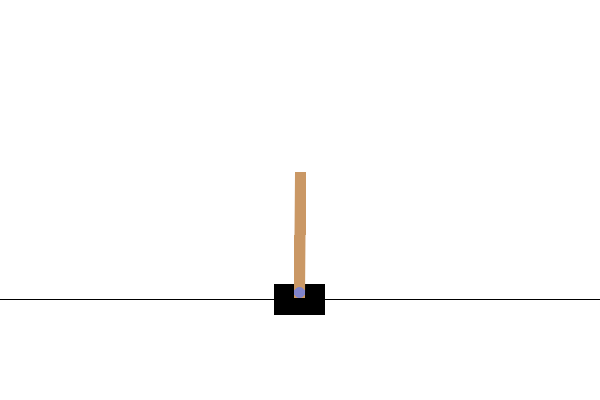

In [14]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

## 다음 단계

이 튜토리얼에서는 Tensorflow를 사용하여 Actor-Critic 방법을 구현하는 방법을 보여주었습니다.

다음 단계로 Gym의 다른 환경에서 모델의 훈련을 시도할 수 있습니다.

Actor-Critic 방법 및 Cartpole-v0 문제에 대한 추가 정보는 다음 리소스를 참조하세요.

- [Actor-Critic 메서드](https://hal.inria.fr/hal-00840470/document)
- [Actor-Critic 강의(CAL)](https://www.youtube.com/watch?v=EKqxumCuAAY&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=7&t=0s)
- [Cart Pole 학습 제어 문제 [Barto 등 1983]{/a}](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf)

TensorFlow에서 더 많은 강화 학습 예를 보려면 다음 리소스를 확인하세요.

- [강화 학습 코드 예제(keras.io)](https://keras.io/examples/rl/)
- [TF-Agents 강화 학습 라이브러리](https://www.tensorflow.org/agents)
